# **AA1 Project** 


## Modeling delays in the air

![Alt Text](flight-delays1.webp)


In order to predict whether a flight is likely to be delayed or not, create a ML model that will make predictions with that aim. 

First of all. Let's import the needed modules and functions for this purpose.  

In [9]:
# All necessary imports for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import ScalarFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import seaborn as sns
from scipy import stats
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
from matplotlib import pyplot
from math import cos, sin, atan
from keras.utils.vis_utils import plot_model
np.random.seed(42)

## Reading the data

For this project, we will be working with the *flights* dataset downloaded from *Kaggle*. However, there is some information from the airports that appear in the dataset that is stored in the *airports* file so we will also need it.

In [10]:
airports = pd.read_csv('airports.csv')

Due to the amount of data in the *flights* file, we will be using only a random subset of it so we are able to get good results while avoid slowing the execution of the project to unacceptable and unfeasible levels. We will be working with 0.1% of the original datai, i.e.: XXXXX rows.

In [11]:
flights = pd.read_csv('flights.csv')
copy_flights = flights.sample(frac=1, random_state=42)
flights = copy_flights[:40000]

/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_40842/2494446931.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('flights.csv')


**Important:** half of the data in flights is going to be stored in test_data. Test_data variable is going to be used to assess with unseen data which model generalizes better (without using X_test). Like this, we can take advantatge of having so much data. However in practical projects this may not be possible. Nevertheless in this case, since due to computational issues we cannot use all of the data, let's use some of the data in this tricky way. 

As we can se with the `describe` method, we can observe the range where each feature takes values at more or less. It is also interesting to observe the histograms of the different columns to see how each feature is distributed more or less, to get an intuition of our data. 

In [12]:
airports.describe()

LATITUDE   LONGITUDE
count  319.000000  319.000000
mean    38.981244  -98.378964
std      8.616736   21.523492
min     13.483450 -176.646030
25%     33.652040 -110.839385
50%     39.297610  -93.403070
75%     43.154675  -82.722995
max     71.285450  -64.798560

array([[<AxesSubplot: title={'center': 'YEAR'}>,
        <AxesSubplot: title={'center': 'MONTH'}>,
        <AxesSubplot: title={'center': 'DAY'}>,
        <AxesSubplot: title={'center': 'DAY_OF_WEEK'}>,
        <AxesSubplot: title={'center': 'FLIGHT_NUMBER'}>],
       [<AxesSubplot: title={'center': 'SCHEDULED_DEPARTURE'}>,
        <AxesSubplot: title={'center': 'DEPARTURE_TIME'}>,
        <AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>,
        <AxesSubplot: title={'center': 'WHEELS_OFF'}>],
       [<AxesSubplot: title={'center': 'SCHEDULED_TIME'}>,
        <AxesSubplot: title={'center': 'ELAPSED_TIME'}>,
        <AxesSubplot: title={'center': 'AIR_TIME'}>,
        <AxesSubplot: title={'center': 'DISTANCE'}>,
        <AxesSubplot: title={'center': 'WHEELS_ON'}>],
       [<AxesSubplot: title={'center': 'TAXI_IN'}>,
        <AxesSubplot: title={'center': 'SCHEDULED_ARRIVAL'}>,
        <AxesSubplot: title={'center': 'ARRIVAL_TIME'}>

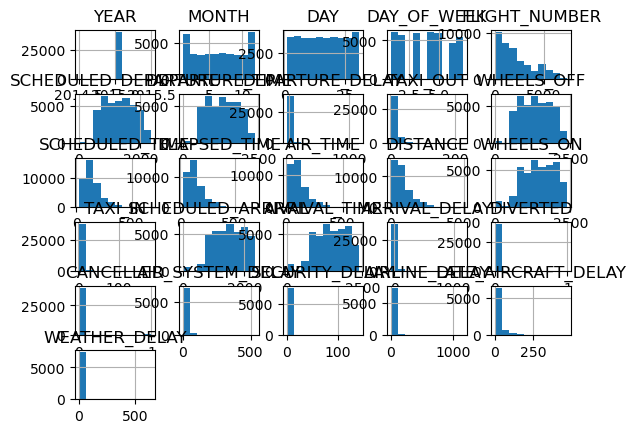

In [13]:
flights.hist()

Based on the results of the histograms, we can appreciate that some of the variables in our dataset present variables where the data appears to be quite concentrated and this could be explained by the presence of large outliers. Some other variables seem to be more uniformally distributed. However, the nature of the distribution that describes the data in our variables shouldn't worry ourselve to much right now as many data processment will be done (including gaussianization of the continuos variables and hot encoding of the categorical ones) before trainging and testing a model.

## 1. Data cleaning
![Alt Text](process1.png)
### Nextly we will portray the schedule that we are going to follow. 
1. **Check for duplicates:** Check for and remove any duplicate rows in our dataset.

2. **Handle missing data:** Identify any missing data and decide how to handle it. We will either remove the rows or fill in the missing data.

3. **Check for inconsistent data:** Check for any inconsistent or erroneous data, such as values that are out of range or inconsistent with other data in the same row.

4. **Handle categorical data:** We will perform one-hot encoding.

5. **Normalize data:** Normalize the data so that the features have similar ranges. This will prevent features with large ranges from dominating the model.

6. **Feature selection:** Select the most relevant features in our model. We will use so in order to assess a dataset that has less features. 


### 1.1 Check for duplicates
We firstly see that there are no duplicate samples with the following piece of code.


In [14]:
duplicates = flights.duplicated()
print(sum(duplicates))

0


### 1.2 Handle missing data
In this section we have a bunch of different possibilities in order to approach the problem of missing data. 
1. Remove missing data: if the quantity of missing data is not that significative, maybe it is a good option to consider removing all those samples that contain `NaN` values since the subset of samples that is going to be deleted may not be significant while training the model. We could input the data by using methods such as mean inputation or k-NN however we found out this is a good option. The key is that we have a lot of data and this eliminating a few samples is not going to affect to our predictions. 



**We are going to delete the following columns for the following reasons:** 

1.YEAR: all of the flights in this dataset are from 2015, therefore this variable is not informative. 

2.FLIGHT_NUMBER: the flight number has no correlation with the delay of flights. 

3.TAIL_NUMBER: the tail number has no correlation with the delay of flights. 

4.SCHEDULED_DEPARTURE: It is very correlated and less informative than the variable DEPARTURE_TIME. 

5.ELAPSED_TIME: this variable is very informative. In fact, if we have both elapsed and departure time we can almost perfectly predict delays. However this is an information we will have posterior to the prediction, therefore we found it a bit tricky to use this variable to predict delays. Therefore we decided to eliminate this feature although it is very informative since we consider it is not realistic to consider it as information to predict flight delays. 

5.AIR_TIME: this variable is also informative but we've decided to eliminate it by the same reasons than the variable ELAPSED_TIME

5.WHEELS_ON: this variable is also informative but we've decided to eliminate it by the same reasons than the variable ELAPSED_TIME

5.TAXI_IN: this variable is also informative but we've decided to eliminate it by the same reasons than the variable ELAPSED_TIME

5.ARRIVAL_TIME: this variable is also informative but we've decided to eliminate it by the same reasons than the variable ELAPSED_TIME

10.DIVERTED: we've eliminate it since it is not enough correlated with delays.

10.CANCELLED: we've eliminate it since if the flight is cancelled, we do not have a value in the ARRIVAL_DELAY column and therefore we cannot predict it. 

11.CANCELLATION_REASON: lack of information in the majority of the columns

11.AIR_SYSTEM_DELAY: lack of information in the majority of the columns

11.SECURITY_DELAY: lack of information in the majority of the columns

11.AIRLINE_DELAY: lack of information in the majority of the columns

11.LATE_AIRCRAFT_DELAY: lack of information in the majority of the columns

11.WEATHER_DELAY: lack of information in the majority of the columns

12.WHEELS_OFF: very correlated with DEPARTURE_TIME

In [15]:
#1
flights["YEAR"].unique()

array([2015])

In [16]:
#2
flight_number = flights['FLIGHT_NUMBER']
arrival_delay = flights['ARRIVAL_DELAY']
correlation = flight_number.corr(arrival_delay)
print("Correlation between FLIGHT_NUMBER and ARRIVAL_DELAY:", correlation)
# Moreover apart from observing that the correlation is very low, we have a lot of categories and it would be a problem to one hot encode this variable
print(len(flights['FLIGHT_NUMBER'].unique()))

Correlation between FLIGHT_NUMBER and ARRIVAL_DELAY: 0.012016946784082152
5959


In [17]:
#3
tail_number = flights['TAIL_NUMBER']
arrival_delay = flights['ARRIVAL_DELAY']
df_cleaned = flights[['TAIL_NUMBER', 'ARRIVAL_DELAY']].dropna()
# Convert TAIL_NUMBER to numeric labels using factorize
tail_number_labels, _ = pd.factorize(df_cleaned['TAIL_NUMBER'])
# Compute the point-biserial correlation
correlation, p_value = stats.pointbiserialr(tail_number_labels, df_cleaned['ARRIVAL_DELAY'])
print("Point-biserial correlation between TAIL_NUMBER and ARRIVAL_DELAY:", correlation)
print("p-value:", p_value)
#The point-biserial correlation ranges between -1 and 1, where a value close to 1 indicates a strong positive 
#correlation, a value close to -1 indicates a strong negative correlation, and a value close to 0 indicates a 
#weak or no correlation. Since we get -0.026, we consider no correlation

Point-biserial correlation between TAIL_NUMBER and ARRIVAL_DELAY: -0.0044219129947491624
p-value: 0.3807052148576987


In [18]:
#4
scheduled_departure = flights['SCHEDULED_DEPARTURE']
arrival_delay = flights['ARRIVAL_DELAY']
correlation = scheduled_departure.corr(arrival_delay)
print("Correlation between scheduled_departure and arrival_delay:", correlation)
print(len(flights['FLIGHT_NUMBER'].unique()))

# We nevertheless eliminate it since we observe the following correlation of SCHEDULED_DEPARTURE with DEPARTURE_TIME (that is more informative)
scheduled_departure = flights['SCHEDULED_DEPARTURE']
departure_time = flights['DEPARTURE_TIME']
correlation = scheduled_departure.corr(departure_time)
print("Correlation between scheduled_departure and departure_time:", correlation)
print(len(flights['FLIGHT_NUMBER'].unique()))


Correlation between scheduled_departure and arrival_delay: 0.10593795946606713
5959
Correlation between scheduled_departure and departure_time: 0.9651981044841464
5959


In [19]:
# 10 
# No correlation: 
correlations = flights.corr()['DIVERTED'].sort_values(ascending=False)
print(correlations)

DIVERTED               1.000000
DEPARTURE_DELAY        0.020606
SCHEDULED_TIME         0.015408
DISTANCE               0.012362
TAXI_IN                0.006996
SCHEDULED_ARRIVAL      0.006072
MONTH                  0.005031
FLIGHT_NUMBER          0.002852
TAXI_OUT               0.002503
WHEELS_OFF            -0.001203
DAY                   -0.001339
DEPARTURE_TIME        -0.001519
SCHEDULED_DEPARTURE   -0.002180
WHEELS_ON             -0.003079
DAY_OF_WEEK           -0.004186
ARRIVAL_TIME          -0.005104
CANCELLED             -0.005791
YEAR                        NaN
ELAPSED_TIME                NaN
AIR_TIME                    NaN
ARRIVAL_DELAY               NaN
AIR_SYSTEM_DELAY            NaN
SECURITY_DELAY              NaN
AIRLINE_DELAY               NaN
LATE_AIRCRAFT_DELAY         NaN
WEATHER_DELAY               NaN
Name: DIVERTED, dtype: float64


/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_40842/3435421827.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = flights.corr()['DIVERTED'].sort_values(ascending=False)


In [20]:
#11 A lot of nan-values in those columns. 
nan_counts = flights[["CANCELLATION_REASON", "AIR_SYSTEM_DELAY", "SECURITY_DELAY", "AIRLINE_DELAY", "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]].isna().sum()
print("NaN counts for each column:")
print(nan_counts)

NaN counts for each column:
CANCELLATION_REASON    39387
AIR_SYSTEM_DELAY       32549
SECURITY_DELAY         32549
AIRLINE_DELAY          32549
LATE_AIRCRAFT_DELAY    32549
WEATHER_DELAY          32549
dtype: int64


In [21]:
# 12: Very correlated with some other variables
correlations = flights.corr()['WHEELS_OFF'].sort_values(ascending=False)
print(correlations)

WHEELS_OFF             1.000000
DEPARTURE_TIME         0.977086
SCHEDULED_DEPARTURE    0.943087
SCHEDULED_ARRIVAL      0.726794
WHEELS_ON              0.701332
ARRIVAL_TIME           0.672752
LATE_AIRCRAFT_DELAY    0.181742
DEPARTURE_DELAY        0.166875
ARRIVAL_DELAY          0.155245
TAXI_OUT               0.032042
SECURITY_DELAY         0.010939
FLIGHT_NUMBER          0.010172
DAY_OF_WEEK            0.002868
DAY                   -0.000044
DIVERTED              -0.001203
CANCELLED             -0.001884
WEATHER_DELAY         -0.011265
MONTH                 -0.013477
DISTANCE              -0.026985
SCHEDULED_TIME        -0.028590
ELAPSED_TIME          -0.029105
AIR_TIME              -0.030979
TAXI_IN               -0.036965
AIRLINE_DELAY         -0.043507
AIR_SYSTEM_DELAY      -0.047417
YEAR                        NaN
Name: WHEELS_OFF, dtype: float64


/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_40842/1537956969.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = flights.corr()['WHEELS_OFF'].sort_values(ascending=False)


**Therefore we have justified why we've eliminated these columns and this will be our neew subset of features:**

In [22]:
cols_of_interest = ['ARRIVAL_DELAY','MONTH', 'DAY' ,'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'DISTANCE']
flights = flights[cols_of_interest]

Leading to the following subset of columns: 

In [23]:
list(flights.columns)

['ARRIVAL_DELAY',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_ARRIVAL',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'SCHEDULED_TIME',
 'DISTANCE']

And we nextly end up removing the samples that have some NaN values. 

In [24]:
l_bef = len(flights)
flights = flights.dropna(how='any')
l_aft = len(flights)
print(l_bef, l_aft)

40000 39301


In the original dataset, we pass from $20000$ to $19663$ samples. In other words, we keep the $98.315\%$ of the samples, so it may be a good option to work with these new subset of samples that still contain a vast quantity of information.   

### 1.3 Check for inconsistent data
In order to do so, we firstly observe an overview of our data. 


In [25]:
flights.describe()

ARRIVAL_DELAY         MONTH           DAY   DAY_OF_WEEK  \
count   39301.000000  39301.000000  39301.000000  39301.000000   
mean        4.389329      6.536017     15.656141      3.905957   
std        38.004138      3.396954      8.780141      1.978192   
min       -62.000000      1.000000      1.000000      1.000000   
25%       -13.000000      4.000000      8.000000      2.000000   
50%        -5.000000      7.000000     16.000000      4.000000   
75%         8.000000      9.000000     23.000000      6.000000   
max      1167.000000     12.000000     31.000000      7.000000   

       SCHEDULED_ARRIVAL  DEPARTURE_TIME  DEPARTURE_DELAY      TAXI_OUT  \
count       39301.000000    39301.000000     39301.000000  39301.000000   
mean         1491.122338     1331.510623         9.267678     16.035139   
std           505.721475      496.158936        35.531140      8.882373   
min             1.000000        1.000000       -36.000000      1.000000   
25%          1108.000000      920.000000        -5.000000     11.000000   
50%          1515.000000     1326.000000        -2.000000     14.000000   
75%          1915.000000     1737.000000         8.000000     19.000000   
max          2359.000000     2400.000000      1176.000000    225.000000   

       SCHEDULED_TIME      DISTANCE  
count    39301.000000  39301.000000  
mean       142.263785    826.705555  
std         75.719212    611.069895  
min         20.000000     31.000000  
25%         86.000000    373.000000  
50%        123.000000    647.000000  
75%        174.000000   1068.000000  
max        680.000000   4983.000000

And we will plot a few histograms of the variables in our dataset to get a deeper understanding of their nature. First of all we are going to implement a function that is going to allow us to plot the histogram and personalize a few parameters such as the title, labels for the axis and the options to apply logarithms to any of the axis.

**Important:** this plots do not help us to decide which transformations we apply to data, we only are looking for inconsistencies that may affect in the future in modelling. Such as bad formatting etc.

In [26]:
#Custom function that allows us to plot customized graphs
def plot_histogram_of_column(data, title, x_title, y_title, x_log, y_log):
    # Assign default title if none is provided
    if not title:
        title = "Histogram"

    # Assign default title to x axis if none is provided
    if not x_title:
        x_title = "Value"
    
    # Assing default title to y axis if none is provided
    if not y_title:
        y_title = "Count"
    
    # Apply logarithm to x axis if required
    if x_log:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(data, bins=10**np.linspace(np.log10(0.1), np.log10(data.max()), 50))
        ax.set_xscale('log')
        x_title = "Log " + x_title
    else:
        # Create plot with histogram of DAY column
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.hist(data)


    # Apply logarithm to y-axis if required
    if y_log:
        ax.set_yscale('log')
        y_title = "Log " + y_title
    
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)
    plt.show()

Now that we have created a function that allows us to easily plot any column from the dataset that we are interested in, we will start by studying the nature of the columns that refer to delays on the flights

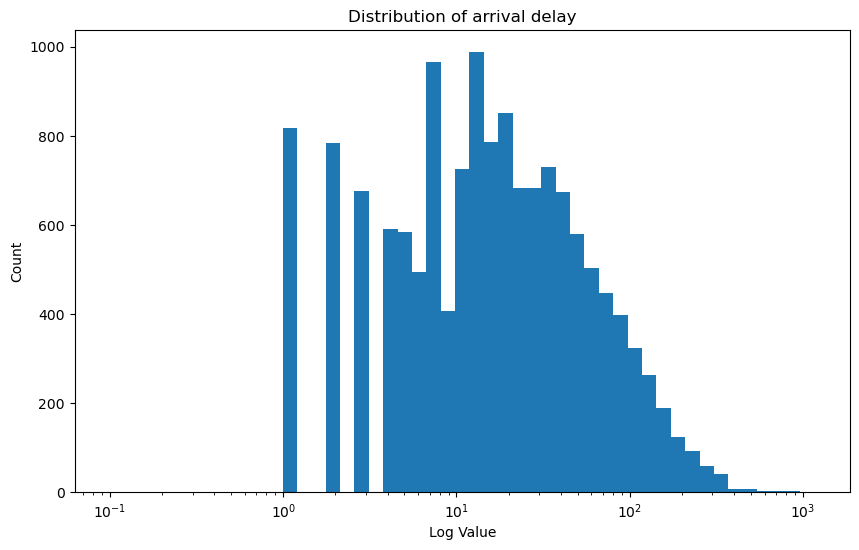

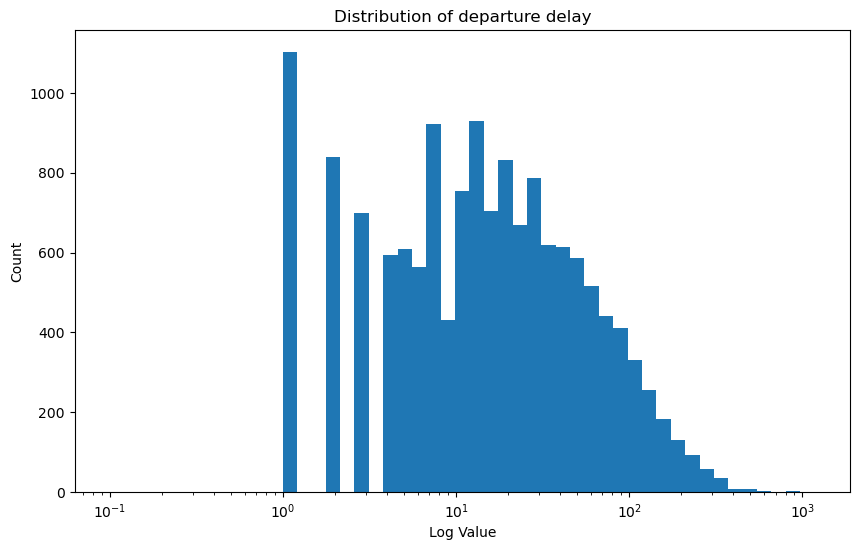

In [27]:
# Plot of the arrival_delay column
plot_histogram_of_column(flights["ARRIVAL_DELAY"], "Distribution of arrival delay", None, None, True, False)

# Histogram of DEPARTURE_DELAY column
plot_histogram_of_column(flights["DEPARTURE_DELAY"], "Distribution of departure delay", None, None, True, False)

It can be seen that both histograms share a similar shape, which means that these two variables are strongly correlated. However, we expected to get this result since those flights that suffer departure with any form of delay are extremely likely to also arrive with a similar delay.

Another interesting result extracted from the data is that there are quite a lot of flights that depart before their scheduled departure time. Moreover, if we compare closely both histograms, we will notice that the amount of flights that arrive before their arrival time is smaller than the number of flights that departure ahead of their departure time.

Next we are going to analyse how the variables containing data related with the date of the flight are distributed.

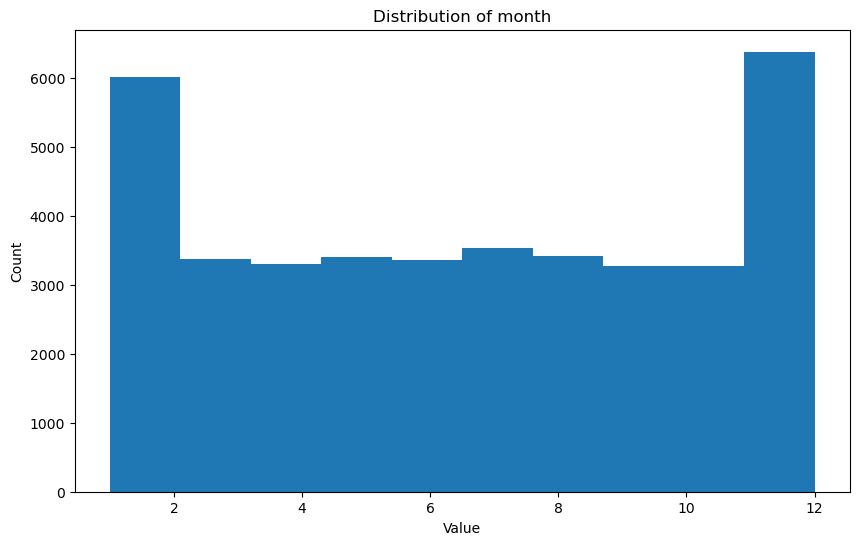

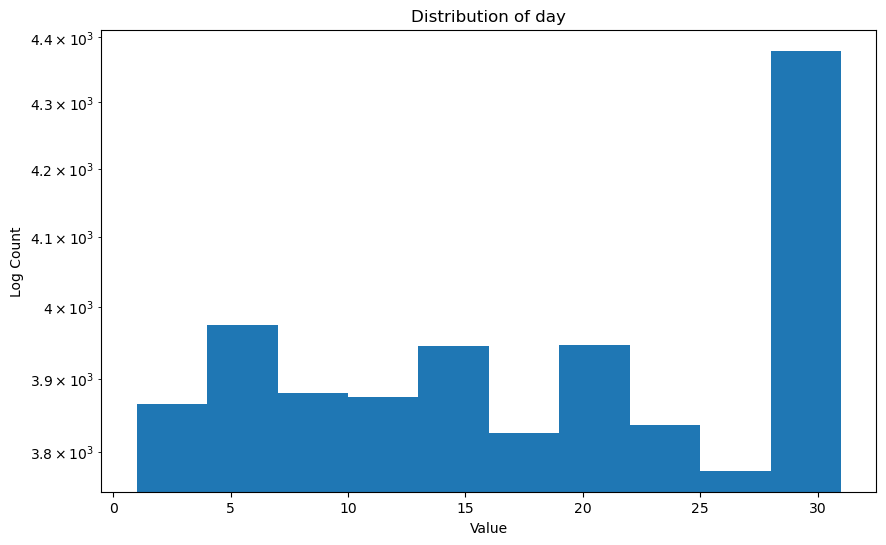

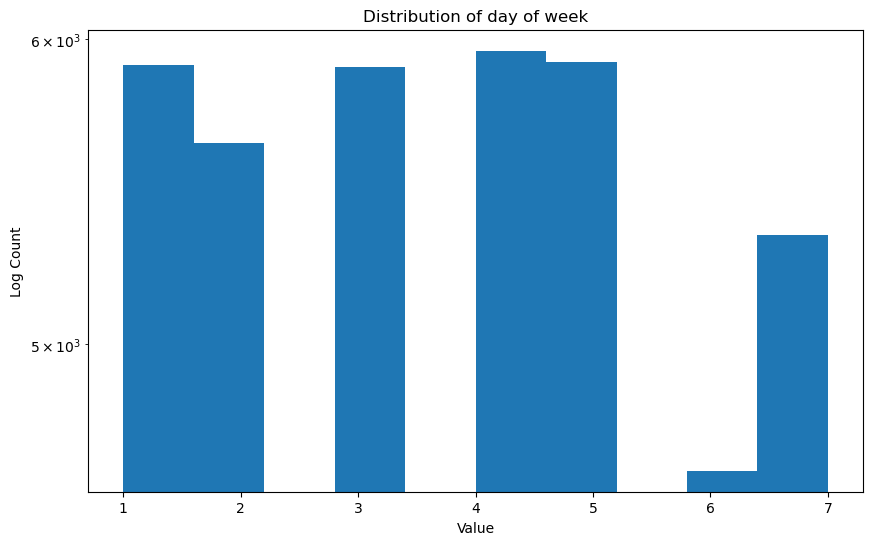

In [28]:
plot_histogram_of_column(flights["MONTH"], "Distribution of month", None, None, False, False)

# Create plot with histogram of DAY column
plot_histogram_of_column(flights["DAY"], "Distribution of day", None, None, False, True)

# Histogram of DAY_OF_WEEK colum
plot_histogram_of_column(flights["DAY_OF_WEEK"], "Distribution of day of week", None, None, False, True)



And, finally, we'll plot some other columns that could be interesting to analyse.

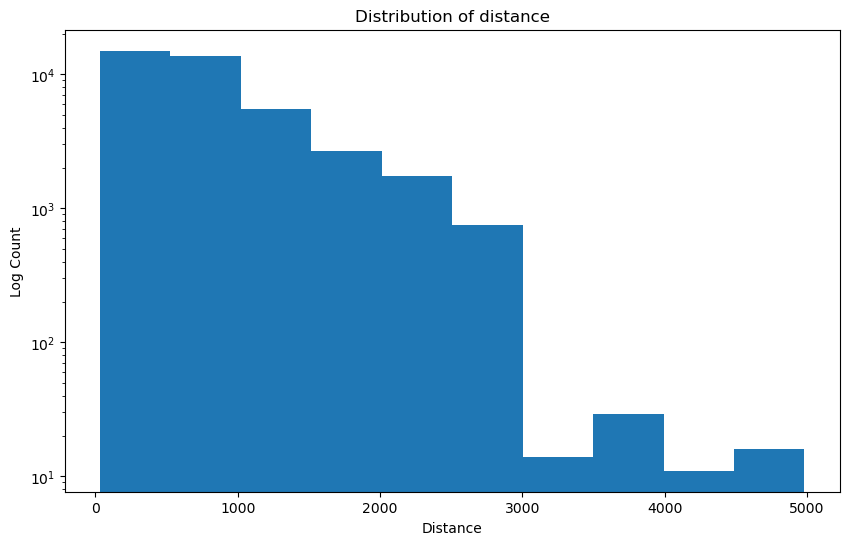

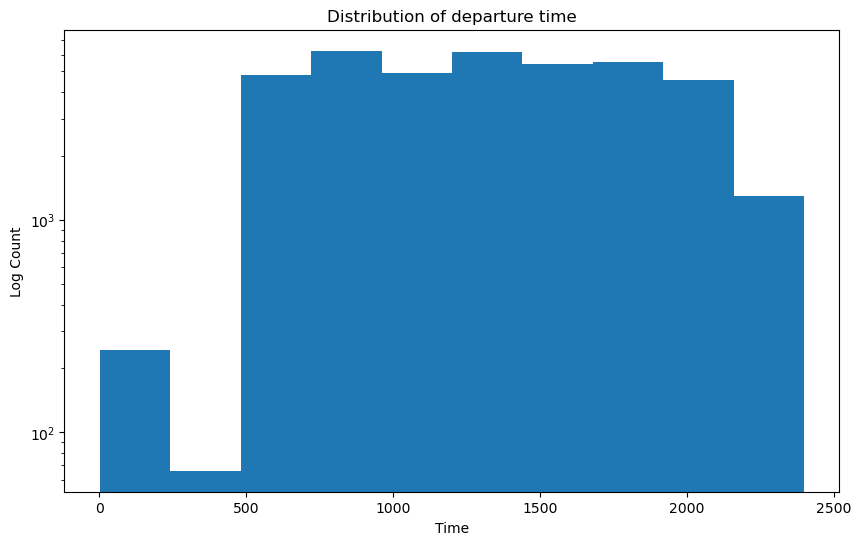

In [29]:
plot_histogram_of_column(flights["DISTANCE"], "Distribution of distance", "Distance", None, False, True)

plot_histogram_of_column(flights["DEPARTURE_TIME"], "Distribution of departure time", "Time", None, False, True)

Looking at the distance plot, we observe that the distance of the vast majority of flights range between a few hundred and a three thousand miles. The longest flights in the dataset are around 5000 miles. 

On the other hand, looking at the distribution of the departure time variable, we see that flight departure are almost uniformly distributed from 6 am to 8 pm. From 9 pm to 5 am, a much smaller number of departure take place.
Moreover we observe that the vast amount of airports we have needs to be transformed in order to one-hot encode it properly. 

We also observe that some inconsistencies of data (representing a same timestamp in two different formats) so we solve this: 

In [30]:
flights.loc[flights['DEPARTURE_TIME'] == 2400, 'DEPARTURE_TIME'] = 2359
flights.describe()

ARRIVAL_DELAY         MONTH           DAY   DAY_OF_WEEK  \
count   39301.000000  39301.000000  39301.000000  39301.000000   
mean        4.389329      6.536017     15.656141      3.905957   
std        38.004138      3.396954      8.780141      1.978192   
min       -62.000000      1.000000      1.000000      1.000000   
25%       -13.000000      4.000000      8.000000      2.000000   
50%        -5.000000      7.000000     16.000000      4.000000   
75%         8.000000      9.000000     23.000000      6.000000   
max      1167.000000     12.000000     31.000000      7.000000   

       SCHEDULED_ARRIVAL  DEPARTURE_TIME  DEPARTURE_DELAY      TAXI_OUT  \
count       39301.000000    39301.000000     39301.000000  39301.000000   
mean         1491.122338     1331.508537         9.267678     16.035139   
std           505.721475      496.154529        35.531140      8.882373   
min             1.000000        1.000000       -36.000000      1.000000   
25%          1108.000000      920.000000        -5.000000     11.000000   
50%          1515.000000     1326.000000        -2.000000     14.000000   
75%          1915.000000     1737.000000         8.000000     19.000000   
max          2359.000000     2359.000000      1176.000000    225.000000   

       SCHEDULED_TIME      DISTANCE  
count    39301.000000  39301.000000  
mean       142.263785    826.705555  
std         75.719212    611.069895  
min         20.000000     31.000000  
25%         86.000000    373.000000  
50%        123.000000    647.000000  
75%        174.000000   1068.000000  
max        680.000000   4983.000000

As we can infer from the output of the `decribe()` method, there are no values that are out of range or are non-sense in comparison with other values of the same column. 

However we observe some weird formats that we are going to solve in the following cells in order to have no problems with the modelling. 

In [31]:
# Delete all of the rows that contain integer values
flights = flights[~flights['ORIGIN_AIRPORT'].apply(lambda x: isinstance(x, int))]
flights = flights[~flights['DESTINATION_AIRPORT'].apply(lambda x: isinstance(x, int))]

In [32]:
flights = flights[~flights['ORIGIN_AIRPORT'].apply(lambda x: str(x).isnumeric())]
flights = flights[~flights['DESTINATION_AIRPORT'].apply(lambda x: str(x).isnumeric())]

### 1.4 Handle categorical data


In [33]:
list(flights.columns)

['ARRIVAL_DELAY',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_ARRIVAL',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'SCHEDULED_TIME',
 'DISTANCE']

We are going to start by looking at our columns to determine what type of data each one of them contains.


In [34]:
#Check the nature of the columns 
for col in flights.columns:
  print(col, flights[col].dtype)

ARRIVAL_DELAY float64
MONTH int64
DAY int64
DAY_OF_WEEK int64
AIRLINE object
ORIGIN_AIRPORT object
DESTINATION_AIRPORT object
SCHEDULED_ARRIVAL int64
DEPARTURE_TIME float64
DEPARTURE_DELAY float64
TAXI_OUT float64
SCHEDULED_TIME float64
DISTANCE int64


Now that we have an idea of the nature of each column we must determine which columns we are going to modify. Those columns are going to be the ones containing categorical variables. We are going to modify:
- Month
- Arrival_delay
- Day
- Day_of_week
- Airline
- Origin_airport
- Destination_airport

The next thing we want to do after observing the types of every feature is to transform some variables to categorical

#### Month column

The transformation we have chosen for the MONTH column is grouping the month by quarters. This will allow us to reduce the number of categories from 12 to 3. 

Additionally, when dividing the year in quarters we get a partition that closely matches the different travel seasons. Summer season matches almost perfectly with the second quarter while the first and third quarter match with winter season.

In [35]:
# MONTH treatment: group months in quarters
flights['Q_YEAR'] = flights['MONTH'].apply(lambda x: (x-1)//4 + 1)

#### Arrival_delay column

Another column which's data we need to process is the ARRIVAL_DELAY column. This column is the one we want to predict and the aim of our model is to be able to predict if a flight will arrive to its destination with some type of delay. Therefore, we want to convert this column into a column with binary values.

We will create a new column in our dataset (i.e. DELAYED) which will have a 1 if the flight is delayed and 0 otherwise. A key point is to decide whether when a flight can be considered delayed or not. To do so we've researched and in various sources we've found that a flight is considered to be delayed if it gets 15 minutes late or more. That is why we are going to set the threshold in 15 minutes as we can observe in the following code. 
Some of the sources: https://en.wikipedia.org/wiki/Flight_cancellation_and_delay & https://www.trefis.com/stock/dal/articles/375013/what-is-the-impact-of-flight-delays/2016-08-31 where we can observe the following information: 

The United States Federal Aviation Administration (FAA) considers a flight to be delayed when it is 15 minutes later than its scheduled time. A cancellation occurs when the airline does not operate the flight at all for a certain reason.

In [36]:
# DELAY treatment
flights['DELAYED'] = flights['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 15 else 0)

#### Day column

The DAY column has values that range from 1 to 31, which it's unfeasible to work with. We have decided to divide the month in two fortnights and classify each day with the value of the fortnight they belong to. 
- From days 1 - 15 they will belong to the first fortnight. They will have a value of 1.
- From days 15 - 31 they will belong to the second fortnight. The will have a value of 2.

In [37]:
# DAY treatment: group by fortnights
flights['FORTNIGHT'] = pd.cut(flights['DAY'], bins=[0, 15, 31], labels=[1, 2], include_lowest=True)


We believe that this is an appropiate transformation because, usually, people earn they salaries at the end of the month. Therefore, people will have more money available during the first fortnight and this could mean that the number of passengers increase causing to be more flights during the first fortnight. 


#### Day_of_week column

The same arguments we used for the DAY column apply to DAY_OF_WEEK. The values in this column range from 1 (i.e.: Monday) to 7 (i.e.: Sunday). Instead of working with each of this values, we are going to separate them into working days and weekends.

In [38]:
# DAY_OF_WEEK treatment: 1 is in-week days, 2 is weekend

flights['WEEK_INFO'] = pd.cut(flights['DAY_OF_WEEK'], bins=[1, 5, 7], labels=[1, 2], include_lowest=True)


#### Airline column

We are now going to treat the AIRLINES column. Originally, our dataframe had around 15 different airlines and we considered that it was going to be unfeasible to work with all of them. Therefore, we have decided to divide them intro three major groups:
- Major airlines
- Low cost airlines
- Regional airlines

We believe that this is a valid division because the nature of the airline could possibly affect the amount of delayed flights they have. 

In [39]:
# AIRLINE treatment

# Define the airlines categories
major_airlines = ['DL', 'AA', 'UA', 'US', 'AS']
low_cost_airlines = ['WN', 'NK', 'F9', 'B6', 'VX']
regional_airlines = ['EV', 'OO', 'MQ', 'HA']

# create a new column with the airline category
flights['AC'] = 'Other'
flights.loc[flights['AIRLINE'].isin(major_airlines), 'AC'] = 'Major'
flights.loc[flights['AIRLINE'].isin(low_cost_airlines), 'AC'] = 'Low-Cost'
flights.loc[flights['AIRLINE'].isin(regional_airlines), 'AC'] = 'Regional'

We now can observe how the types of airlines tend to be quite equilibrated. 

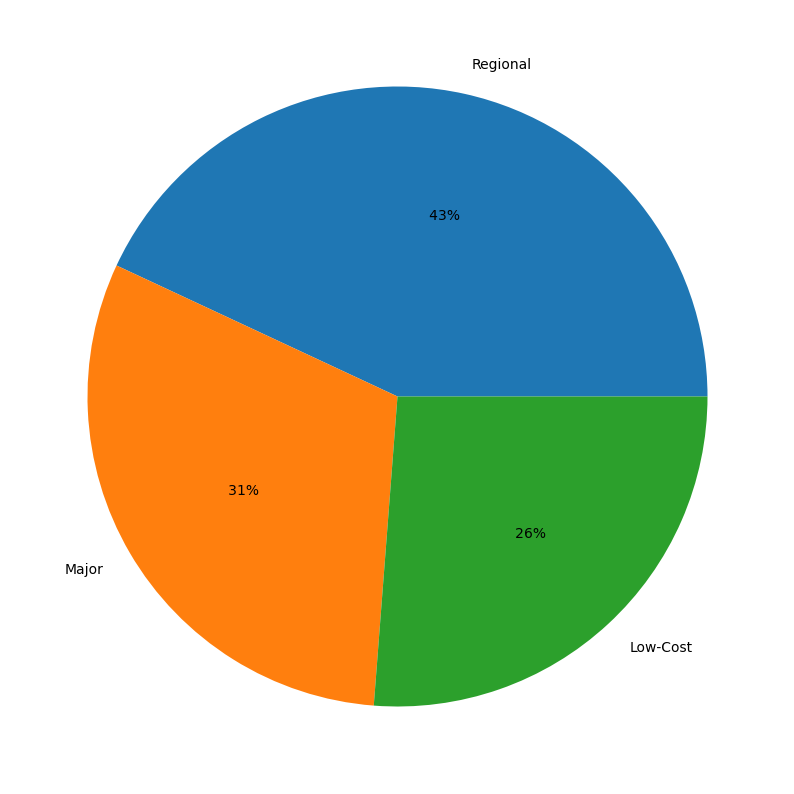

In [40]:
plt.subplots(figsize=(10,14))
airlines = flights["AC"].unique()
num_airlines = flights["AC"].value_counts()
plt.pie(num_airlines,labels=airlines,autopct='%5.0f%%')
plt.show()

#### Origin_airport column

In the original dataset there are over 300 different airports. Although it would be great to be able to keep all of them as individual categories, we have also considered it unfeasible. So, in order to reduce the number of categories, we are going to divide the USA territory in four quadrants:
- Upper left
- Upper right
- Bottom right
- Bottom left

However, before being able to classify the airports as we just mentioned, we first need to get its coordinates. This can be achieved by extracting the necessary data (i.e. longitude and latitude) from the *airports* dataset

In [41]:
# Change the index of the dataset to the IATA_CODE (code that identifies each airport)
airports = airports.set_index('IATA_CODE')

In [42]:
# Add LONGITUDE_O column to each row in flights with the longitude of the origin airport
flights['LONGITUDE_O'] = flights['ORIGIN_AIRPORT'].apply(lambda x: airports.loc[x]['LONGITUDE'])

# Add LATITUDE_O column to each row in flights with the latitude of the origin airport
flights['LATITUDE_O'] = flights['ORIGIN_AIRPORT'].apply(lambda x: airports.loc[x]['LATITUDE'])

However, we have detected that some rows have a *NaN* value in either their longitude or latitude. Since this happens rarely, we can delete those columns without loosing to many rows. 

In [43]:
# we observe some nans are generated and we remove them 
counter = flights["LONGITUDE_O"].isna() == False
count_false = sum(counter)
print(count_false/len(flights["LONGITUDE_O"]))
flights = flights.dropna(how='any')

0.9994171523730225


Once we have removed al conflictive rows, we can proceed with the classification of the airports by its location.

In [44]:
# Create empty column with airport location (i.e.: GR_O)
flights['GR_O'] = ''

# Classify the airports
# Upper right
flights.loc[(flights['LONGITUDE_O'] >= -100) & (flights['LATITUDE_O'] >= 37), 'GR_O'] = 'UPPER_RIGHT'

# Upper left
flights.loc[(flights['LONGITUDE_O'] < -100) & (flights['LATITUDE_O'] >= 37), 'GR_O'] = 'UPPER_LEFT'

# Bottom right
flights.loc[(flights['LONGITUDE_O'] >= -100) & (flights['LATITUDE_O'] < 37), 'GR_O'] = 'BOTTOM_RIGHT'

# Bottom left
flights.loc[(flights['LONGITUDE_O'] < -100) & (flights['LATITUDE_O'] < 37), 'GR_O'] = 'BOTTOM_LEFT'


Lastly, we check that all airports have been given a location and that there are no empty quadrants, which would indicate that the classification is not correctly implemented.

In [45]:
flights["GR_O"].unique()

array(['UPPER_RIGHT', 'BOTTOM_LEFT', 'UPPER_LEFT', 'BOTTOM_RIGHT'],
      dtype=object)

#### Destination_airport column

We are going to apply the same transformations we just applied for the destination airport column. We first add the coordinates of the airports.

In [46]:
flights['LONGITUDE_D'] = flights['DESTINATION_AIRPORT'].apply(lambda x: airports.loc[x]['LONGITUDE'])
flights['LATITUDE_D'] = flights['DESTINATION_AIRPORT'].apply(lambda x: airports.loc[x]['LATITUDE'])

We remove all rows with NaN values.

In [47]:
# we observe some nans are generated and we remove them 
counter = flights["LONGITUDE_D"].isna() == False
count_false = sum(counter)
print(count_false)
print(len(flights["LONGITUDE_D"]))

flights = flights.dropna(how='any')

35980
36009


And classify the destination airports based on their coordinates.

In [48]:
flights['GR_D'] = ''
flights.loc[(flights['LONGITUDE_D'] >= -100) & (flights['LATITUDE_D'] >= 37), 'GR_D'] = 'UPPER_RIGHT'
flights.loc[(flights['LONGITUDE_D'] < -100) & (flights['LATITUDE_D'] >= 37), 'GR_D'] = 'UPPER_LEFT'
flights.loc[(flights['LONGITUDE_D'] >= -100) & (flights['LATITUDE_D'] < 37), 'GR_D'] = 'BOTTOM_RIGHT'
flights.loc[(flights['LONGITUDE_D'] < -100) & (flights['LATITUDE_D'] < 37), 'GR_D'] = 'BOTTOM_LEFT'

In [49]:
flights["GR_D"].unique()

array(['UPPER_RIGHT', 'UPPER_LEFT', 'BOTTOM_RIGHT', 'BOTTOM_LEFT'],
      dtype=object)

**Obtaining the following distribution:**



![Alt Text](airport_segmentation.png)

#### Classify scheduled_time and departure_time

The original dataset has a few columns with values ranging from 0000 to 2359. This values are found in columns scheduled_time and departure_time and they represent an hour and minutes. The format is hhmm (i.e.: 1915 is 19:15).

Once again, having 2359 categories is unfeasible. The solution we have come up with is dividing the day between daytime and nightime.

In [50]:
def classify_time(time):
    sunrise = 600.0   
    sunset = 1800.0   
    
    if time >= sunrise and time < sunset:
        return 'Daytime'
    else:
        return 'Nighttime' 

After having defined the function that will allow us to apply the classification, we apply it to the data.


In [51]:
# Change formatting of SCHEDULED_ARRIVAL and DEPARTURE_TIME
flights['ArrivalDayNight'] = flights['SCHEDULED_ARRIVAL'].apply(classify_time)
flights['DepartureDayNight'] = flights['DEPARTURE_TIME'].apply(classify_time)

#### Remove unwanted columns

After dealing with and processing all categorical data, we are left with a few unwanted columns, those ones we have used to create new columns. We will remove them.

In [52]:
flights.columns

Index(['ARRIVAL_DELAY', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_ARRIVAL',
       'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME',
       'DISTANCE', 'Q_YEAR', 'DELAYED', 'FORTNIGHT', 'WEEK_INFO', 'AC',
       'LONGITUDE_O', 'LATITUDE_O', 'GR_O', 'LONGITUDE_D', 'LATITUDE_D',
       'GR_D', 'ArrivalDayNight', 'DepartureDayNight'],
      dtype='object')

In [53]:
flights = flights[['DELAYED','DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME',
       'DISTANCE', 'Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O',
       'GR_D', 'ArrivalDayNight', 'DepartureDayNight']]

In [54]:
flights.columns

Index(['DELAYED', 'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'DISTANCE',
       'Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O', 'GR_D',
       'ArrivalDayNight', 'DepartureDayNight'],
      dtype='object')

Once we've already selected the columns we are going to use, we can observe the correlation matrix for our dataset. 

/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_40842/2085452572.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(flights.corr(),annot = True)


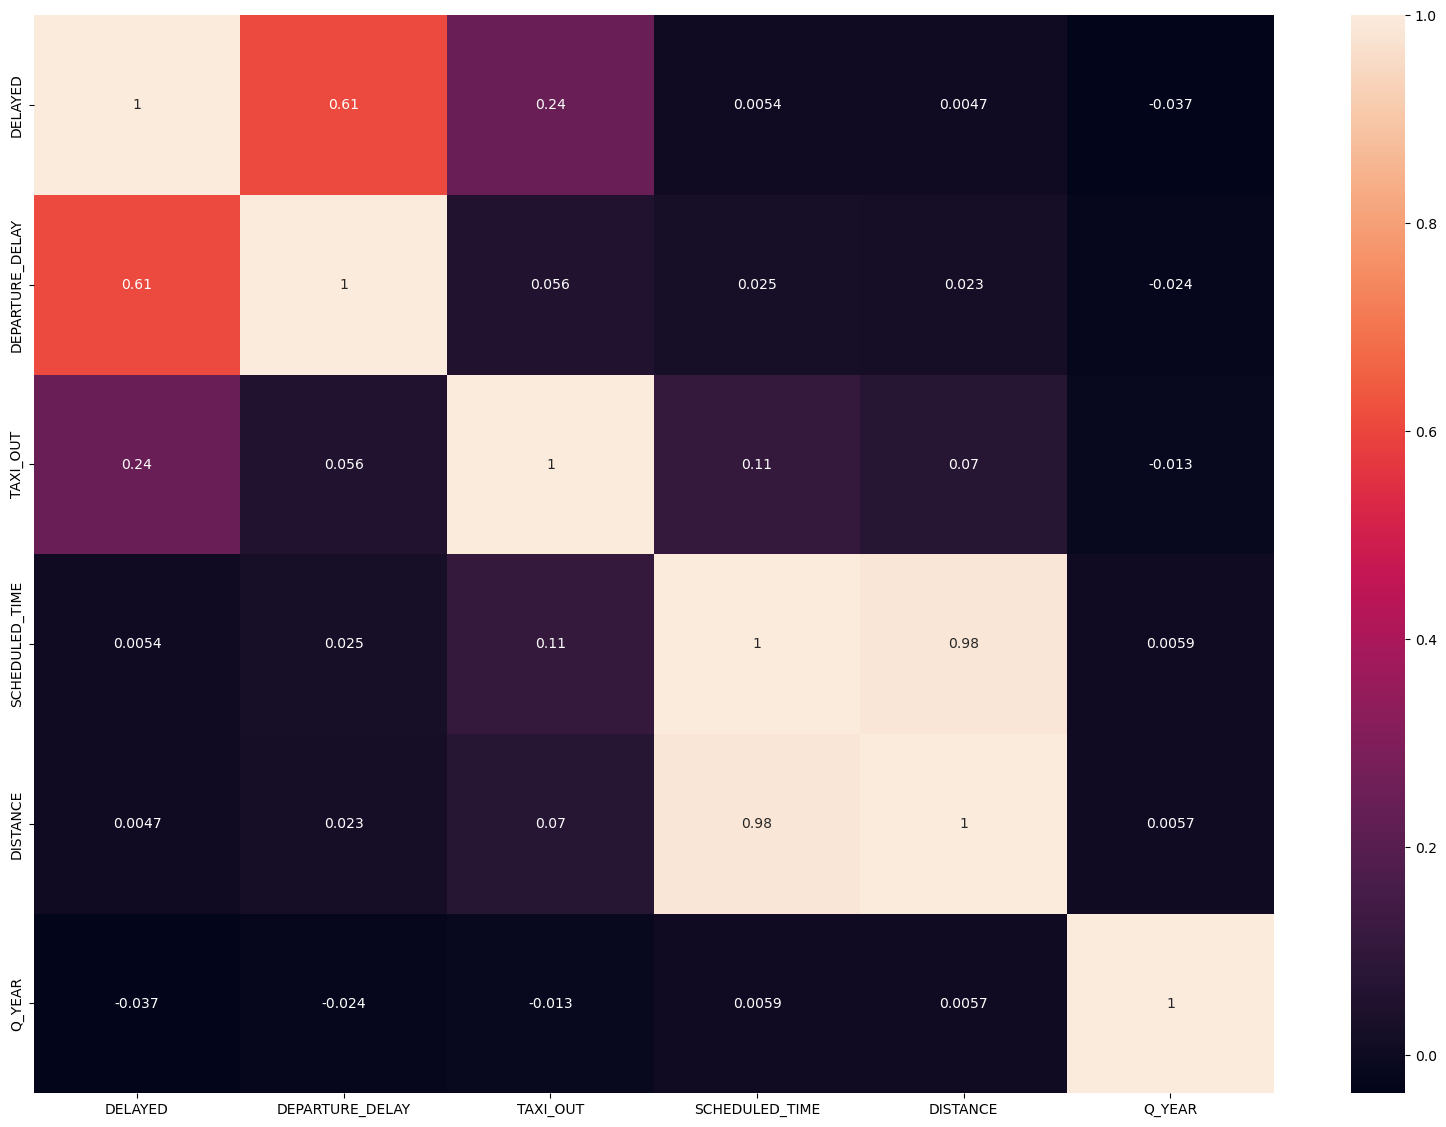

In [55]:
axis = plt.subplots(figsize=(20,14))
sns.heatmap(flights.corr(),annot = True)
plt.show()

We observe that the variables SCHEDULED_TIME, DISTANCE, and Q_YEAR seem to be no that informative. However we will proceed with them since we believe that they are factors that may affect on the possibility of a flight to suffer from more unforeseens

## Data visualization

#### Note
In order to do the process correctly, normalization across instances should be done after splitting the data between training and test set, using only the data from the training set. This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance. In our case, that is what we are going to do right now.

Moreover, first we will split the whole amount of data onto flights and test_data. Test_data will be data not used for the modelling, only for the testing. However this won't be the data that we use to check how de model generalizes. Since we have a lot of data we just get this extra samples just in case we want to fit the models with another subset of the data. 

In [56]:
test_data = flights[17990:35980]
flights = flights[:17990]

In [57]:
X = flights.drop("DELAYED", axis=1)  
y = flights["DELAYED"] 
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

array([[<AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>],
       [<AxesSubplot: title={'center': 'SCHEDULED_TIME'}>,
        <AxesSubplot: title={'center': 'DISTANCE'}>],
       [<AxesSubplot: title={'center': 'Q_YEAR'}>, <AxesSubplot: >]],
      dtype=object)

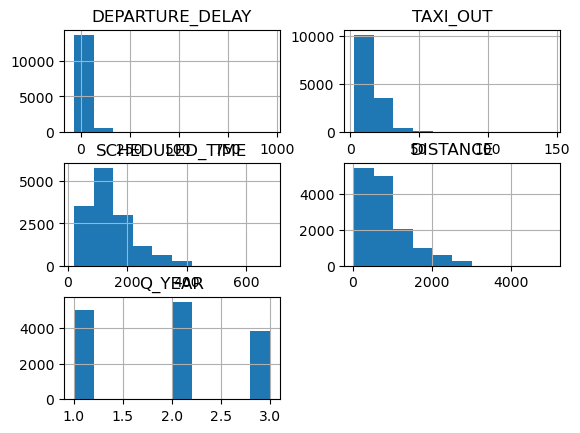

In [58]:
X_train.hist()

And we observe that the distribution of the features are the same than that of the whole dataset. 

Once we have processed all our data, it migh be interesting to, once again, visualize the distribution from some of the new columns we have added to the dataset and study if we can extract any knowledge from them.

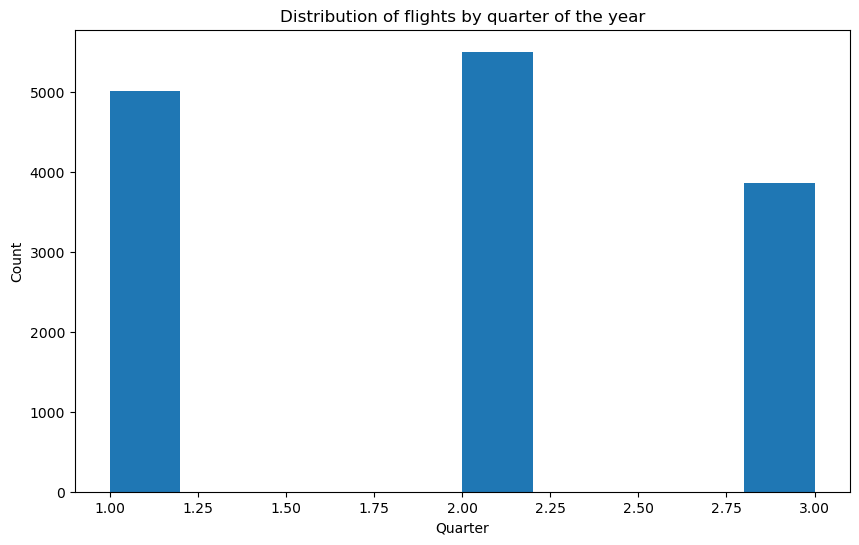

In [59]:
plot_histogram_of_column(X_train["Q_YEAR"], "Distribution of flights by quarter of the year", "Quarter", None, False, False)

While the difference between the three quarters it is not huge, it is clear that, as we expected, the second quarter (i.e.: May to August) is the one with the greater amount of flights as it matches with the summer season.

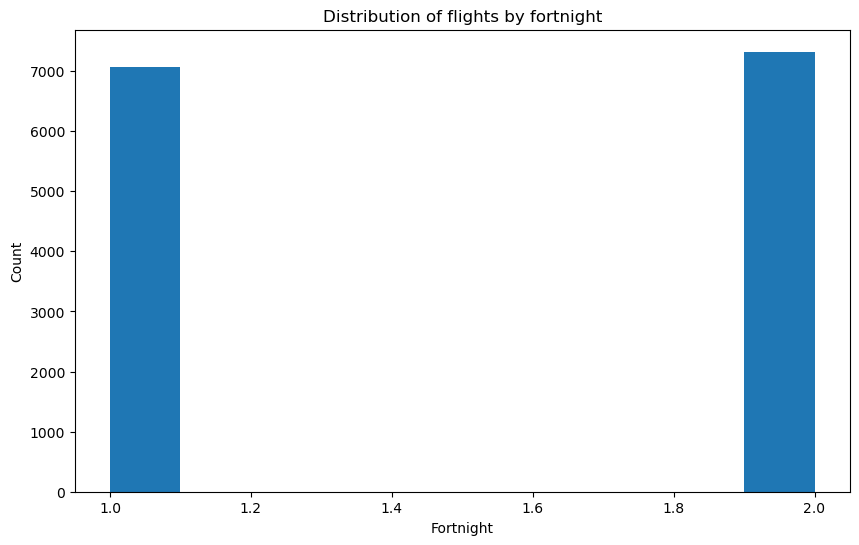

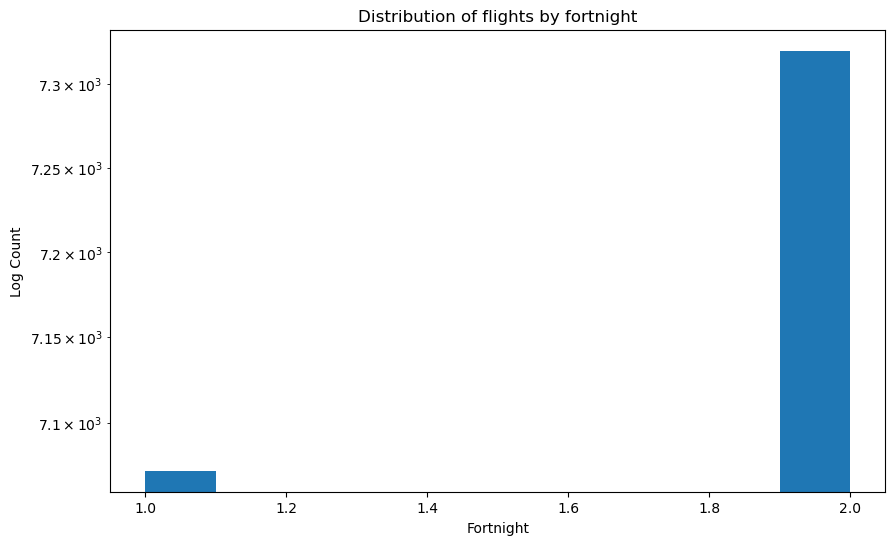

In [60]:
plot_histogram_of_column(X_train["FORTNIGHT"], "Distribution of flights by fortnight", "Fortnight", None, False, False)
plot_histogram_of_column(X_train["FORTNIGHT"], "Distribution of flights by fortnight", "Fortnight", None, False, True)

In this case, the difference is minimal. However, if we apply the logarithm to the y axis we can see that the second forntingh accumulates more flights than the first one.

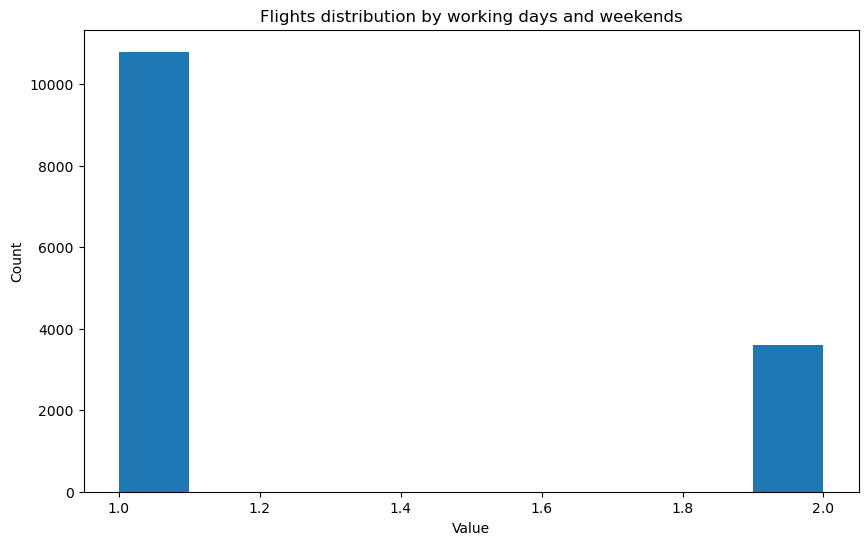

In [61]:
plot_histogram_of_column(X_train["WEEK_INFO"], "Flights distribution by working days and weekends", None, None, False, False)

As it could be expected, weekdays accumulate almost three times more flights than weekends. However, we must keep in mind that the weekday category groups five days while the weekend only groups two days. Probably, the difference wouldn't be this big if we were plotting the average number of flights per day. However, this escapes from the scope of this project as it doesn't provide any additional information that could be helpful to predict flight delays.

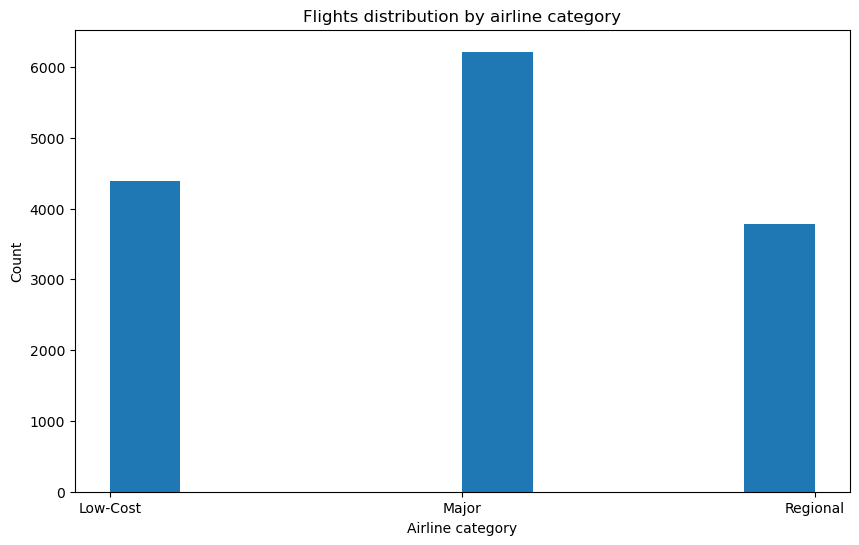

In [62]:
plot_histogram_of_column(X_train["AC"], "Flights distribution by airline category", "Airline category", None, False, False)

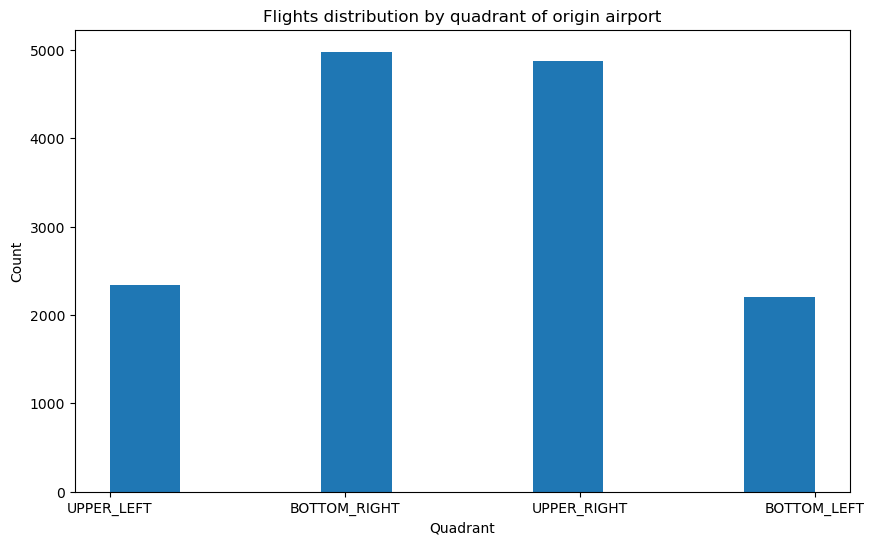

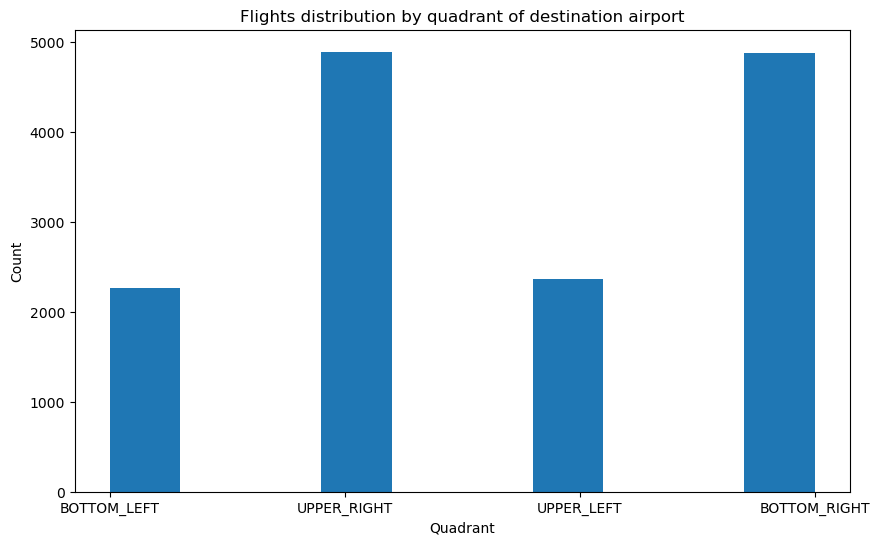

In [63]:
plot_histogram_of_column(X_train["GR_O"], "Flights distribution by quadrant of origin airport", "Quadrant", None, False,False)

plot_histogram_of_column(X_train["GR_D"], "Flights distribution by quadrant of destination airport", "Quadrant", None, False,False)

In both cases, the quadrants with the greater amount of flights are *UPPER_RIGHT* and *BOTTOM_RIGT*. This represents the east cost of the USA, where many of the biggest cities are located.

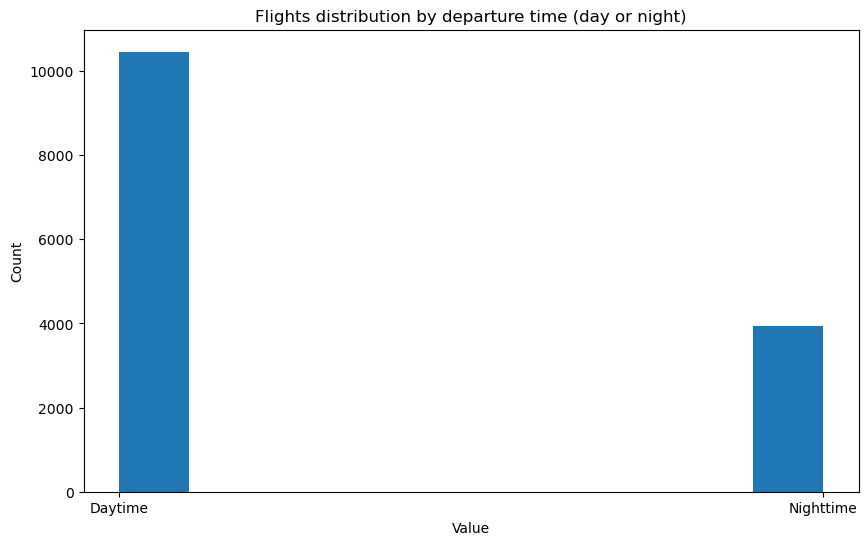

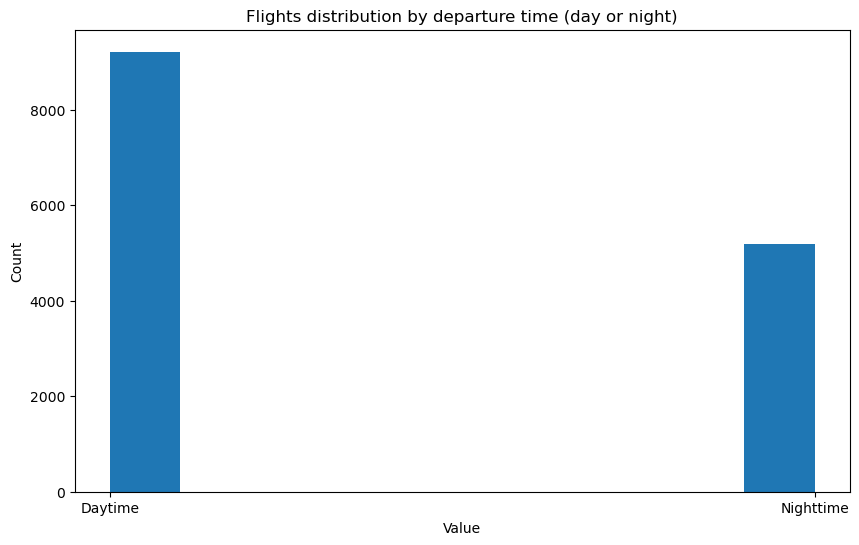

In [64]:
plot_histogram_of_column(X_train["DepartureDayNight"], "Flights distribution by departure time (day or night)", None, None, False, False)

plot_histogram_of_column(X_train["ArrivalDayNight"], "Flights distribution by departure time (day or night)", None, None, False, False)

Logically, most of the flights departure during daytime and this trend seems to hold for the arrival time. However, if we compare both histograms we will see that the amount of flights departing during daytime is considerably greater than the flights arriving during daytime. This mean that a considerable amount of flights arrive at their destination at night time even though day departed at daytime.

## Gausianization of continuous variables

Since the models we will apply assume that our data is distributed following a gaussian distribution, we need to make sure that our data is gaussian.

In [65]:
X_train.columns

Index(['DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'DISTANCE', 'Q_YEAR',
       'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O', 'GR_D', 'ArrivalDayNight',
       'DepartureDayNight'],
      dtype='object')

First of all, we are going to determine which columns of our dataset are the ones containing continuous data

array([[<AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>],
       [<AxesSubplot: title={'center': 'SCHEDULED_TIME'}>,
        <AxesSubplot: title={'center': 'DISTANCE'}>]], dtype=object)

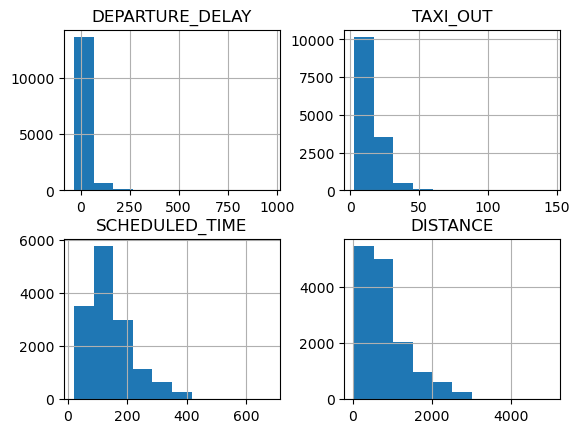

In [66]:
# Declare which variables are categorical and which ones are continuous. 
continuous = ['DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME',
       'DISTANCE']
X_train[continuous].hist()               

We see that our data doesn't follow a gaussian distribution. Before gaussianizing it, we will first remove any outliers that can be identified in the dataset.

In [67]:
non_transformed_X_train = X_train.copy()
non_transformed_X_test = X_test.copy()
non_transformed_test_data = test_data.copy()

In [68]:
Q1 = X_train[continuous].quantile(0.25)
Q3 = X_train[continuous].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds using Tukey's fences
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Identify outlier rows in X_train
outliers = ((X_train[continuous] < lower_bound) | (X_train[continuous] > upper_bound)).any(axis=1)
outliers_test = ((test_data[continuous] < lower_bound) | (test_data[continuous] > upper_bound)).any(axis=1)


# Remove outlier rows from X_train and corresponding labels from y_train
X_train = X_train[~outliers]
y_train = y_train[~outliers]

test_data = test_data[~outliers_test]

print(len(X_train))
removed = 0

for row in outliers:
    if row:
        removed += 1
print(removed)


13088
1304


We observe that we remove some outliers. 
We proceed to gausianize our data. 

In [69]:
# we normalize continuous variables
from sklearn.preprocessing import QuantileTransformer

# Initialize transformer with number of quantiles and output distribution (not stochastic)
transformer = QuantileTransformer(n_quantiles=100, output_distribution='normal')

# Apply transformation to continuous columns
for col in continuous:
    flights[col] = transformer.fit_transform(flights[col].values.reshape(-1, 1))
    X_train[col] = transformer.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = transformer.fit_transform(X_test[col].values.reshape(-1, 1))
    test_data[col] = transformer.fit_transform(test_data[col].values.reshape(-1, 1))

And we plot the normalized data, which now clearly follow a gaussian distribution.

array([[<AxesSubplot: title={'center': 'DEPARTURE_DELAY'}>,
        <AxesSubplot: title={'center': 'TAXI_OUT'}>],
       [<AxesSubplot: title={'center': 'SCHEDULED_TIME'}>,
        <AxesSubplot: title={'center': 'DISTANCE'}>]], dtype=object)

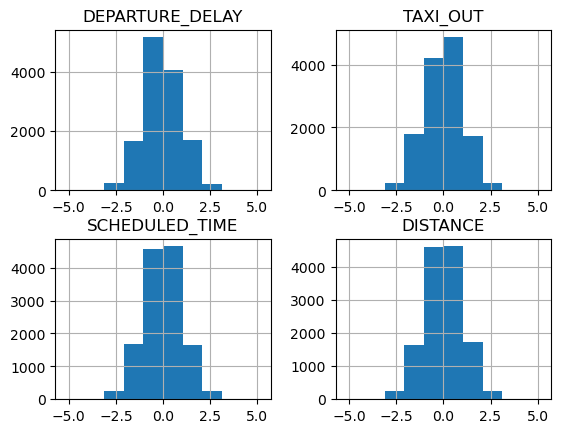

In [70]:
X_train[continuous].hist()

## One hot encoding of categorical variables

After dealing with the continuous variables, we will apply hot encoding to our categorical variables, which are:
- Q_year
- Fortnight
- Week_info
- Ac
- Gr_o
- Gr_d
- ArrivalDayNight
- DepartureDayNight

In [71]:
# one hot encoding for categorical variables
categorical = ['Q_YEAR', 'FORTNIGHT', 'WEEK_INFO', 'AC', 'GR_O','GR_D', 'ArrivalDayNight', 'DepartureDayNight']

flights= pd.get_dummies(flights, columns=categorical)
X_train = pd.get_dummies(X_train, columns = categorical)
X_test = pd.get_dummies(X_test, columns = categorical)
test_data = pd.get_dummies(test_data, columns = categorical)

In [72]:
non_transformed_X_train = pd.get_dummies(non_transformed_X_train, columns = categorical)
non_transformed_X_test = pd.get_dummies(non_transformed_X_test, columns = categorical)

## Relations between pair of variables
From a pairplot diagram, we can infer several things:

- Correlation: The scatterplots in the pairplot diagram give us an idea of the relationship between variables. If the points in a scatterplot are closely clustered around a line or a curve, it suggests a strong correlation between those variables. 

- Distributions: The histograms on the diagonal of the pairplot diagram show the distribution of each variable individually. 

- Outliers: Outliers are data points that significantly deviate from the overall pattern in the scatterplots. 

Moreover, we believe is worth mentioning that we have included this graph just after normalizing our continuous variables since it improves drastically the colclusions that can be extracted from it because the pairplots obtained with the raw data where strongly influenced by some large values and it's analisis was quite difficult.

In [ ]:
pairplot_variables = ['DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME',
       'DISTANCE', 'DELAYED']

X_train['DELAYED'] = y_train

sns.pairplot(data=X_train[pairplot_variables][:1000], hue='DELAYED')

X_train = X_train.drop('DELAYED', axis=1)

The results of this plot will be commented in the final report.

### Feature selection (consider a subset of variables)
Nextly we will check if getting a smaller subset of variables can help getting better results: 

In [74]:
feature_selector = SelectFromModel(RandomForestClassifier(random_state=42), threshold='mean')
feature_selector.fit(X_train, y_train)
X_train_selected = feature_selector.transform(X_train)
X_test_selected = feature_selector.transform(X_test)# Get the selected feature indices
selected_feature_indices = feature_selector.get_support(indices=True)
# Get the original feature names for the selected features
selected_feature_names = X.columns[selected_feature_indices]
print("Selected Features:")
print(selected_feature_names)

Selected Features:
Index(['DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'DISTANCE'], dtype='object')


Consider the two feature subsets during all the modelling

In [75]:
X_train_sf = X_train[selected_feature_names]
X_test_sf = X_test[selected_feature_names]
test_data_sf = test_data[selected_feature_names]

We firstly take a look at the difference in columns between both feature subsets:

In [76]:
X_train.columns

Index(['DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'DISTANCE', 'Q_YEAR_1',
       'Q_YEAR_2', 'Q_YEAR_3', 'FORTNIGHT_1', 'FORTNIGHT_2', 'WEEK_INFO_1',
       'WEEK_INFO_2', 'AC_Low-Cost', 'AC_Major', 'AC_Regional',
       'GR_O_BOTTOM_LEFT', 'GR_O_BOTTOM_RIGHT', 'GR_O_UPPER_LEFT',
       'GR_O_UPPER_RIGHT', 'GR_D_BOTTOM_LEFT', 'GR_D_BOTTOM_RIGHT',
       'GR_D_UPPER_LEFT', 'GR_D_UPPER_RIGHT', 'ArrivalDayNight_Daytime',
       'ArrivalDayNight_Nighttime', 'DepartureDayNight_Daytime',
       'DepartureDayNight_Nighttime'],
      dtype='object')

In [77]:
X_train_sf.columns

Index(['DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'DISTANCE'], dtype='object')

## Metric for choosing models

To start with, we are going to decide which of the metrics to use in order to compare our models and decide which of them is the best. We firstly observe the balance between classes

In [78]:
# In order to count how many delayed and on-time flights we have in the dataset
class_counts = y.value_counts()
class_balance = class_counts / len(y) * 100

print("Class Balance:")
print(class_balance)


Class Balance:
0    81.239578
1    18.760422
Name: DELAYED, dtype: float64


With class 0 (i.e. on-time flights) at 80.28% and class 1 (i.e. delayed flights) at 19.72%, there is a noticeable difference in class frequencies.

When dealing with unbalanced data, it is important to be aware that standard evaluation metrics like accuracy may not provide an accurate representation of model performance. Instead, we need to focus on metrics that are more robust to class unbalance, such as precision, recall, F1 score, or area under the ROC curve (AUC-ROC).

Therefore we will mainly use the F1 score to decide whether which models are better.


## 2. Modeling

![Alt Text](process2.png)

To start with we quickly remind of some of the options we have to optimize the learning of our models and that we will (more or less) take into account when modelling. 

**Hyperparameter Tuning**: Fine-tune the hyperparameters of the model to find the optimal combination for our specific problem. We are going to use techniques like grid search, random search, or Bayesian optimization to systematically explore the hyperparameter space and identify the best configuration.

**Cross-Validation**: We will use cross-validation techniques, such as k-fold cross-validation, to evaluate our model's performance more reliably. This helps to assess how well our model generalizes to unseen data and reduces the risk of overfitting.

**Ensemble Methods**: Explore ensemble methods like bagging, boosting, or stacking to combine multiple models and improve overall performance. Ensemble techniques can help capture different patterns in the data and reduce model variance.

**Data Augmentation**: Since we have a lot of rows in our dataset, we will try with a small subset of this dataset and in the case this is not enough, we are going to proceed with picking a bigger subset of rows so that our model is able to sufficiently learn.

**Model Architecture**: Experiment with different model architectures or network architectures, such as adding or removing layers, adjusting layer sizes, or trying different activation functions.

**Monitoring and Debugging**: Monitor your model during training, track performance metrics, and analyze learning curves to identify issues like underfitting, overfitting, or convergence problems. Debug any potential errors, explore misclassified samples, and consider adjusting your model or data accordingly.



**In the following dataframe we are going to store the metrics for all of the models that we are going to fit in order to compare them. We are going to score metrics for every kind of model fitted with both subset of features and before and after HyperParameter tuning (HT).**

In [79]:
results_df = pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

In [80]:
def plot_learning_curve(estimator, title, X, y, cv=None):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    #(not used shuffle = False since trends of the graph are the same and more realistic)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    # Plot learning curve
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#FF7F0F", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#2278B5", label="Cross-validation score")
    plt.legend(loc="best")

    return plt

The procedure we are going to follow for each model is the same. 

1. We are going to introduce the hyperparameters we are going to tune.
2. Fit the model with both X_train and X_train_sf(subset of features obtained by feature selection).
3. Perform hyperparameter tuning.
4. Fit both models trained with both feature subsets considering the best hyperparameters we've found during their tuning. 
5. Show learning curve to infer information regarding overfitting-underfitting data quality etc. 

**At the end of modelling we will get the best models we've got and we will try to upgrade them: **

### Logistic Regression 

First we comment the hyperparameters we are going to tune: 

**C** :The C parameter in logistic regression controls the inverse of the regularization strength. It determines the trade-off between fitting the training data and preventing overfitting. Higher values of C result in less regularization, allowing the model to fit the training data more closely.

**penalty:** The penalty parameter specifies the type of regularization used in logistic regression.
'l1' penalty corresponds to L1 regularization. It adds a penalty term proportional to the absolute value of the coefficients, promoting sparsity by encouraging some coefficients to become exactly zero.

**solver:** The solver parameter determines the algorithm used to solve the optimization problem in logistic regression.
'saga' solver is an extension of the Stochastic Average Gradient (SAG) solver. It supports both L1 and L2 regularization and is suitable for large datasets.

We firstly fit the models for both subset of features: 

In [81]:
# We create the Logistic Regression model
logreg = LogisticRegression()

# Cross validation
cv_results_logreg_1 = cross_validate(logreg, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Logistic Regression all features Before HT',:] = [cv_results_logreg_1['test_accuracy'].mean(), cv_results_logreg_1['test_f1_macro'].mean(),cv_results_logreg_1['test_precision_macro'].mean() , cv_results_logreg_1['test_recall_macro'].mean()]

In [82]:
# We create the Logistic Regression model
logreg_sf = LogisticRegression()

# Cross-validation
cv_results_logreg_2 = cross_validate(logreg_sf, X_train_sf, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Logistic Regression subset features Before HT',:] = [cv_results_logreg_2['test_accuracy'].mean(), cv_results_logreg_2['test_f1_macro'].mean(),cv_results_logreg_2['test_precision_macro'].mean() , cv_results_logreg_2['test_recall_macro'].mean()]

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

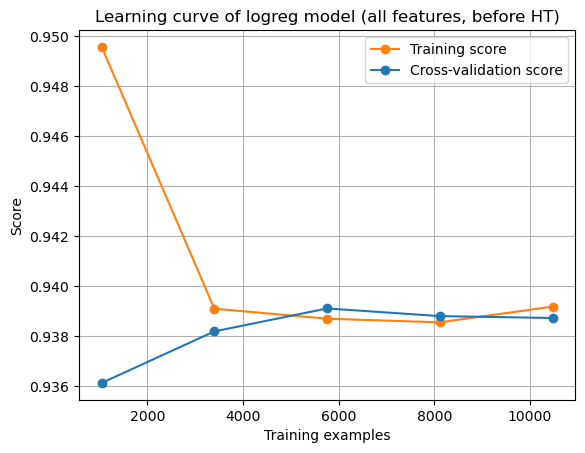

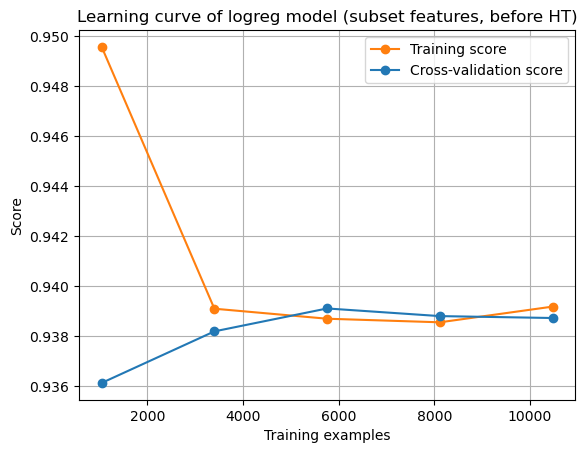

In [83]:
plot_learning_curve(logreg, 'Learning curve of logreg model (all features, before HT)', X_train, y_train)
plot_learning_curve(logreg_sf, 'Learning curve of logreg model (subset features, before HT)', X_train, y_train)

Do hyperparameter tuning with the small subset of features: 

In [84]:
# We create the Logistic Regression model
logreg = LogisticRegression()

# Define the hyperparameter grid
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.001, 0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
              }


grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_score = grid_search.best_score_


/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: Con

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: Con

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 500.
The score 

In [85]:
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 0.001, 'penalty': 'none', 'solver': 'newton-cg'}


In [86]:
# We create the Logistic Regression model using the tuned hyperparameters
logreg = LogisticRegression(C=0.001, penalty='none', solver = 'newton-cg')

cv_results_logreg_ht_1 = cross_validate(logreg, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Logistic Regression all features after HT',:] = [cv_results_logreg_ht_1['test_accuracy'].mean(), cv_results_logreg_ht_1['test_f1_macro'].mean(),cv_results_logreg_ht_1['test_precision_macro'].mean() , cv_results_logreg_ht_1['test_recall_macro'].mean()]

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

In [87]:
# We create the Logistic Regression model using the tuned hyperparameters
logreg_sf = LogisticRegression(C=0.001, penalty='none', solver = 'newton-cg')

cv_results_logreg_ht_2 = cross_validate(logreg, X_train_sf, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Logistic Regression subset features after HT',:] = [cv_results_logreg_ht_2['test_accuracy'].mean(), cv_results_logreg_ht_2['test_f1_macro'].mean(),cv_results_logreg_ht_2['test_precision_macro'].mean() , cv_results_logreg_ht_2['test_recall_macro'].mean()]
results_df

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

Accuracy  F1 Macro  \
Logistic Regression all features Before HT     0.938722  0.816842   
Logistic Regression subset features Before HT  0.939563  0.819557   
Logistic Regression all features after HT      0.939105  0.818576   
Logistic Regression subset features after HT   0.939792  0.820572   

                                              Precision Macro Recall Macro  
Logistic Regression all features Before HT           0.893142     0.770395  
Logistic Regression subset features Before HT        0.895687     0.772974  
Logistic Regression all features after HT            0.893109      0.77272  
Logistic Regression subset features after HT         0.895796     0.774308

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

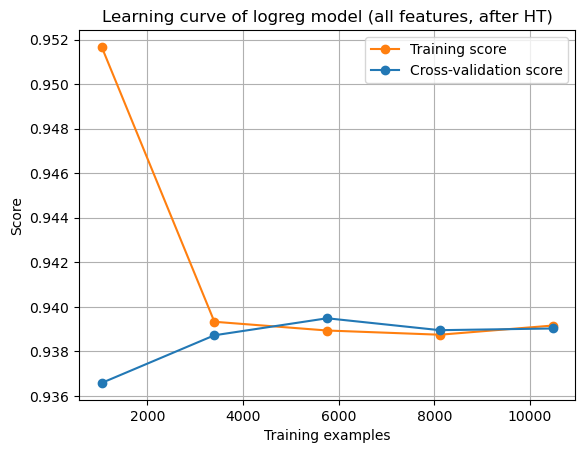

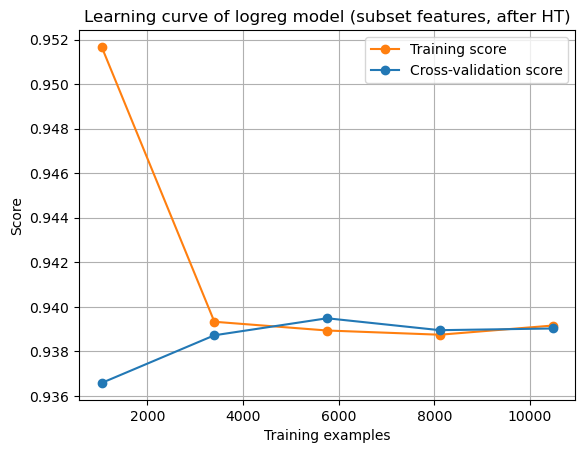

In [88]:
plot_learning_curve(logreg, 'Learning curve of logreg model (all features, after HT)', X_train, y_train)
plot_learning_curve(logreg_sf, 'Learning curve of logreg model (subset features, after HT)', X_train, y_train)

We fit the best of the models that turns to be the logistic regression of all features after HT and observe the sparsity of the coefficients to consider possible modifications on the subset of features: 

In [89]:
from sklearn.linear_model import LogisticRegression

logreg.fit(X_train, y_train)

X_train_copy = X_train

coefficients = logreg.coef_[0]

mask = np.abs(coefficients) < 0.01

while np.sum(mask) > 0:
    feature_indices_to_eliminate = np.where(mask)[0]

    X_train_copy = X_train_copy.drop(X_train_copy.columns[feature_indices_to_eliminate], axis=1)

    logreg.fit(X_train_copy, y_train)

    coefficients = logreg.coef_[0]

    mask = np.abs(coefficients) < 0.01

# Print the final selected features
other_selected_features = X_train_copy.columns
print("Selected Features:", other_selected_features)

logreg.fit(X_train_copy, y_train)
f_coefficients = logreg.coef_
print(f_coefficients)

Selected Features: Index(['DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'DISTANCE', 'Q_YEAR_1',
       'Q_YEAR_2', 'Q_YEAR_3', 'FORTNIGHT_1', 'FORTNIGHT_2', 'WEEK_INFO_1',
       'WEEK_INFO_2', 'AC_Low-Cost', 'AC_Major', 'AC_Regional',
       'GR_O_BOTTOM_LEFT', 'GR_O_BOTTOM_RIGHT', 'GR_O_UPPER_LEFT',
       'GR_O_UPPER_RIGHT', 'GR_D_BOTTOM_LEFT', 'GR_D_BOTTOM_RIGHT',
       'GR_D_UPPER_LEFT', 'GR_D_UPPER_RIGHT', 'ArrivalDayNight_Daytime',
       'ArrivalDayNight_Nighttime', 'DepartureDayNight_Daytime',
       'DepartureDayNight_Nighttime'],
      dtype='object')
[[ 2.65738722  0.89295174 -1.66144008  1.43935052 -0.19294484 -0.3962034
  -0.39222969 -0.46235772 -0.51902021 -0.43212156 -0.54925637 -0.18135274
  -0.60701654 -0.19300865 -0.17845116 -0.20263971 -0.33880769 -0.26147937
  -0.14969466 -0.20261241 -0.34018595 -0.28888492 -0.50860823 -0.4727697
  -0.4625453  -0.51883263]]


/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


We now consider this third model using this new subset of features that we found in between and observe if it works out better. 


In [90]:
logreg = LogisticRegression()

# Define the hyperparameter grid
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.001, 0.01, 0.1, 1, 10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
              }

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_copy, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_


/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: Con

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:117

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 500.
The score 

In [91]:
print(best_params)

{'C': 0.001, 'penalty': 'none', 'solver': 'newton-cg'}


In [176]:
logreg_copy = LogisticRegression(C=0.001, penalty='none', solver = 'newton-cg')

cv_results_logreg_ht_2 = cross_validate(logreg_copy, X_train_copy, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Logistic Regression subset 2 features after HT',:] = [cv_results_logreg_ht_2['test_accuracy'].mean(), cv_results_logreg_ht_2['test_f1_macro'].mean(),cv_results_logreg_ht_2['test_precision_macro'].mean() , cv_results_logreg_ht_2['test_recall_macro'].mean()]
results_df


/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

Accuracy  F1 Macro  \
Logistic Regression all features Before HT        0.938722  0.816842   
Logistic Regression subset features Before HT     0.939563  0.819557   
Logistic Regression all features after HT         0.939105  0.818576   
Logistic Regression subset features after HT      0.939792  0.820572   
Logistic Regression subset 2 features after HT    0.939105  0.818576   
k-NN all features before HT                       0.907778  0.631787   
k-NN subset features before HT                    0.937271  0.810123   
k-NN subset features after HT                     0.939258  0.824505   
SVC all features Before HT                        0.938569   0.81475   
SVC subset features Before HT                     0.941626  0.824517   
SVC all features After HT                         0.939563  0.814563   
SVC subset features after HT                      0.942161   0.82625   
Gaussian Naive Bayes all features Before HT       0.913814  0.744454   
Gaussian Naive Bayes subset features Before HT    0.925275  0.741975   
Gaussian Naive Bayes subset 2 features Before HT  0.913814  0.744454   
Gaussian Naive Bayes all features After HT        0.913814  0.744454   
Gaussian Naive Bayes subset features After HT     0.925275  0.741975   
LDA all features Before HT                        0.934673  0.789318   
LDA subset features Before HT                     0.934749  0.785908   
LDA all features After HT                         0.934673  0.789318   
LDA subset features After HT                      0.934749  0.785908   
Perceptron all features Before HT                 0.869048  0.699069   
Perceptron subset features Before HT              0.912589  0.764872   
Perceptron all features After HT                  0.908773  0.736786   
Perceptron subset features After HT               0.907168   0.76358   
Gradient Boost all features Before HT             0.940785  0.834955   
Gradient Boost subset features Before HT          0.940021  0.832548   
Gradient Boost all features After HT              0.939028  0.831995   
Gradient Boost subset features After HT           0.937347  0.825782   
Random Forest all features Before HT              0.937882  0.818616   
Random Forest subset features Before HT           0.938035  0.827166   
Random Forest all features After HT               0.937958  0.819838   
Random Forest subset features After HT            0.937882    0.8284   
Neural Network subset features before HT          0.941702  0.834729   
Neural Network all features before HT              0.93941  0.829158   

                                                 Precision Macro Recall Macro  
Logistic Regression all features Before HT              0.893142     0.770395  
Logistic Regression subset features Before HT           0.895687     0.772974  
Logistic Regression all features after HT               0.893109      0.77272  
Logistic Regression subset features after HT            0.895796     0.774308  
Logistic Regression subset 2 features after HT          0.893109      0.77272  
k-NN all features before HT                             0.902892     0.593987  
k-NN subset features before HT                          0.892628     0.762057  
k-NN subset features after HT                           0.881442     0.786363  
SVC all features Before HT                              0.896068     0.766691  
SVC subset features Before HT                           0.906667     0.775643  
SVC all features After HT                                0.90785     0.762438  
SVC subset features after HT                            0.908359     0.777149  
Gaussian Naive Bayes all features Before HT              0.80062     0.710312  
Gaussian Naive Bayes subset features Before HT          0.909987     0.683037  
Gaussian Naive Bayes subset 2 features Before HT         0.80062     0.710312  
Gaussian Naive Bayes all features After HT               0.80062     0.710312  
Gaussian Naive Bayes subset features After HT           0.909987     0.683037  
LDA all features 

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

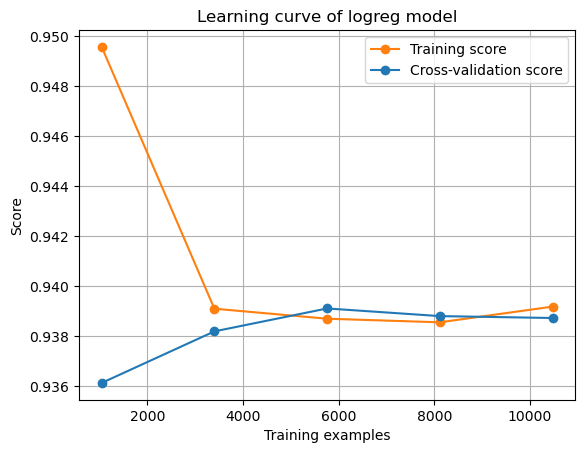

In [177]:
plot_learning_curve(logreg, 'Learning curve of logreg model', X_train, y_train)

Since we observe that this third subset of variables using the sparsity is not better, we will only consider it at the end with the final model. However it is a good practice to use this subset of features in between X_train (more features than X_train_copy) and X_train_sf(less features than X_train_copy)

## K-Nearest Neighbours

Hyperparameters: 

**Number of neighbors (k):** The most crucial hyperparameter in KNN is the number of neighbors to consider when making predictions. A higher value of k can smooth out the decision boundaries but may lead to oversmoothing, while a lower value can make the classifier more sensitive to noisy data. 

**Distance metric:** KNN classifiers can use different distance metrics to measure the similarity between data points, such as Euclidean distance, Manhattan distance, or Minkowski distance. 

**Weights:** KNN classifiers can assign weights to neighboring data points when making predictions. By default, all neighbors have equal weights. 

In [94]:
knn_classifier = KNeighborsClassifier(n_neighbors=10)
cross_val_results = pd.DataFrame(cross_validate(knn_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['k-NN all features before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

Accuracy  F1 Macro  \
Logistic Regression all features Before HT      0.938722  0.816842   
Logistic Regression subset features Before HT   0.939563  0.819557   
Logistic Regression all features after HT       0.939105  0.818576   
Logistic Regression subset features after HT    0.939792  0.820572   
Logistic Regression subset 2 features after HT  0.938646  0.816822   
k-NN all features before HT                     0.907778  0.631787   

                                               Precision Macro Recall Macro  
Logistic Regression all features Before HT            0.893142     0.770395  
Logistic Regression subset features Before HT         0.895687     0.772974  
Logistic Regression all features after HT             0.893109      0.77272  
Logistic Regression subset features after HT          0.895796     0.774308  
Logistic Regression subset 2 features after HT        0.892422     0.770654  
k-NN all features before HT                           0.902892     0.593987

In [95]:
knn_classifier_sf = KNeighborsClassifier(n_neighbors=10)
cross_val_results = pd.DataFrame(cross_validate(knn_classifier_sf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['k-NN subset features before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

Accuracy  F1 Macro  \
Logistic Regression all features Before HT      0.938722  0.816842   
Logistic Regression subset features Before HT   0.939563  0.819557   
Logistic Regression all features after HT       0.939105  0.818576   
Logistic Regression subset features after HT    0.939792  0.820572   
Logistic Regression subset 2 features after HT  0.938646  0.816822   
k-NN all features before HT                     0.907778  0.631787   
k-NN subset features before HT                  0.937271  0.810123   

                                               Precision Macro Recall Macro  
Logistic Regression all features Before HT            0.893142     0.770395  
Logistic Regression subset features Before HT         0.895687     0.772974  
Logistic Regression all features after HT             0.893109      0.77272  
Logistic Regression subset features after HT          0.895796     0.774308  
Logistic Regression subset 2 features after HT        0.892422     0.770654  
k-NN all features before HT                           0.902892     0.593987  
k-NN subset features before HT                        0.892628     0.762057

Since the subset of features is far better, we only tune hyperparameters for the subset of features dataset: 

In [96]:
knn_classifier = KNeighborsClassifier()
param_grid = {
    'n_neighbors': list(range(1, 50)),  # Number of neighbors (k)
    'weights': ['uniform'],  # Weights
    'metric': ['euclidean']  # Distance metric
}

grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_sf, y_train)

# Print of the best combination found
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Best F1 Score: 0.9392575079846092


In [97]:
knn_classifier_sf = KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights='uniform')
cross_val_results = pd.DataFrame(cross_validate(knn_classifier_sf, X_train_sf, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']))
results_df.loc['k-NN subset features after HT', :] = cross_val_results[['test_accuracy', 'test_f1_macro', 'test_precision_macro', 'test_recall_macro']].mean().values
results_df


Accuracy  F1 Macro  \
Logistic Regression all features Before HT      0.938722  0.816842   
Logistic Regression subset features Before HT   0.939563  0.819557   
Logistic Regression all features after HT       0.939105  0.818576   
Logistic Regression subset features after HT    0.939792  0.820572   
Logistic Regression subset 2 features after HT  0.938646  0.816822   
k-NN all features before HT                     0.907778  0.631787   
k-NN subset features before HT                  0.937271  0.810123   
k-NN subset features after HT                   0.939258  0.824505   

                                               Precision Macro Recall Macro  
Logistic Regression all features Before HT            0.893142     0.770395  
Logistic Regression subset features Before HT         0.895687     0.772974  
Logistic Regression all features after HT             0.893109      0.77272  
Logistic Regression subset features after HT          0.895796     0.774308  
Logistic Regression subset 2 features after HT        0.892422     0.770654  
k-NN all features before HT                           0.902892     0.593987  
k-NN subset features before HT                        0.892628     0.762057  
k-NN subset features after HT                         0.881442     0.786363

### Support Vector Machine (SVC)
First of all we recall the hyperparameters we are going to tune (which are the more relevant: https://medium.com/grabngoinfo/support-vector-machine-svm-hyperparameter-tuning-in-python-a65586289bcb):

- **C:** Regularization parameter. It controls the trade-off between allowing training errors and maximizing the margin. Larger values of C penalize errors more, leading to a potentially narrower margin.

- **kernel:** Specifies the type of kernel function used for mapping the input data to a higher-dimensional feature space. Common options include linear, polynomial, radial basis function (RBF), and sigmoid.

- **gamma:** Kernel coefficient for 'rbf', 'poly', and 'sigmoid' kernels. It defines the influence of training samples on the decision boundary.

We fit the SVC using the whole subset of features: 

In [98]:
# Model initialization
clf = SVC()

# Model fitting using all features
cross_val_results = pd.DataFrame(cross_validate(clf , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Update the results dataframe
results_df.loc['SVC all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

Now only using the best features: 

In [99]:
# Model initialization
clf_sf = SVC()

# Model fitting using a subset of values
cross_val_results = pd.DataFrame(cross_validate(clf_sf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Update the results dataframe
results_df.loc['SVC subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

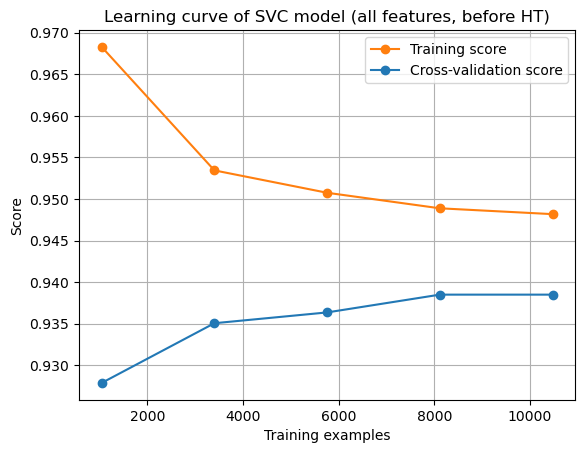

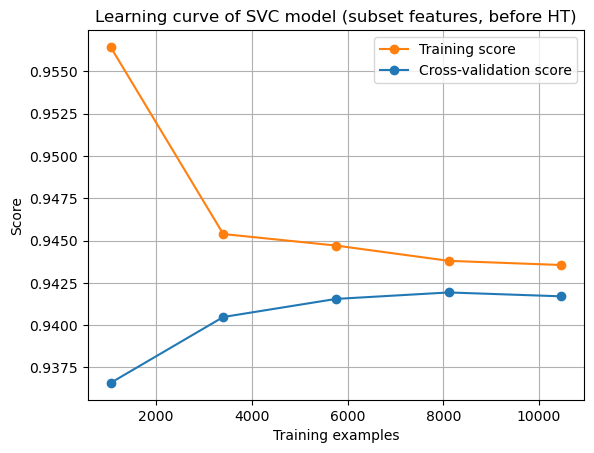

In [100]:
plot_learning_curve(clf, 'Learning curve of SVC model (all features, before HT)', X_train, y_train)
plot_learning_curve(clf_sf, 'Learning curve of SVC model (subset features, before HT)', X_train_sf, y_train)

Since we have very similar results, let us compute the hyperparameter tuning with the SVC using only the small part of data. 

In [101]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

# Model initialization
clf = SVC()

# Grid Search for hyperparameter tuning
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_sf, y_train)

# Print of the best combination found
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best F1 Score: 0.8268777563767642


We now fit SVC using the hyperparameters that we found and using both datasets:

In [178]:
# Model initialization using optimal hyperparameters
clf = SVC(kernel='rbf', gamma = 'scale', C=10)

# Model fitting with all features
cross_val_results = pd.DataFrame(cross_validate(clf , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Update the results dataset
results_df.loc['SVC all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

In [179]:
# Model initialization using optimal hyperparameters
clf_sf = SVC(kernel='rbf', gamma = 'scale', C=10)

# Model fitting using subset of features
cross_val_results = pd.DataFrame(cross_validate(clf_sf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Update the results dataset
results_df.loc['SVC subset features after HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

Accuracy  F1 Macro  \
Logistic Regression all features Before HT        0.938722  0.816842   
Logistic Regression subset features Before HT     0.939563  0.819557   
Logistic Regression all features after HT         0.939105  0.818576   
Logistic Regression subset features after HT      0.939792  0.820572   
Logistic Regression subset 2 features after HT    0.939105  0.818576   
k-NN all features before HT                       0.907778  0.631787   
k-NN subset features before HT                    0.937271  0.810123   
k-NN subset features after HT                     0.939258  0.824505   
SVC all features Before HT                        0.938569   0.81475   
SVC subset features Before HT                     0.941626  0.824517   
SVC all features After HT                          0.93559  0.815393   
SVC subset features after HT                      0.941855  0.826878   
Gaussian Naive Bayes all features Before HT       0.913814  0.744454   
Gaussian Naive Bayes subset features Before HT    0.925275  0.741975   
Gaussian Naive Bayes subset 2 features Before HT  0.913814  0.744454   
Gaussian Naive Bayes all features After HT        0.913814  0.744454   
Gaussian Naive Bayes subset features After HT     0.925275  0.741975   
LDA all features Before HT                        0.934673  0.789318   
LDA subset features Before HT                     0.934749  0.785908   
LDA all features After HT                         0.934673  0.789318   
LDA subset features After HT                      0.934749  0.785908   
Perceptron all features Before HT                 0.869048  0.699069   
Perceptron subset features Before HT              0.912589  0.764872   
Perceptron all features After HT                  0.908773  0.736786   
Perceptron subset features After HT               0.907168   0.76358   
Gradient Boost all features Before HT             0.940785  0.834955   
Gradient Boost subset features Before HT          0.940021  0.832548   
Gradient Boost all features After HT              0.939028  0.831995   
Gradient Boost subset features After HT           0.937347  0.825782   
Random Forest all features Before HT              0.937882  0.818616   
Random Forest subset features Before HT           0.938035  0.827166   
Random Forest all features After HT               0.937958  0.819838   
Random Forest subset features After HT            0.937882    0.8284   
Neural Network subset features before HT          0.941702  0.834729   
Neural Network all features before HT              0.93941  0.829158   

                                                 Precision Macro Recall Macro  
Logistic Regression all features Before HT              0.893142     0.770395  
Logistic Regression subset features Before HT           0.895687     0.772974  
Logistic Regression all features after HT               0.893109      0.77272  
Logistic Regression subset features after HT            0.895796     0.774308  
Logistic Regression subset 2 features after HT          0.893109      0.77272  
k-NN all features before HT                             0.902892     0.593987  
k-NN subset features before HT                          0.892628     0.762057  
k-NN subset features after HT                           0.881442     0.786363  
SVC all features Before HT                              0.896068     0.766691  
SVC subset features Before HT                           0.906667     0.775643  
SVC all features After HT                               0.867183     0.779781  
SVC subset features after HT                            0.902585      0.78029  
Gaussian Naive Bayes all features Before HT              0.80062     0.710312  
Gaussian Naive Bayes subset features Before HT          0.909987     0.683037  
Gaussian Naive Bayes subset 2 features Before HT         0.80062     0.710312  
Gaussian Naive Bayes all features After HT               0.80062     0.710312  
Gaussian Naive Bayes subset features After HT           0.909987     0.683037  
LDA all features 

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

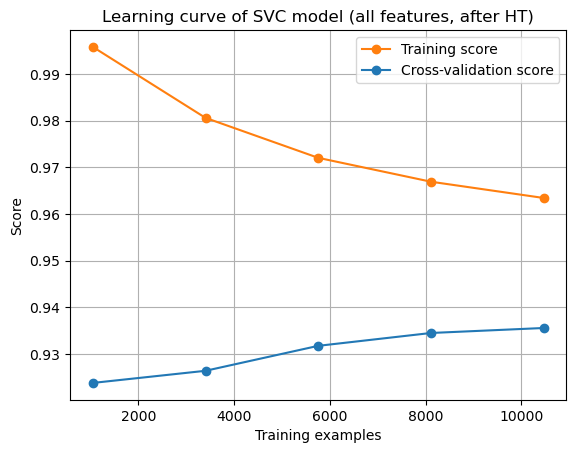

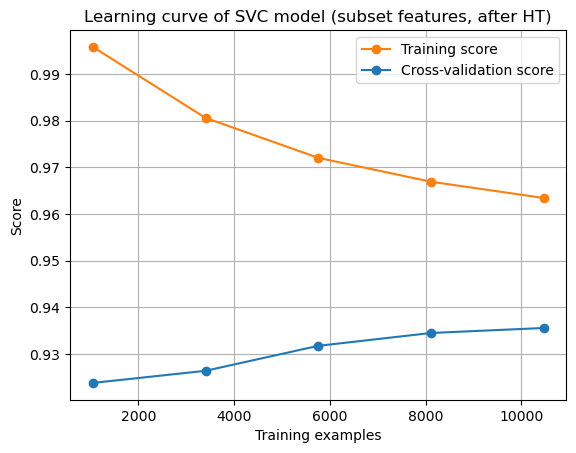

In [180]:
plot_learning_curve(clf, 'Learning curve of SVC model (all features, after HT)', X_train, y_train)
plot_learning_curve(clf_sf, 'Learning curve of SVC model (subset features, after HT)', X_train, y_train)

We are now observing that the subset of features is now doing better job than that of all the features surprisingly. The best combination is the last one we fitted.

### Naive Bayes
Naive Bayes has almost no hyperparameters to tune, so it usually generalizes well. One thing to note is that due to the feature independence assumption, the class probabilities output by naive Bayes can be pretty inaccurate.

The parameters for a  GaussianNB are the following: 
- **Var_smoothing:** Portion of the largest variance of all features that is added to variances for calculation stability.

To proceed, we are going to fit the Naive Bayes model for both subsets of the features: 

In [105]:
# Model initialization
naive = GaussianNB()

# We fit the model using all features
cross_val_results = pd.DataFrame(cross_validate(naive , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Update the results dataframe
results_df.loc['Gaussian Naive Bayes all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

In [106]:
# Initialize the model
naive_sf = GaussianNB()

#Model fitting using a subset of features
cross_val_results = pd.DataFrame(cross_validate(naive_sf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Add metrics to results dataset
results_df.loc['Gaussian Naive Bayes subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

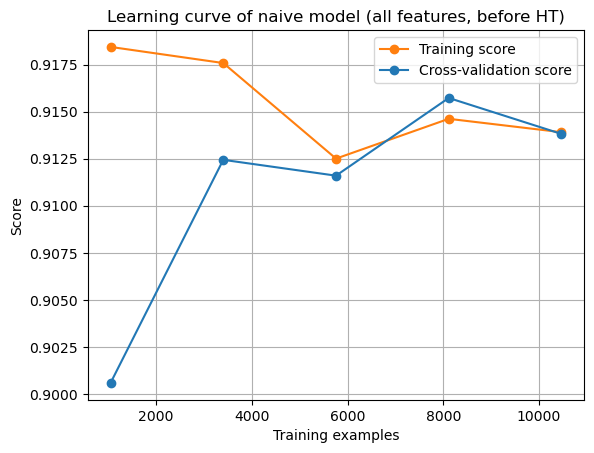

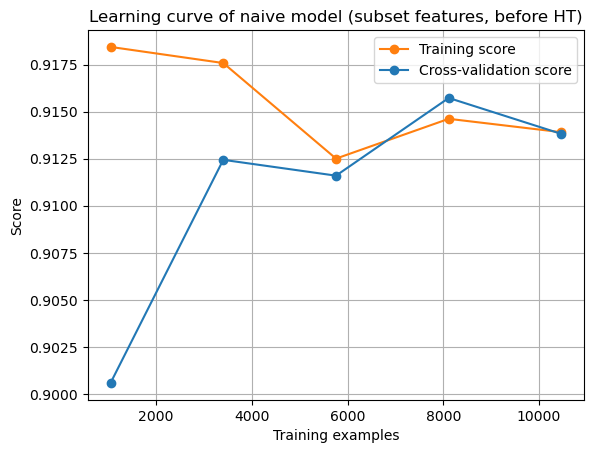

In [107]:
plot_learning_curve(naive, 'Learning curve of naive model (all features, before HT)', X_train, y_train)
plot_learning_curve(naive_sf, 'Learning curve of naive model (subset features, before HT)', X_train, y_train)

Since reducing features helps the model fit better we recall the other subset found from sparsity: 

In [108]:
naive = GaussianNB()
cross_val_results = pd.DataFrame(cross_validate(naive , X_train_copy, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))
results_df.loc['Gaussian Naive Bayes subset 2 features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

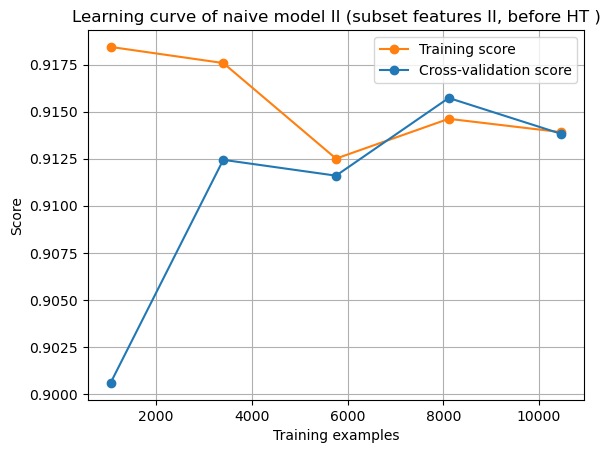

In [109]:
plot_learning_curve(naive, 'Learning curve of naive model II (subset features II, before HT )', X_train, y_train)


Since in this case it doesn not work any better we neglect this model. 

We now compute hyperparameter tuning using the smallest subset of features

In [110]:

pipeline = Pipeline([
    ('classifier', GaussianNB())
])

# Definition of the parameter grid
param_grid = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.25 ,0.3 , 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] 
}

# We perform grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train_sf, y_train)


print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Parameters:  {'classifier__var_smoothing': 0.001}
Best Score:  0.9252750643453964


We now fit the model using the best parameter we found: 

In [181]:
# Model initialization with optimal hyperparameters
naive = GaussianNB(var_smoothing = 0.001)

# Model fitting using all features
cross_val_results = pd.DataFrame(cross_validate(naive , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Add accuracy metrics to results dataset
results_df.loc['Gaussian Naive Bayes all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

In [183]:
# Model initialization with optimal hyperparameters
naive_sf = GaussianNB(var_smoothing = 0.001)

# We fit the model using a subset of features
cross_val_results = pd.DataFrame(cross_validate(naive_sf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Update the results dataframe
results_df.loc['Gaussian Naive Bayes subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

Accuracy  F1 Macro  \
Logistic Regression all features Before HT        0.938722  0.816842   
Logistic Regression subset features Before HT     0.939563  0.819557   
Logistic Regression all features after HT         0.939105  0.818576   
Logistic Regression subset features after HT      0.939792  0.820572   
Logistic Regression subset 2 features after HT    0.939105  0.818576   
k-NN all features before HT                       0.907778  0.631787   
k-NN subset features before HT                    0.937271  0.810123   
k-NN subset features after HT                     0.939258  0.824505   
SVC all features Before HT                        0.938569   0.81475   
SVC subset features Before HT                     0.941626  0.824517   
SVC all features After HT                          0.93559  0.815393   
SVC subset features after HT                      0.941855  0.826878   
Gaussian Naive Bayes all features Before HT       0.913814  0.744454   
Gaussian Naive Bayes subset features Before HT    0.925275  0.741975   
Gaussian Naive Bayes subset 2 features Before HT  0.913814  0.744454   
Gaussian Naive Bayes all features After HT        0.914044  0.744673   
Gaussian Naive Bayes subset features After HT     0.925275  0.741756   
LDA all features Before HT                        0.934673  0.789318   
LDA subset features Before HT                     0.934749  0.785908   
LDA all features After HT                         0.934673  0.789318   
LDA subset features After HT                      0.934749  0.785908   
Perceptron all features Before HT                 0.869048  0.699069   
Perceptron subset features Before HT              0.912589  0.764872   
Perceptron all features After HT                  0.908773  0.736786   
Perceptron subset features After HT               0.907168   0.76358   
Gradient Boost all features Before HT             0.940785  0.834955   
Gradient Boost subset features Before HT          0.940021  0.832548   
Gradient Boost all features After HT              0.939028  0.831995   
Gradient Boost subset features After HT           0.937347  0.825782   
Random Forest all features Before HT              0.937882  0.818616   
Random Forest subset features Before HT           0.938035  0.827166   
Random Forest all features After HT               0.937958  0.819838   
Random Forest subset features After HT            0.937882    0.8284   
Neural Network subset features before HT          0.941702  0.834729   
Neural Network all features before HT              0.93941  0.829158   

                                                 Precision Macro Recall Macro  
Logistic Regression all features Before HT              0.893142     0.770395  
Logistic Regression subset features Before HT           0.895687     0.772974  
Logistic Regression all features after HT               0.893109      0.77272  
Logistic Regression subset features after HT            0.895796     0.774308  
Logistic Regression subset 2 features after HT          0.893109      0.77272  
k-NN all features before HT                             0.902892     0.593987  
k-NN subset features before HT                          0.892628     0.762057  
k-NN subset features after HT                           0.881442     0.786363  
SVC all features Before HT                              0.896068     0.766691  
SVC subset features Before HT                           0.906667     0.775643  
SVC all features After HT                               0.867183     0.779781  
SVC subset features after HT                            0.902585      0.78029  
Gaussian Naive Bayes all features Before HT              0.80062     0.710312  
Gaussian Naive Bayes subset features Before HT          0.909987     0.683037  
Gaussian Naive Bayes subset 2 features Before HT         0.80062     0.710312  
Gaussian Naive Bayes all features After HT              0.801789      0.71014  
Gaussian Naive Bayes subset features After HT           0.910725     0.682736  
LDA all features 

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

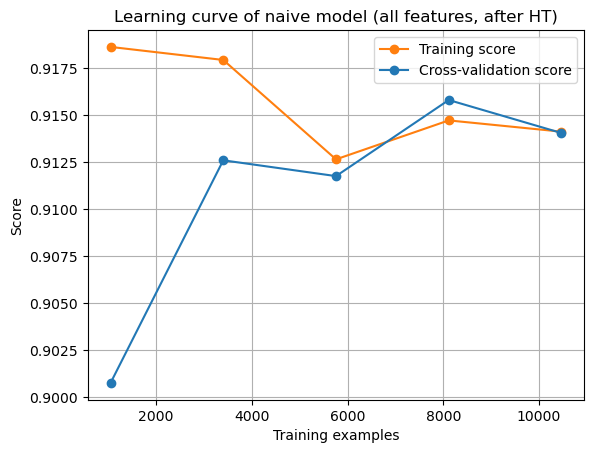

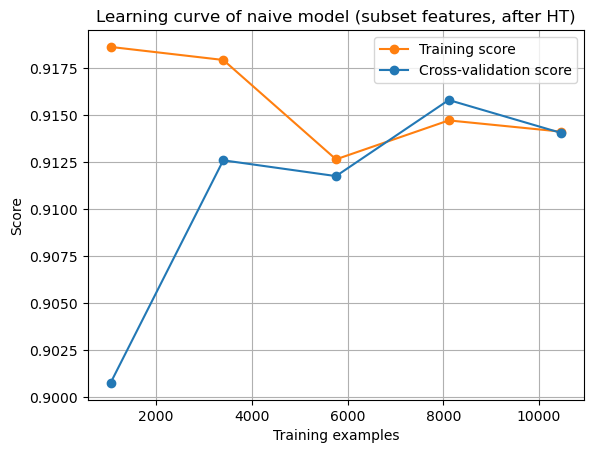

In [184]:
plot_learning_curve(naive, 'Learning curve of naive model (all features, after HT)', X_train, y_train)
plot_learning_curve(naive_sf, 'Learning curve of naive model (subset features, after HT)', X_train, y_train)

In this case the best model is by far the one using the subset of features (the other one is probably overfitting) and in this case the hyperparamter tuning hasn't been helpful since the F1 score has decreased and the accuracy has almost remained the same. Therefore we belief that the best model is that of Gaussian Naive Bayes subset features After HT (or before). 

### LDA

Hyperparameters:

**n_components:** This hyperparameter specifies the number of components (dimensions) to retain after performing dimensionality reduction with LDA. By default, n_components is set to None, which means it will retain (n_classes - 1) components, where n_classes is the number of distinct classes in the data. In the param_grid, values of [None, 1, 2, 3] are provided to try different numbers of retained components. By setting n_components to a specific value, you can explicitly control the dimensionality of the reduced feature space.

**shrinkage:** Shrinkage is a regularization technique used to improve the estimation of the covariance matrix in LDA, especially when the number of samples is small or the covariance matrix is ill-conditioned. The shrinkage hyperparameter controls the degree of shrinkage applied. 
In the param_grid, the values [None, 'auto', 0.1, 0.5] are provided to try different levels of shrinkage:
None: No shrinkage is applied.
'auto': Shrinkage is estimated using the Ledoit-Wolf lemma, which automatically determines the amount of shrinkage based on the data.
0.1, 0.5: Specific values between 0 and 1 can be provided to manually set the shrinkage intensity.

**solver:** This hyperparameter specifies the solver used for LDA computation. LDA can be solved using different algorithms, and the solver parameter determines the specific algorithm to use. 
In the param_grid, the values ['svd', 'lsqr', 'eigen'] are provided to try different solver algorithms:
'svd': Singular Value Decomposition (SVD) solver, which computes the exact solution but can be slower for large datasets.
'lsqr': Least Squares solver, which can handle both shrinkage and regularized covariance matrix.
'eigen': Eigenvalue Decomposition solver, which computes the eigenvalues and eigenvectors of the covariance matrix.

We now fit the Linear Discriminant Analysis classifier for both subset of features: 

In [114]:
# Model initialization
lda = LinearDiscriminantAnalysis()

# Model fitting using all features
cross_val_results = pd.DataFrame(cross_validate(lda , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Add metrics to results dataset
results_df.loc['LDA all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

In [115]:
# Model initialization
lda_sf = LinearDiscriminantAnalysis()

# Use all features to fit the model
cross_val_results = pd.DataFrame(cross_validate(lda_sf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Add results to dataset
results_df.loc['LDA subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

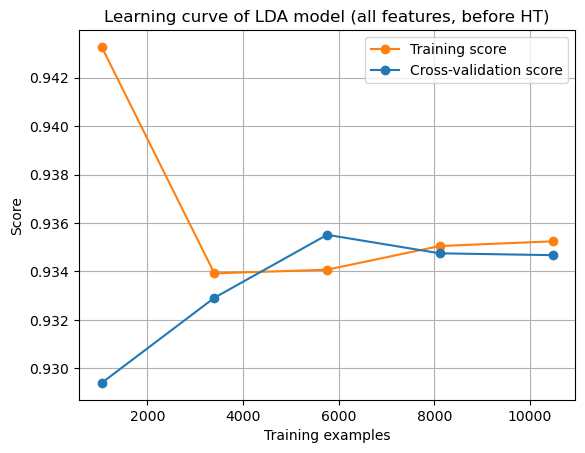

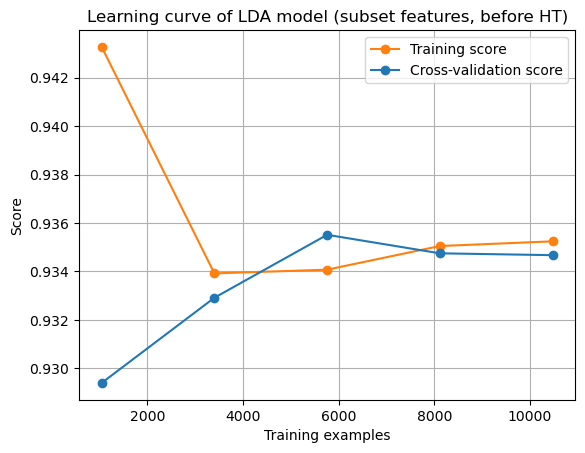

In [116]:
plot_learning_curve(lda, 'Learning curve of LDA model (all features, before HT)', X_train, y_train)
plot_learning_curve(lda_sf, 'Learning curve of LDA model (subset features, before HT)', X_train, y_train)

We now do hyperparameter tuning with the small subset of features dataset: 

In [117]:
# Model initialization
lda = LinearDiscriminantAnalysis()

# Define the parameter grid
param_grid = {
    'n_components': [None, 1, 2, 3],    # Values to try for n_components
    'shrinkage': [None, 'auto', 0.1, 0.5],    # Values to try for shrinkage
    'solver': ['svd', 'lsqr', 'eigen'],    # Values to try for solver
    'tol': [1e-6,1e-5,1e-4, 1e-3, 1e-2]    # Values to try for tol
}

# Perform grid search for hyperparameter tunning
grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
800 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/marcamps/env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/marcamps/env/lib/python3.8/site-packages/sklearn/discriminant_analysis.py", line 631, in fit
    self._solve_eigen(
  File "/Users/marcamps/env/lib/python3.8/site-packages/sklearn/discriminant_analysis.py", line 463, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/U

GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(),
             param_grid={'n_components': [None, 1, 2, 3],
                         'shrinkage': [None, 'auto', 0.1, 0.5],
                         'solver': ['svd', 'lsqr', 'eigen'],
                         'tol': [1e-06, 1e-05, 0.0001, 0.001, 0.01]})

In [118]:
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'n_components': None, 'shrinkage': 0.1, 'solver': 'lsqr', 'tol': 1e-06}
Best Score:  0.9355136378378079


After hyperparameter tuning we fit the LDA with the hyperparameters we found: 

In [185]:
# Model initialization using found hyperparameters
lda = LinearDiscriminantAnalysis(n_components = None,shrinkage = 0.1,  solver = 'lsqr', tol = 1e-06)

# We fit the model using all features
cross_val_results = pd.DataFrame(cross_validate(lda , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Update the results dataset
results_df.loc['LDA all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

In [186]:
# Model initilization
lda_sf = LinearDiscriminantAnalysis(n_components = None,shrinkage = 0.1,  solver = 'lsqr', tol = 1e-06)

# Model fitting using subset of features
cross_val_results = pd.DataFrame(cross_validate(lda_sf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Add accuray metrics to results dataset
results_df.loc['LDA subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

Accuracy  F1 Macro  \
Logistic Regression all features Before HT        0.938722  0.816842   
Logistic Regression subset features Before HT     0.939563  0.819557   
Logistic Regression all features after HT         0.939105  0.818576   
Logistic Regression subset features after HT      0.939792  0.820572   
Logistic Regression subset 2 features after HT    0.939105  0.818576   
k-NN all features before HT                       0.907778  0.631787   
k-NN subset features before HT                    0.937271  0.810123   
k-NN subset features after HT                     0.939258  0.824505   
SVC all features Before HT                        0.938569   0.81475   
SVC subset features Before HT                     0.941626  0.824517   
SVC all features After HT                          0.93559  0.815393   
SVC subset features after HT                      0.941855  0.826878   
Gaussian Naive Bayes all features Before HT       0.913814  0.744454   
Gaussian Naive Bayes subset features Before HT    0.925275  0.741975   
Gaussian Naive Bayes subset 2 features Before HT  0.913814  0.744454   
Gaussian Naive Bayes all features After HT        0.914044  0.744673   
Gaussian Naive Bayes subset features After HT     0.925275  0.741756   
LDA all features Before HT                        0.934673  0.789318   
LDA subset features Before HT                     0.934749  0.785908   
LDA all features After HT                         0.935514   0.79822   
LDA subset features After HT                      0.932075  0.773517   
Perceptron all features Before HT                 0.869048  0.699069   
Perceptron subset features Before HT              0.912589  0.764872   
Perceptron all features After HT                  0.908773  0.736786   
Perceptron subset features After HT               0.907168   0.76358   
Gradient Boost all features Before HT             0.940785  0.834955   
Gradient Boost subset features Before HT          0.940021  0.832548   
Gradient Boost all features After HT              0.939028  0.831995   
Gradient Boost subset features After HT           0.937347  0.825782   
Random Forest all features Before HT              0.937882  0.818616   
Random Forest subset features Before HT           0.938035  0.827166   
Random Forest all features After HT               0.937958  0.819838   
Random Forest subset features After HT            0.937882    0.8284   
Neural Network subset features before HT          0.941702  0.834729   
Neural Network all features before HT              0.93941  0.829158   

                                                 Precision Macro Recall Macro  
Logistic Regression all features Before HT              0.893142     0.770395  
Logistic Regression subset features Before HT           0.895687     0.772974  
Logistic Regression all features after HT               0.893109      0.77272  
Logistic Regression subset features after HT            0.895796     0.774308  
Logistic Regression subset 2 features after HT          0.893109      0.77272  
k-NN all features before HT                             0.902892     0.593987  
k-NN subset features before HT                          0.892628     0.762057  
k-NN subset features after HT                           0.881442     0.786363  
SVC all features Before HT                              0.896068     0.766691  
SVC subset features Before HT                           0.906667     0.775643  
SVC all features After HT                               0.867183     0.779781  
SVC subset features after HT                            0.902585      0.78029  
Gaussian Naive Bayes all features Before HT              0.80062     0.710312  
Gaussian Naive Bayes subset features Before HT          0.909987     0.683037  
Gaussian Naive Bayes subset 2 features Before HT         0.80062     0.710312  
Gaussian Naive Bayes all features After HT              0.801789      0.71014  
Gaussian Naive Bayes subset features After HT           0.910725     0.682736  
LDA all features 

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

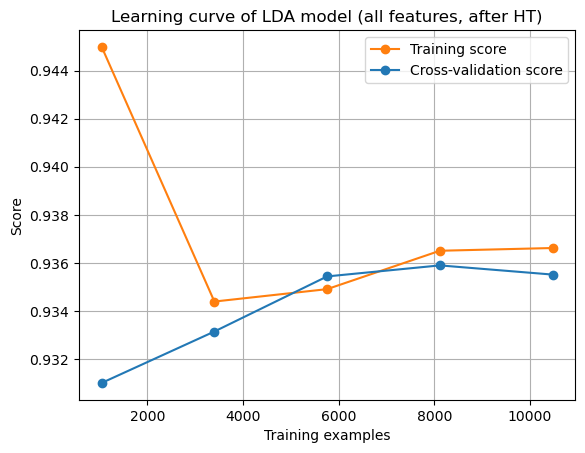

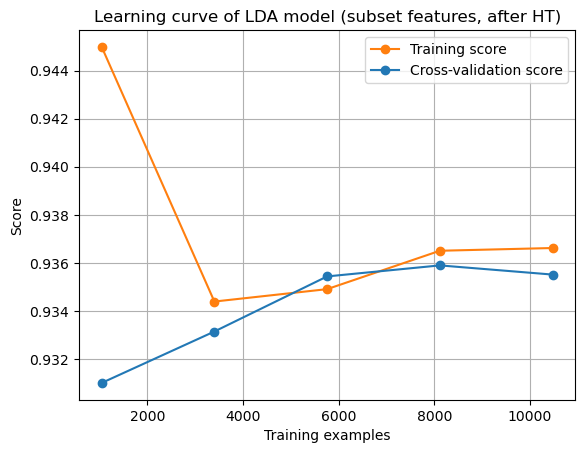

In [187]:
plot_learning_curve(lda, 'Learning curve of LDA model (all features, after HT)', X_train, y_train)
plot_learning_curve(lda_sf, 'Learning curve of LDA model (subset features, after HT)', X_train, y_train)

### Perceptron

We now fit the normal model for the perceptron. The hyperparameters are:

- **penalty:** Specifies the penalty term used in the update rule to handle misclassifications. It can be set to 'l1', 'l2', or 'elasticnet'. The default value is 'l2'.

- **max_iter:** The maximum number of passes over the training data (epochs) for training the perceptron. The default value is 1000.

- **tol:** The tolerance for the stopping criterion. It specifies the minimum change in the average loss for training to continue. The default value is 1e-3.

- **eta0:** The initial learning rate. It controls the step size at each update during training. The default value is 1.0.

- **alpha:** Learning rate

We now fit the models for both subsets of features: 

In [122]:
# Model initialization
perceptron = Perceptron()

# Model fitting using all features
cross_val_results = pd.DataFrame(cross_validate(perceptron , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Add metrics to results dataset
results_df.loc['Perceptron all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

In [123]:
# Model initialization
perceptron_sf = Perceptron()

# Model fitting using subset of features
cross_val_results = pd.DataFrame(cross_validate(perceptron_sf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Update results datafame with accuracy metrics
results_df.loc['Perceptron subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values


<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

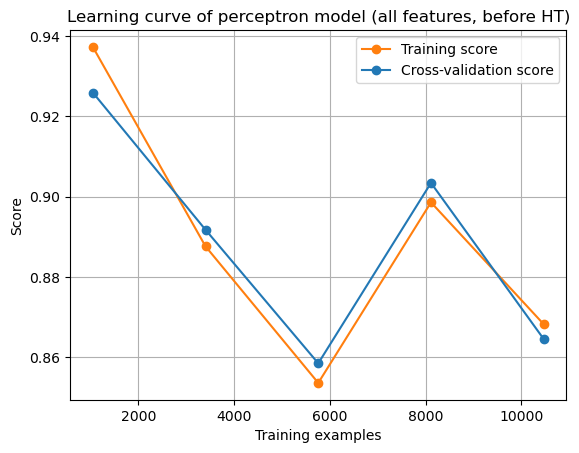

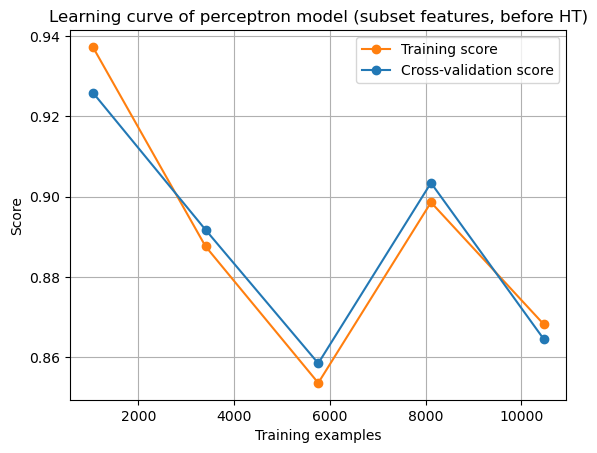

In [124]:
plot_learning_curve(perceptron, 'Learning curve of perceptron model (all features, before HT)', X_train, y_train)
plot_learning_curve(perceptron_sf, 'Learning curve of perceptron model (subset features, before HT)', X_train, y_train)

We now tune the hyper parameters using the smallest subset of features: 

In [125]:
# Model initialization
perceptron = Perceptron()

# Here we define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization penalty type
    'alpha': [0.0001, 0.001, 0.01],         # Regularization parameter
    'max_iter': [1000, 2000, 3000],         # Maximum number of iterations
    'eta0': [0.1, 0.01, 0.001],             # Initial learning rate
    'tol': [10,1,1e-1,1e-2,1e-3]            # Tolerance for stopping criterion
}

# Grid search to find best combinations of hyperparameters
grid_search = GridSearchCV(estimator=perceptron, param_grid=param_grid, cv=5)
grid_search.fit(X_train_sf, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'alpha': 0.0001, 'eta0': 0.001, 'max_iter': 1000, 'penalty': 'elasticnet', 'tol': 10}
Best Score:  0.9177092659414132


We now fit with the found hyperparameters:

In [188]:
# Model initialization using best hyperparameters
perceptron = Perceptron(alpha = 0.0001, eta0=0.001, max_iter=1000, penalty='elasticnet', tol=10)

# Model fitting with all features
perceptron.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(perceptron , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Add metrics to results dataset
results_df.loc['Perceptron all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

In [189]:
# Model initialization
perceptron_sf = Perceptron(alpha = 0.001, eta0=0.1, max_iter=1000, penalty='elasticnet', tol=10)

# Model fitting using onlya a subset of features
perceptron.fit(X_train, y_train)
cross_val_results = pd.DataFrame(cross_validate(perceptron_sf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Store accuracy metrics
results_df.loc['Perceptron subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

Accuracy  F1 Macro  \
Logistic Regression all features Before HT        0.938722  0.816842   
Logistic Regression subset features Before HT     0.939563  0.819557   
Logistic Regression all features after HT         0.939105  0.818576   
Logistic Regression subset features after HT      0.939792  0.820572   
Logistic Regression subset 2 features after HT    0.939105  0.818576   
k-NN all features before HT                       0.907778  0.631787   
k-NN subset features before HT                    0.937271  0.810123   
k-NN subset features after HT                     0.939258  0.824505   
SVC all features Before HT                        0.938569   0.81475   
SVC subset features Before HT                     0.941626  0.824517   
SVC all features After HT                          0.93559  0.815393   
SVC subset features after HT                      0.941855  0.826878   
Gaussian Naive Bayes all features Before HT       0.913814  0.744454   
Gaussian Naive Bayes subset features Before HT    0.925275  0.741975   
Gaussian Naive Bayes subset 2 features Before HT  0.913814  0.744454   
Gaussian Naive Bayes all features After HT        0.914044  0.744673   
Gaussian Naive Bayes subset features After HT     0.925275  0.741756   
LDA all features Before HT                        0.934673  0.789318   
LDA subset features Before HT                     0.934749  0.785908   
LDA all features After HT                         0.935514   0.79822   
LDA subset features After HT                      0.932075  0.773517   
Perceptron all features Before HT                 0.869048  0.699069   
Perceptron subset features Before HT              0.912589  0.764872   
Perceptron all features After HT                  0.892719  0.766222   
Perceptron subset features After HT               0.907168   0.76358   
Gradient Boost all features Before HT             0.940785  0.834955   
Gradient Boost subset features Before HT          0.940021  0.832548   
Gradient Boost all features After HT              0.939028  0.831995   
Gradient Boost subset features After HT           0.937347  0.825782   
Random Forest all features Before HT              0.937882  0.818616   
Random Forest subset features Before HT           0.938035  0.827166   
Random Forest all features After HT               0.937958  0.819838   
Random Forest subset features After HT            0.937882    0.8284   
Neural Network subset features before HT          0.941702  0.834729   
Neural Network all features before HT              0.93941  0.829158   

                                                 Precision Macro Recall Macro  
Logistic Regression all features Before HT              0.893142     0.770395  
Logistic Regression subset features Before HT           0.895687     0.772974  
Logistic Regression all features after HT               0.893109      0.77272  
Logistic Regression subset features after HT            0.895796     0.774308  
Logistic Regression subset 2 features after HT          0.893109      0.77272  
k-NN all features before HT                             0.902892     0.593987  
k-NN subset features before HT                          0.892628     0.762057  
k-NN subset features after HT                           0.881442     0.786363  
SVC all features Before HT                              0.896068     0.766691  
SVC subset features Before HT                           0.906667     0.775643  
SVC all features After HT                               0.867183     0.779781  
SVC subset features after HT                            0.902585      0.78029  
Gaussian Naive Bayes all features Before HT              0.80062     0.710312  
Gaussian Naive Bayes subset features Before HT          0.909987     0.683037  
Gaussian Naive Bayes subset 2 features Before HT         0.80062     0.710312  
Gaussian Naive Bayes all features After HT              0.801789      0.71014  
Gaussian Naive Bayes subset features After HT           0.910725     0.682736  
LDA all features 

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

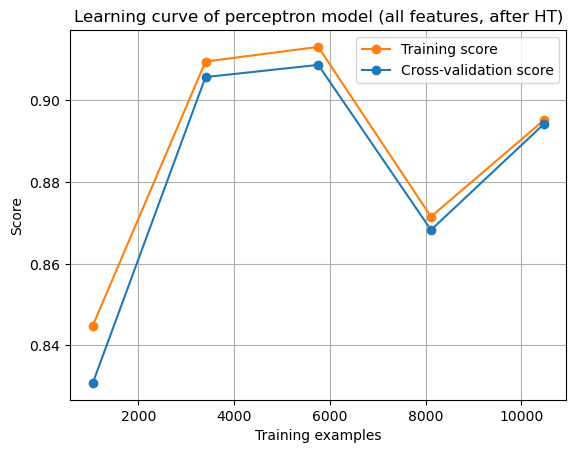

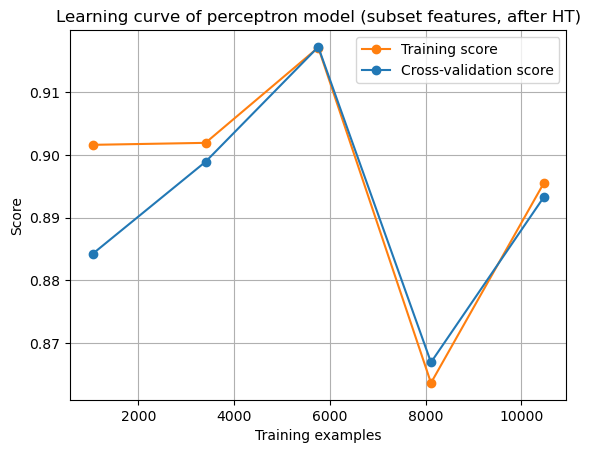

In [190]:
plot_learning_curve(perceptron, 'Learning curve of perceptron model (all features, after HT)', X_train, y_train)
plot_learning_curve(perceptron_sf, 'Learning curve of perceptron model (subset features, after HT)', X_train, y_train)

In this case we observe that the best model is by far the last we fitted: Perceptron subset features After HT, since it has the best accuracy and f1 score

### Gradient boost 

The hyperparameters for the gradient boost are:

- **n_estimators:** The number of boosting stages to perform.

- **learning_rate:** The learning rate or shrinkage parameter, which controls the contribution of each tree.

- **max_depth:** The maximum depth of individual trees in the ensemble.

- **subsample:** The subsample ratio of the training instances.

- **min_samples_split:** The minimum number of samples required to split an internal node.

We fit the model for both subset of features: 


In [129]:
# Mode initialization
gb_classifier = GradientBoostingClassifier()

# Model fitting with all features
cross_val_results = pd.DataFrame(cross_validate(gb_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Update the results dataset
results_df.loc['Gradient Boost all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

In [130]:
# Model initialization
gb_classifier_sf = GradientBoostingClassifier()

# Model fitting with a subset of features
cross_val_results = pd.DataFrame(cross_validate(gb_classifier_sf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Store accuracy metrics in the results dataset
results_df.loc['Gradient Boost subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

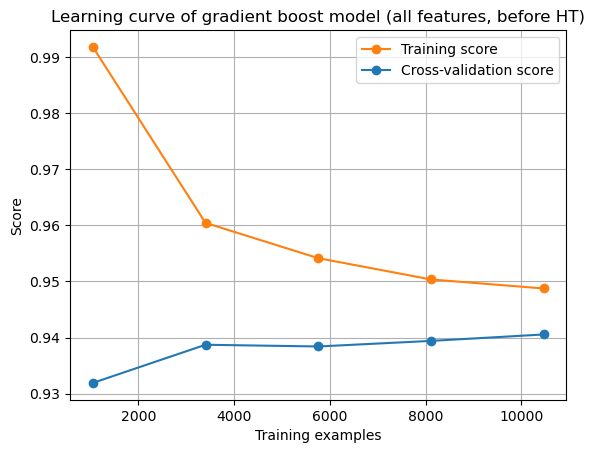

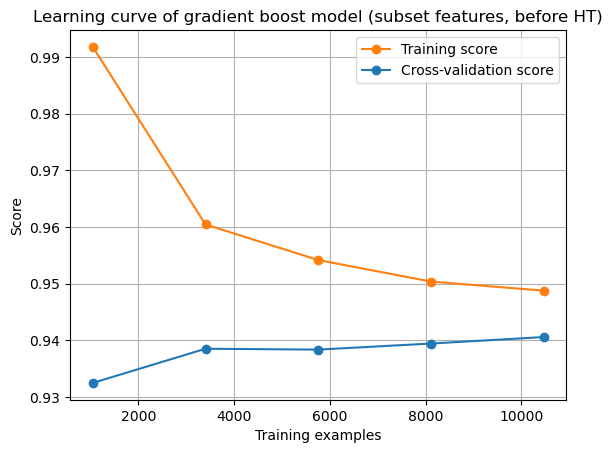

In [131]:
plot_learning_curve(gb_classifier, 'Learning curve of gradient boost model (all features, before HT)', X_train, y_train)
plot_learning_curve(gb_classifier_sf, 'Learning curve of gradient boost model (subset features, before HT)', X_train, y_train)

In [132]:
# Model initialization
gb_clf = GradientBoostingClassifier()

# We define the hyperparameter grid 
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages to perform
    'learning_rate': [0.1, 0.01, 0.001],  # Learning rate (shrinkage parameter)
    'max_depth': [3, 4, 5],  # Maximum depth of individual trees
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instances
    'min_samples_split': [2, 3, 4]  # Minimum number of samples required to split an internal node
}

# Find optimal hyperparameters using grid search
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_sf, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be re

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 50, 'subsample': 0.8}
Best F1 Score: 0.8350646028632631


In [191]:
# Model initialization using found parameters
gb_classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, min_samples_split=3, n_estimators=50, subsample=0.8)

# Predict the target variable for the test set
cross_val_results = pd.DataFrame(cross_validate(gb_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Stores the metrics 
results_df.loc['Gradient Boost all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

In [192]:
# Model initialization
gb_classifier_sf = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, min_samples_split=3, n_estimators=50, subsample=0.8)

# Predict the target variable for the test set
cross_val_results = pd.DataFrame(cross_validate(gb_classifier_sf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Store accuracy metrics in results dataset
results_df.loc['Gradient Boost subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

Accuracy  F1 Macro  \
Logistic Regression all features Before HT        0.938722  0.816842   
Logistic Regression subset features Before HT     0.939563  0.819557   
Logistic Regression all features after HT         0.939105  0.818576   
Logistic Regression subset features after HT      0.939792  0.820572   
Logistic Regression subset 2 features after HT    0.939105  0.818576   
k-NN all features before HT                       0.907778  0.631787   
k-NN subset features before HT                    0.937271  0.810123   
k-NN subset features after HT                     0.939258  0.824505   
SVC all features Before HT                        0.938569   0.81475   
SVC subset features Before HT                     0.941626  0.824517   
SVC all features After HT                          0.93559  0.815393   
SVC subset features after HT                      0.941855  0.826878   
Gaussian Naive Bayes all features Before HT       0.913814  0.744454   
Gaussian Naive Bayes subset features Before HT    0.925275  0.741975   
Gaussian Naive Bayes subset 2 features Before HT  0.913814  0.744454   
Gaussian Naive Bayes all features After HT        0.914044  0.744673   
Gaussian Naive Bayes subset features After HT     0.925275  0.741756   
LDA all features Before HT                        0.934673  0.789318   
LDA subset features Before HT                     0.934749  0.785908   
LDA all features After HT                         0.935514   0.79822   
LDA subset features After HT                      0.932075  0.773517   
Perceptron all features Before HT                 0.869048  0.699069   
Perceptron subset features Before HT              0.912589  0.764872   
Perceptron all features After HT                  0.892719  0.766222   
Perceptron subset features After HT               0.907168   0.76358   
Gradient Boost all features Before HT             0.940785  0.834955   
Gradient Boost subset features Before HT          0.940021  0.832548   
Gradient Boost all features After HT              0.939792  0.831515   
Gradient Boost subset features After HT           0.940251  0.832762   
Random Forest all features Before HT              0.937882  0.818616   
Random Forest subset features Before HT           0.938035  0.827166   
Random Forest all features After HT               0.937958  0.819838   
Random Forest subset features After HT            0.937882    0.8284   
Neural Network subset features before HT          0.941702  0.834729   
Neural Network all features before HT              0.93941  0.829158   

                                                 Precision Macro Recall Macro  
Logistic Regression all features Before HT              0.893142     0.770395  
Logistic Regression subset features Before HT           0.895687     0.772974  
Logistic Regression all features after HT               0.893109      0.77272  
Logistic Regression subset features after HT            0.895796     0.774308  
Logistic Regression subset 2 features after HT          0.893109      0.77272  
k-NN all features before HT                             0.902892     0.593987  
k-NN subset features before HT                          0.892628     0.762057  
k-NN subset features after HT                           0.881442     0.786363  
SVC all features Before HT                              0.896068     0.766691  
SVC subset features Before HT                           0.906667     0.775643  
SVC all features After HT                               0.867183     0.779781  
SVC subset features after HT                            0.902585      0.78029  
Gaussian Naive Bayes all features Before HT              0.80062     0.710312  
Gaussian Naive Bayes subset features Before HT          0.909987     0.683037  
Gaussian Naive Bayes subset 2 features Before HT         0.80062     0.710312  
Gaussian Naive Bayes all features After HT              0.801789      0.71014  
Gaussian Naive Bayes subset features After HT           0.910725     0.682736  
LDA all features 

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

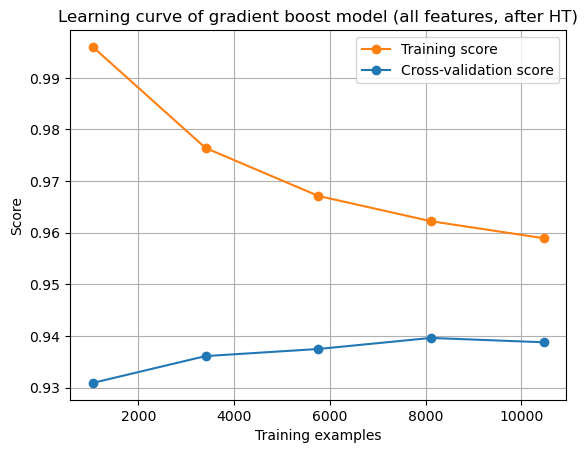

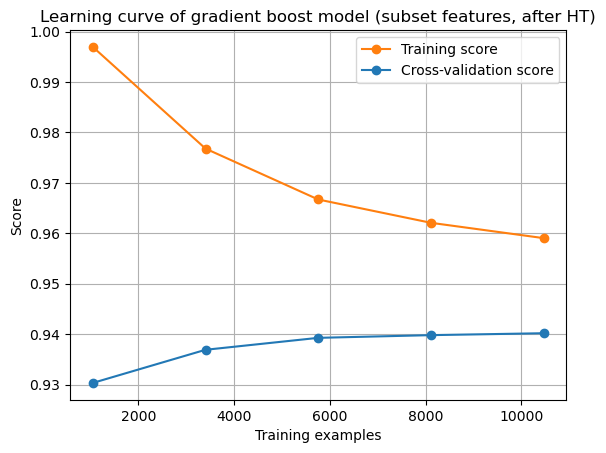

In [193]:
plot_learning_curve(gb_classifier, 'Learning curve of gradient boost model (all features, after HT)', X_train, y_train)
plot_learning_curve(gb_classifier_sf, 'Learning curve of gradient boost model (subset features, after HT)', X_train, y_train)

We obtain slightly better results with the Gradient Boost subset features After HT. 

### Random forest
The hyperparameters we can tune for the random forest are:

- **n_estimators:** The number of decision trees in the random forest. Increasing the number of estimators typically improves performance but increases computational complexity. It represents the ensemble size.

- **max_depth:** The maximum depth of each decision tree in the forest. Higher values increase model complexity and can lead to overfitting.

- **min_samples_split:** The minimum number of samples required to split an internal node. Larger values prevent overfitting by requiring a certain number of samples in each split.

- **min_samples_leaf:** The minimum number of samples required to be at a leaf node. Similar to min_samples_split, larger values help control overfitting by requiring a minimum number of samples in each leaf.

- **max_features:** The number of features to consider when looking for the best split. Reducing this number can help control overfitting. Values such as 'sqrt' or 'log2' can be used to consider a square root or logarithm of the total features, respectively.

- **bootstrap:** Determines whether bootstrap samples are used when building trees. Setting it to True enables bootstrap sampling, while False disables it. Bootstrap sampling introduces randomness into the training process and helps improve model diversity.

- **criterion:** The function used to measure the quality of a split. For classification, 'gini' or 'entropy' are commonly used. For regression, 'mse' (mean squared error) or 'mae' (mean absolute error) can be used.

We have an additional parameter (not to tune) which is criterion: The function used to measure the quality of a split. For classification, 'gini' or 'entropy' are commonly used. For regression, 'mse' (mean squared error) or 'mae' (mean absolute error) can be used.

We first fit the normal model with both subset of features: 

In [136]:
# Model initialization
rf_classifier = RandomForestClassifier()

# Model fitting using all features
cross_val_results = pd.DataFrame(cross_validate(rf_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Update the results dataset
results_df.loc['Random Forest all features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

In [137]:
# Model initialization
rf_classifier_sf = RandomForestClassifier()

# Model fitting with a subset of features
cross_val_results = pd.DataFrame(cross_validate(rf_classifier_sf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Add results to dataset
results_df.loc['Random Forest subset features Before HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

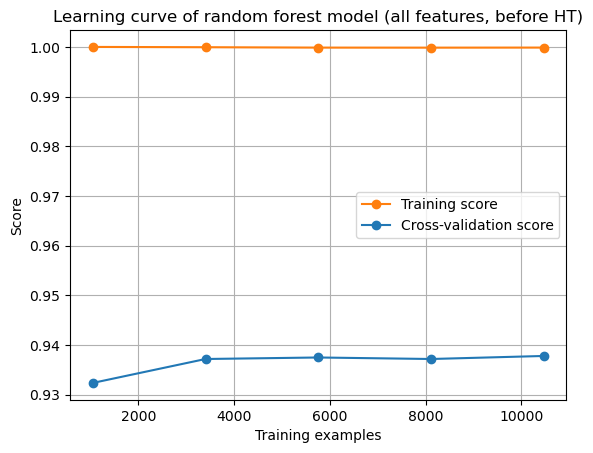

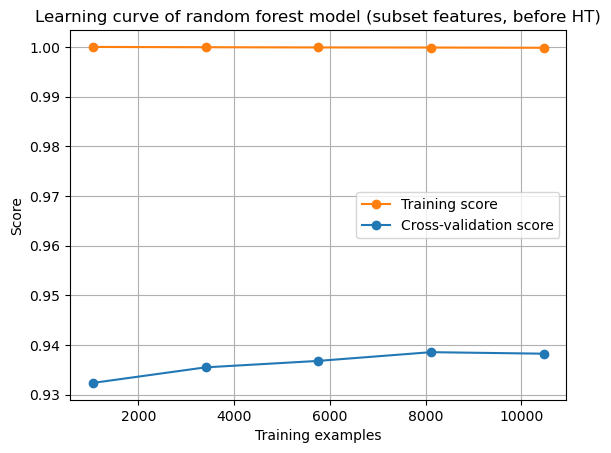

In [138]:
plot_learning_curve(rf_classifier, 'Learning curve of random forest model (all features, before HT)', X_train, y_train)
plot_learning_curve(rf_classifier_sf, 'Learning curve of random forest model (subset features, before HT)', X_train, y_train)

We now proceed to do hyperparameter tuning with the small subset of features: 

In [139]:
# Initialize the model
random_forest = RandomForestClassifier()

# We must first define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Perform grid search to find best hyperparameters combination
grid_search = GridSearchCV(random_forest, param_grid, cv=5)
grid_search.fit(X_train, y_train)

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [100, 200, 500]})

In [140]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


And now we can use the results of the hyperparameter tunning to fit betters random forest for both of our datasets.

In [194]:
# Initialize the model with the found hyperparameters
rf_classifier = RandomForestClassifier(bootstrap = True, criterion='entropy', max_features='auto', min_samples_leaf=1, min_samples_split=5,random_state=42, n_estimators = 500)

# Fit the model using all features
cross_val_results = pd.DataFrame(cross_validate(rf_classifier , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Store the accuracy metrics
results_df.loc['Random Forest all features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

In [195]:
# Model initialization with found hyperparameters
rf_classifier_sf = RandomForestClassifier(bootstrap = True, criterion='entropy', max_features='auto', min_samples_leaf=1, min_samples_split=5,random_state=42, n_estimators = 500)
# Model fititng with only a subset of features
cross_val_results = pd.DataFrame(cross_validate(rf_classifier_sf , X_train_sf, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

# Update the results dataset
results_df.loc['Random Forest subset features After HT',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

Accuracy  F1 Macro  \
Logistic Regression all features Before HT        0.938722  0.816842   
Logistic Regression subset features Before HT     0.939563  0.819557   
Logistic Regression all features after HT         0.939105  0.818576   
Logistic Regression subset features after HT      0.939792  0.820572   
Logistic Regression subset 2 features after HT    0.939105  0.818576   
k-NN all features before HT                       0.907778  0.631787   
k-NN subset features before HT                    0.937271  0.810123   
k-NN subset features after HT                     0.939258  0.824505   
SVC all features Before HT                        0.938569   0.81475   
SVC subset features Before HT                     0.941626  0.824517   
SVC all features After HT                          0.93559  0.815393   
SVC subset features after HT                      0.941855  0.826878   
Gaussian Naive Bayes all features Before HT       0.913814  0.744454   
Gaussian Naive Bayes subset features Before HT    0.925275  0.741975   
Gaussian Naive Bayes subset 2 features Before HT  0.913814  0.744454   
Gaussian Naive Bayes all features After HT        0.914044  0.744673   
Gaussian Naive Bayes subset features After HT     0.925275  0.741756   
LDA all features Before HT                        0.934673  0.789318   
LDA subset features Before HT                     0.934749  0.785908   
LDA all features After HT                         0.935514   0.79822   
LDA subset features After HT                      0.932075  0.773517   
Perceptron all features Before HT                 0.869048  0.699069   
Perceptron subset features Before HT              0.912589  0.764872   
Perceptron all features After HT                  0.892719  0.766222   
Perceptron subset features After HT               0.907168   0.76358   
Gradient Boost all features Before HT             0.940785  0.834955   
Gradient Boost subset features Before HT          0.940021  0.832548   
Gradient Boost all features After HT              0.939792  0.831515   
Gradient Boost subset features After HT           0.940251  0.832762   
Random Forest all features Before HT              0.937882  0.818616   
Random Forest subset features Before HT           0.938035  0.827166   
Random Forest all features After HT               0.939716   0.82505   
Random Forest subset features After HT            0.939639  0.831179   
Neural Network subset features before HT          0.941702  0.834729   
Neural Network all features before HT              0.93941  0.829158   

                                                 Precision Macro Recall Macro  
Logistic Regression all features Before HT              0.893142     0.770395  
Logistic Regression subset features Before HT           0.895687     0.772974  
Logistic Regression all features after HT               0.893109      0.77272  
Logistic Regression subset features after HT            0.895796     0.774308  
Logistic Regression subset 2 features after HT          0.893109      0.77272  
k-NN all features before HT                             0.902892     0.593987  
k-NN subset features before HT                          0.892628     0.762057  
k-NN subset features after HT                           0.881442     0.786363  
SVC all features Before HT                              0.896068     0.766691  
SVC subset features Before HT                           0.906667     0.775643  
SVC all features After HT                               0.867183     0.779781  
SVC subset features after HT                            0.902585      0.78029  
Gaussian Naive Bayes all features Before HT              0.80062     0.710312  
Gaussian Naive Bayes subset features Before HT          0.909987     0.683037  
Gaussian Naive Bayes subset 2 features Before HT         0.80062     0.710312  
Gaussian Naive Bayes all features After HT              0.801789      0.71014  
Gaussian Naive Bayes subset features After HT           0.910725     0.682736  
LDA all features 

<module 'matplotlib.pyplot' from '/Users/marcamps/env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

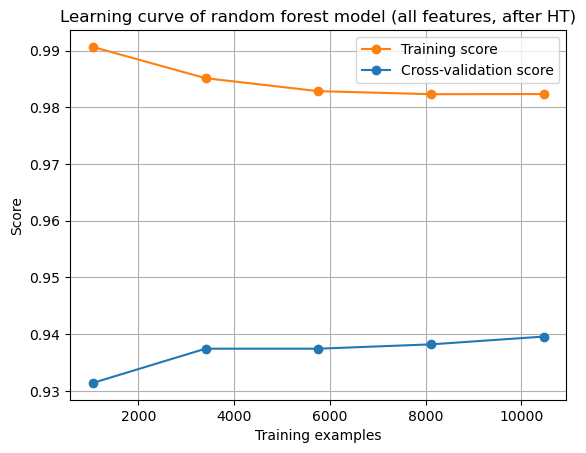

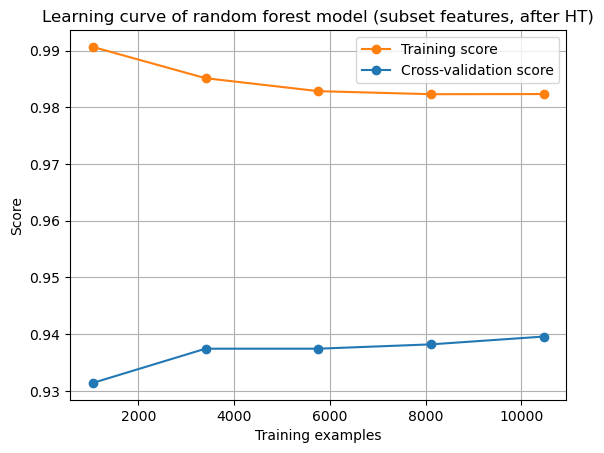

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

In [196]:
plot_learning_curve(rf_classifier, 'Learning curve of random forest model (all features, after HT)', X_train, y_train)
plot_learning_curve(rf_classifier_sf, 'Learning curve of random forest model (subset features, after HT)', X_train, y_train)

### Neural Nets
Hyperparameters: 

- **Learning rate**: The learning rate determines how much the weights are updated in response to the estimated error each time the model weights are updated. Choosing the right learning rate can be crucial as a value too small may result in a long training process that could get stuck, while a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

- **Optimizer:** what type of optimizer you want to use

- **Batch size:** This is the number of samples to work through before updating the internal model parameters. A smaller batch size can lead to more updates and potentially faster convergence, but it also introduces more variance, which can lead to instability in the learning process.

- **Activation function:** Different activation functions can result in significant differences in the performance of a neural network. The Rectified Linear Unit (ReLU) and its variants (like Leaky ReLU, Parametric ReLU) are often a good starting point for many problems.

We now do some neural nets. 

In [144]:
# install needed packages for following modeling
!pip install scikeras

#### Neural Network 

**Note:** We try to fit a simple Neural network and if this is working correctly, then we may consider other architectures. 

Fit neural network with all the features: 

In [167]:
input_dim = X_train.shape[1]
def create_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(64, activation='relu', input_dim=input_dim))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the KerasClassifier wrapper
keras_classifier = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32)

/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_40842/3675605707.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32)


In [168]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network all features before HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]

Epoch 1/10
  7/328 [..............................] - ETA: 2s - loss: 0.4574 - accuracy: 0.9018  

2023-06-04 09:35:42.991049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2308 - accuracy: 0.9185
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1859 - accuracy: 0.9356
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1772 - accuracy: 0.9376
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1726 - accuracy: 0.9394
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1701 - accuracy: 0.9398
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1672 - accuracy: 0.9416
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1658 - accuracy: 0.9415
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1623 - accuracy: 0.9431
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1622 - accuracy: 0.9427
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 09:35:58.938364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  6/328 [..............................] - ETA: 3s - loss: 0.6407 - accuracy: 0.6979  

2023-06-04 09:35:59.218196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2340 - accuracy: 0.9172
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1732 - accuracy: 0.9422
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1645 - accuracy: 0.9439
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1609 - accuracy: 0.9446
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1576 - accuracy: 0.9451
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1561 - accuracy: 0.9436
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1549 - accuracy: 0.9457
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1537 - accuracy: 0.9468
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1519 - accuracy: 0.9471
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 09:36:14.595989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  8/328 [..............................] - ETA: 2s - loss: 0.7577 - accuracy: 0.3750  

2023-06-04 09:36:14.873942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2381 - accuracy: 0.9060
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1756 - accuracy: 0.9385
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1681 - accuracy: 0.9396
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1628 - accuracy: 0.9428
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1617 - accuracy: 0.9424
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1586 - accuracy: 0.9437
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1551 - accuracy: 0.9453
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1538 - accuracy: 0.9453
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1524 - accuracy: 0.9466
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 09:36:30.273182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  7/328 [..............................] - ETA: 2s - loss: 0.6172 - accuracy: 0.7455  

2023-06-04 09:36:30.546966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2425 - accuracy: 0.9129
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1793 - accuracy: 0.9367
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1714 - accuracy: 0.9401
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1659 - accuracy: 0.9407
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1635 - accuracy: 0.9405
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1615 - accuracy: 0.9431
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1592 - accuracy: 0.9443
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1577 - accuracy: 0.9417
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1565 - accuracy: 0.9440
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 09:36:46.266271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  6/328 [..............................] - ETA: 3s - loss: 0.7380 - accuracy: 0.4583  

2023-06-04 09:36:46.545643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2544 - accuracy: 0.9046
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1792 - accuracy: 0.9374
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1703 - accuracy: 0.9405
Epoch 4/10
328/328 [==============================] - 1s 5ms/step - loss: 0.1672 - accuracy: 0.9423
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1622 - accuracy: 0.9440
Epoch 6/10
328/328 [==============================] - 1s 5ms/step - loss: 0.1613 - accuracy: 0.9443
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1589 - accuracy: 0.9447
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1572 - accuracy: 0.9451
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1574 - accuracy: 0.9452
Epoch 10/10
82/82 [==============================] - 0s 1ms/step


2023-06-04 09:37:02.016947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Fit with the subset of variables: 

In [172]:
input_dim_sf = X_train_sf.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim_sf))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier_sf = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32)

/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_40842/1864507112.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier_sf = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32)


In [174]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier_sf, X_train_sf, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network subset features before HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]



Epoch 1/10
  4/328 [..............................] - ETA: 5s - loss: 0.6588 - accuracy: 0.7188  

2023-06-04 09:39:15.004909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2738 - accuracy: 0.9127
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1844 - accuracy: 0.9371
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1754 - accuracy: 0.9384
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1729 - accuracy: 0.9391
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1715 - accuracy: 0.9400
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1704 - accuracy: 0.9404
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1699 - accuracy: 0.9402
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1701 - accuracy: 0.9410
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1685 - accuracy: 0.9411
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 09:39:30.755979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  4/328 [..............................] - ETA: 5s - loss: 0.7426 - accuracy: 0.4141  

2023-06-04 09:39:31.030129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2868 - accuracy: 0.9041
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1767 - accuracy: 0.9395
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1644 - accuracy: 0.9424
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1615 - accuracy: 0.9432
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1598 - accuracy: 0.9441
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1589 - accuracy: 0.9443
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1581 - accuracy: 0.9435
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1574 - accuracy: 0.9445
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1568 - accuracy: 0.9433
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 09:39:46.827990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  5/328 [..............................] - ETA: 4s - loss: 0.5660 - accuracy: 0.9000  

2023-06-04 09:39:47.090476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2684 - accuracy: 0.9134
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1821 - accuracy: 0.9383
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1692 - accuracy: 0.9413
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1650 - accuracy: 0.9422
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1635 - accuracy: 0.9423
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1623 - accuracy: 0.9432
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1612 - accuracy: 0.9438
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1615 - accuracy: 0.9427
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1609 - accuracy: 0.9415
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 09:40:02.905525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  5/328 [..............................] - ETA: 4s - loss: 0.7117 - accuracy: 0.3563  

2023-06-04 09:40:03.196443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2816 - accuracy: 0.9034
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1837 - accuracy: 0.9364
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1712 - accuracy: 0.9416
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1675 - accuracy: 0.9415
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1659 - accuracy: 0.9432
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1649 - accuracy: 0.9414
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1637 - accuracy: 0.9422
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1639 - accuracy: 0.9420
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1632 - accuracy: 0.9416
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 09:40:19.672861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  6/328 [..............................] - ETA: 3s - loss: 0.6363 - accuracy: 0.8958  

2023-06-04 09:40:19.966056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2707 - accuracy: 0.9167
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1785 - accuracy: 0.9388
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1684 - accuracy: 0.9411
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1664 - accuracy: 0.9430
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1648 - accuracy: 0.9431
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1643 - accuracy: 0.9431
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1636 - accuracy: 0.9421
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1640 - accuracy: 0.9423
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1626 - accuracy: 0.9429
Epoch 10/10
82/82 [==============================] - 0s 1ms/step


2023-06-04 09:40:35.841597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Perform HyperParameter tuning:

In [200]:
input_dim = X_train_sf.shape[1]

# Define the parameter grid
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30, 40],
}

# Define a function to create your neural network model
def create_model(optimizer=Adam(learning_rate=0.001)):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(build_fn=create_model)



# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'], refit='f1_macro')

# Perform hyperparameter tuning
grid_search.fit(X_train_sf, y_train)

Epoch 1/10


/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_40842/3058817430.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = KerasClassifier(build_fn=create_model)
2023-06-04 10:08:11.406675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2841 - accuracy: 0.9084
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1874 - accuracy: 0.9378
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1749 - accuracy: 0.9406
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1726 - accuracy: 0.9406
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1712 - accuracy: 0.9407
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1700 - accuracy: 0.9412
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1691 - accuracy: 0.9416
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1691 - accuracy: 0.9407
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1686 - accuracy: 0.9421
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 10:08:27.019090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:21 - loss: 0.7110 - accuracy: 0.3438

2023-06-04 10:08:27.296766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2000 - accuracy: 0.9301
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1642 - accuracy: 0.9420
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1609 - accuracy: 0.9430
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1582 - accuracy: 0.9454
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1583 - accuracy: 0.9424
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1577 - accuracy: 0.9437
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1566 - accuracy: 0.9442
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1561 - accuracy: 0.9440
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1561 - accuracy: 0.9442
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 10:08:43.032449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:20 - loss: 0.7169 - accuracy: 0.4688

2023-06-04 10:08:43.309974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2096 - accuracy: 0.9287
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1655 - accuracy: 0.9428
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1631 - accuracy: 0.9443
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1627 - accuracy: 0.9408
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1622 - accuracy: 0.9416
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1607 - accuracy: 0.9440
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1599 - accuracy: 0.9444
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1596 - accuracy: 0.9431
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1605 - accuracy: 0.9431
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 10:08:58.887958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  4/328 [..............................] - ETA: 6s - loss: 0.5717 - accuracy: 0.8672  

2023-06-04 10:08:59.159015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2044 - accuracy: 0.9291
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1684 - accuracy: 0.9423
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1659 - accuracy: 0.9421
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1646 - accuracy: 0.9427
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1649 - accuracy: 0.9417
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1637 - accuracy: 0.9429
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1629 - accuracy: 0.9421
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1623 - accuracy: 0.9414
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1625 - accuracy: 0.9426
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 10:09:14.785243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:27 - loss: 0.6629 - accuracy: 0.8125

2023-06-04 10:09:15.060972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2023 - accuracy: 0.9291
Epoch 2/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1680 - accuracy: 0.9400
Epoch 3/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1646 - accuracy: 0.9431
Epoch 4/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1643 - accuracy: 0.9438
Epoch 5/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1637 - accuracy: 0.9417
Epoch 6/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1631 - accuracy: 0.9434
Epoch 7/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1617 - accuracy: 0.9436
Epoch 8/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1619 - accuracy: 0.9442
Epoch 9/10
328/328 [==============================] - 2s 5ms/step - loss: 0.1618 - accuracy: 0.9421
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/20


2023-06-04 10:09:30.699236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:30 - loss: 0.7395 - accuracy: 0.5000

2023-06-04 10:09:30.980974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2110 - accuracy: 0.9267
Epoch 2/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1736 - accuracy: 0.9387
Epoch 3/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1700 - accuracy: 0.9423
Epoch 4/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1698 - accuracy: 0.9399
Epoch 5/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1687 - accuracy: 0.9402
Epoch 6/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1693 - accuracy: 0.9410
Epoch 7/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1680 - accuracy: 0.9415
Epoch 8/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1676 - accuracy: 0.9413
Epoch 9/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1676 - accuracy: 0.9415
Epoch 10/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1680 - accuracy: 0.9422
Epoch 11/2

2023-06-04 10:10:02.136353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  4/328 [..............................] - ETA: 6s - loss: 0.6306 - accuracy: 0.7656  

2023-06-04 10:10:02.409108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.1998 - accuracy: 0.9303
Epoch 2/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1639 - accuracy: 0.9414
Epoch 3/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1608 - accuracy: 0.9430
Epoch 4/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1590 - accuracy: 0.9436
Epoch 5/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1574 - accuracy: 0.9456
Epoch 6/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1573 - accuracy: 0.9437
Epoch 7/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1565 - accuracy: 0.9445
Epoch 8/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1559 - accuracy: 0.9449
Epoch 9/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1555 - accuracy: 0.9454
Epoch 10/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1556 - accuracy: 0.9444
Epoch 11/2

2023-06-04 10:10:33.304224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:26 - loss: 0.6912 - accuracy: 0.5938

2023-06-04 10:10:33.574915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2038 - accuracy: 0.9311
Epoch 2/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1673 - accuracy: 0.9410
Epoch 3/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1647 - accuracy: 0.9430
Epoch 4/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1631 - accuracy: 0.9418
Epoch 5/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1623 - accuracy: 0.9421
Epoch 6/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1617 - accuracy: 0.9429
Epoch 7/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1610 - accuracy: 0.9422
Epoch 8/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1599 - accuracy: 0.9433
Epoch 9/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1602 - accuracy: 0.9425
Epoch 10/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1602 - accuracy: 0.9436
Epoch 11/2

2023-06-04 10:11:04.560101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:35 - loss: 0.7232 - accuracy: 0.4375

2023-06-04 10:11:04.848050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2021 - accuracy: 0.9270
Epoch 2/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1674 - accuracy: 0.9405
Epoch 3/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1648 - accuracy: 0.9426
Epoch 4/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1637 - accuracy: 0.9408
Epoch 5/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1625 - accuracy: 0.9433
Epoch 6/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1628 - accuracy: 0.9419
Epoch 7/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1631 - accuracy: 0.9412
Epoch 8/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1621 - accuracy: 0.9423
Epoch 9/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1618 - accuracy: 0.9428
Epoch 10/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1616 - accuracy: 0.9416
Epoch 11/2

2023-06-04 10:11:36.146998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:34 - loss: 0.6517 - accuracy: 0.8750

2023-06-04 10:11:36.423210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2066 - accuracy: 0.9306
Epoch 2/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1696 - accuracy: 0.9411
Epoch 3/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1657 - accuracy: 0.9417
Epoch 4/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1654 - accuracy: 0.9432
Epoch 5/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1640 - accuracy: 0.9429
Epoch 6/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1627 - accuracy: 0.9431
Epoch 7/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1629 - accuracy: 0.9430
Epoch 8/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1623 - accuracy: 0.9442
Epoch 9/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1619 - accuracy: 0.9442
Epoch 10/20
328/328 [==============================] - 2s 5ms/step - loss: 0.1618 - accuracy: 0.9424
Epoch 11/2

2023-06-04 10:12:07.787711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:36 - loss: 0.7276 - accuracy: 0.2500

2023-06-04 10:12:08.072847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2119 - accuracy: 0.9235
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1747 - accuracy: 0.9388
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1706 - accuracy: 0.9393
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1694 - accuracy: 0.9406
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1693 - accuracy: 0.9400
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1680 - accuracy: 0.9419
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1683 - accuracy: 0.9417
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1676 - accuracy: 0.9418
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1674 - accuracy: 0.9426
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1671 - accuracy: 0.9415
Epoch 11/3

2023-06-04 10:12:54.829761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:36 - loss: 0.6366 - accuracy: 0.6875

2023-06-04 10:12:55.120384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.1915 - accuracy: 0.9344
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1616 - accuracy: 0.9442
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1598 - accuracy: 0.9437
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1586 - accuracy: 0.9441
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1581 - accuracy: 0.9447
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1573 - accuracy: 0.9454
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1562 - accuracy: 0.9446
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1576 - accuracy: 0.9436
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1563 - accuracy: 0.9454
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1556 - accuracy: 0.9452
Epoch 11/3

2023-06-04 10:13:41.927265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:37 - loss: 0.7742 - accuracy: 0.1875

2023-06-04 10:13:42.210510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2109 - accuracy: 0.9253
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1689 - accuracy: 0.9403
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1652 - accuracy: 0.9438
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1633 - accuracy: 0.9435
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1631 - accuracy: 0.9424
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1617 - accuracy: 0.9423
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1613 - accuracy: 0.9425
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1610 - accuracy: 0.9424
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1609 - accuracy: 0.9436
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1607 - accuracy: 0.9437
Epoch 11/3

2023-06-04 10:14:28.813635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:37 - loss: 0.7795 - accuracy: 0.0938

2023-06-04 10:14:29.104500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2110 - accuracy: 0.9267
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1676 - accuracy: 0.9416
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1647 - accuracy: 0.9418
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1632 - accuracy: 0.9424
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1640 - accuracy: 0.9425
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1628 - accuracy: 0.9425
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1617 - accuracy: 0.9426
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1620 - accuracy: 0.9425
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1615 - accuracy: 0.9407
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1610 - accuracy: 0.9428
Epoch 11/3

2023-06-04 10:15:15.637986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:33 - loss: 0.6884 - accuracy: 0.6250

2023-06-04 10:15:15.923394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2078 - accuracy: 0.9288
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1682 - accuracy: 0.9404
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1651 - accuracy: 0.9420
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1636 - accuracy: 0.9437
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1641 - accuracy: 0.9426
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1621 - accuracy: 0.9439
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1620 - accuracy: 0.9437
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1627 - accuracy: 0.9417
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1609 - accuracy: 0.9443
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1605 - accuracy: 0.9446
Epoch 11/3

2023-06-04 10:16:02.455697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:32 - loss: 0.7903 - accuracy: 0.0625

2023-06-04 10:16:02.729208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2157 - accuracy: 0.9245
Epoch 2/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1750 - accuracy: 0.9398
Epoch 3/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1710 - accuracy: 0.9419
Epoch 4/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1693 - accuracy: 0.9420
Epoch 5/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1697 - accuracy: 0.9420
Epoch 6/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1686 - accuracy: 0.9422
Epoch 7/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1677 - accuracy: 0.9420
Epoch 8/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1685 - accuracy: 0.9405
Epoch 9/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1671 - accuracy: 0.9420
Epoch 10/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1672 - accuracy: 0.9422
Epoch 11/4

2023-06-04 10:17:04.593903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:34 - loss: 0.7645 - accuracy: 0.0625

2023-06-04 10:17:04.875335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2113 - accuracy: 0.9248
Epoch 2/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1650 - accuracy: 0.9418
Epoch 3/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1601 - accuracy: 0.9437
Epoch 4/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1587 - accuracy: 0.9439
Epoch 5/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1581 - accuracy: 0.9435
Epoch 6/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1569 - accuracy: 0.9436
Epoch 7/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1563 - accuracy: 0.9442
Epoch 8/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1561 - accuracy: 0.9453
Epoch 9/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1558 - accuracy: 0.9446
Epoch 10/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1549 - accuracy: 0.9453
Epoch 11/4

2023-06-04 10:18:06.634317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:34 - loss: 0.8032 - accuracy: 0.1562

2023-06-04 10:18:06.922789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2056 - accuracy: 0.9245
Epoch 2/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1653 - accuracy: 0.9420
Epoch 3/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1639 - accuracy: 0.9422
Epoch 4/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1622 - accuracy: 0.9422
Epoch 5/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1621 - accuracy: 0.9438
Epoch 6/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1620 - accuracy: 0.9424
Epoch 7/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1608 - accuracy: 0.9428
Epoch 8/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1606 - accuracy: 0.9442
Epoch 9/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1604 - accuracy: 0.9440
Epoch 10/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1613 - accuracy: 0.9429
Epoch 11/4

2023-06-04 10:19:08.944498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:36 - loss: 0.6320 - accuracy: 0.9062

2023-06-04 10:19:09.231467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2082 - accuracy: 0.9295
Epoch 2/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1684 - accuracy: 0.9402
Epoch 3/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1656 - accuracy: 0.9418
Epoch 4/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1641 - accuracy: 0.9426
Epoch 5/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1637 - accuracy: 0.9423
Epoch 6/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1635 - accuracy: 0.9424
Epoch 7/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1634 - accuracy: 0.9420
Epoch 8/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1625 - accuracy: 0.9432
Epoch 9/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1628 - accuracy: 0.9422
Epoch 10/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1623 - accuracy: 0.9424
Epoch 11/4

2023-06-04 10:20:11.389214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/328 [..............................] - ETA: 1:34 - loss: 0.7398 - accuracy: 0.3125

2023-06-04 10:20:11.675893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2024 - accuracy: 0.9307
Epoch 2/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1679 - accuracy: 0.9416
Epoch 3/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1654 - accuracy: 0.9428
Epoch 4/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1640 - accuracy: 0.9420
Epoch 5/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1637 - accuracy: 0.9421
Epoch 6/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1629 - accuracy: 0.9425
Epoch 7/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1622 - accuracy: 0.9434
Epoch 8/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1624 - accuracy: 0.9433
Epoch 9/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1619 - accuracy: 0.9421
Epoch 10/40
328/328 [==============================] - 2s 5ms/step - loss: 0.1614 - accuracy: 0.9427
Epoch 11/4

2023-06-04 10:21:14.214729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:21:14.502759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 6ms/step - loss: 0.2447 - accuracy: 0.9166
Epoch 2/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1766 - accuracy: 0.9394
Epoch 3/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1726 - accuracy: 0.9401
Epoch 4/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1718 - accuracy: 0.9403
Epoch 5/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1695 - accuracy: 0.9414
Epoch 6/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1696 - accuracy: 0.9421
Epoch 7/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1685 - accuracy: 0.9410
Epoch 8/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1682 - accuracy: 0.9407
Epoch 9/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1675 - accuracy: 0.9409
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 10:21:22.860402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:21:23.145248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 6ms/step - loss: 0.2186 - accuracy: 0.9266
Epoch 2/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1656 - accuracy: 0.9424
Epoch 3/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1607 - accuracy: 0.9448
Epoch 4/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1599 - accuracy: 0.9435
Epoch 5/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1581 - accuracy: 0.9453
Epoch 6/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1572 - accuracy: 0.9449
Epoch 7/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1565 - accuracy: 0.9457
Epoch 8/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1565 - accuracy: 0.9446
Epoch 9/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1559 - accuracy: 0.9447
Epoch 10/10
82/82 [==============================] - 0s 2ms/step


2023-06-04 10:21:31.533907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10
  1/164 [..............................] - ETA: 46s - loss: 0.6227 - accuracy: 0.8438

2023-06-04 10:21:31.837040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 7ms/step - loss: 0.2195 - accuracy: 0.9287
Epoch 2/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1688 - accuracy: 0.9411
Epoch 3/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1643 - accuracy: 0.9415
Epoch 4/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1622 - accuracy: 0.9442
Epoch 5/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1616 - accuracy: 0.9432
Epoch 6/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1618 - accuracy: 0.9431
Epoch 7/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1609 - accuracy: 0.9434
Epoch 8/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1601 - accuracy: 0.9445
Epoch 9/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1596 - accuracy: 0.9444
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 10:21:40.243593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:21:41.140483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 2s 6ms/step - loss: 0.2195 - accuracy: 0.9259
Epoch 2/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1697 - accuracy: 0.9390
Epoch 3/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1653 - accuracy: 0.9413
Epoch 4/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1639 - accuracy: 0.9427
Epoch 5/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1635 - accuracy: 0.9408
Epoch 6/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1627 - accuracy: 0.9416
Epoch 7/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1627 - accuracy: 0.9426
Epoch 8/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1622 - accuracy: 0.9429
Epoch 9/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1612 - accuracy: 0.9434
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 10:21:49.427806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/164 [..............................] - ETA: 47s - loss: 0.6849 - accuracy: 0.5781

2023-06-04 10:21:49.720393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 6ms/step - loss: 0.2276 - accuracy: 0.9217
Epoch 2/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1719 - accuracy: 0.9402
Epoch 3/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1666 - accuracy: 0.9425
Epoch 4/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1648 - accuracy: 0.9427
Epoch 5/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1632 - accuracy: 0.9438
Epoch 6/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1628 - accuracy: 0.9426
Epoch 7/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1627 - accuracy: 0.9433
Epoch 8/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1617 - accuracy: 0.9443
Epoch 9/10
164/164 [==============================] - 1s 5ms/step - loss: 0.1620 - accuracy: 0.9429
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/20


2023-06-04 10:21:58.066686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:21:58.352041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 6ms/step - loss: 0.2382 - accuracy: 0.9187
Epoch 2/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1761 - accuracy: 0.9407
Epoch 3/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1717 - accuracy: 0.9411
Epoch 4/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1694 - accuracy: 0.9407
Epoch 5/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1694 - accuracy: 0.9404
Epoch 6/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1688 - accuracy: 0.9401
Epoch 7/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1688 - accuracy: 0.9407
Epoch 8/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1675 - accuracy: 0.9415
Epoch 9/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1681 - accuracy: 0.9415
Epoch 10/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1675 - accuracy: 0.9417
Epoch 11/2

2023-06-04 10:22:14.477207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:22:14.765436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 6ms/step - loss: 0.2271 - accuracy: 0.9205
Epoch 2/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1655 - accuracy: 0.9439
Epoch 3/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1609 - accuracy: 0.9429
Epoch 4/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1592 - accuracy: 0.9439
Epoch 5/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1586 - accuracy: 0.9456
Epoch 6/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1570 - accuracy: 0.9454
Epoch 7/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1567 - accuracy: 0.9434
Epoch 8/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1564 - accuracy: 0.9440
Epoch 9/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1573 - accuracy: 0.9433
Epoch 10/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1565 - accuracy: 0.9451
Epoch 11/2

2023-06-04 10:22:30.892356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/164 [..............................] - ETA: 48s - loss: 0.7626 - accuracy: 0.1406

2023-06-04 10:22:31.185358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 6ms/step - loss: 0.2310 - accuracy: 0.9185
Epoch 2/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1689 - accuracy: 0.9403
Epoch 3/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1645 - accuracy: 0.9418
Epoch 4/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1635 - accuracy: 0.9419
Epoch 5/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1627 - accuracy: 0.9428
Epoch 6/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1619 - accuracy: 0.9427
Epoch 7/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1615 - accuracy: 0.9435
Epoch 8/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1599 - accuracy: 0.9427
Epoch 9/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1605 - accuracy: 0.9431
Epoch 10/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1598 - accuracy: 0.9450
Epoch 11/2

2023-06-04 10:22:47.315139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:22:47.614346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 6ms/step - loss: 0.2332 - accuracy: 0.9162
Epoch 2/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1712 - accuracy: 0.9395
Epoch 3/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1665 - accuracy: 0.9428
Epoch 4/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1647 - accuracy: 0.9432
Epoch 5/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1640 - accuracy: 0.9423
Epoch 6/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1634 - accuracy: 0.9423
Epoch 7/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1630 - accuracy: 0.9429
Epoch 8/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1628 - accuracy: 0.9419
Epoch 9/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1621 - accuracy: 0.9438
Epoch 10/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1619 - accuracy: 0.9425
Epoch 11/2

2023-06-04 10:23:03.811725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:23:04.107398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 7ms/step - loss: 0.2258 - accuracy: 0.9231
Epoch 2/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1697 - accuracy: 0.9422
Epoch 3/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1670 - accuracy: 0.9417
Epoch 4/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1639 - accuracy: 0.9416
Epoch 5/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1635 - accuracy: 0.9422
Epoch 6/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1637 - accuracy: 0.9431
Epoch 7/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1619 - accuracy: 0.9430
Epoch 8/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1614 - accuracy: 0.9436
Epoch 9/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1613 - accuracy: 0.9425
Epoch 10/20
164/164 [==============================] - 1s 5ms/step - loss: 0.1610 - accuracy: 0.9435
Epoch 11/2

2023-06-04 10:23:20.373099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:23:20.666035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 6ms/step - loss: 0.2309 - accuracy: 0.9225
Epoch 2/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1761 - accuracy: 0.9395
Epoch 3/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1716 - accuracy: 0.9396
Epoch 4/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1701 - accuracy: 0.9422
Epoch 5/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1688 - accuracy: 0.9409
Epoch 6/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1684 - accuracy: 0.9414
Epoch 7/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1682 - accuracy: 0.9408
Epoch 8/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1679 - accuracy: 0.9415
Epoch 9/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1674 - accuracy: 0.9422
Epoch 10/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1663 - accuracy: 0.9425
Epoch 11/3

2023-06-04 10:23:44.762652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30
  1/164 [..............................] - ETA: 46s - loss: 0.7211 - accuracy: 0.3594

2023-06-04 10:23:45.062771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 7ms/step - loss: 0.2261 - accuracy: 0.9181
Epoch 2/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1663 - accuracy: 0.9415
Epoch 3/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1611 - accuracy: 0.9436
Epoch 4/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1590 - accuracy: 0.9450
Epoch 5/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1584 - accuracy: 0.9447
Epoch 6/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1581 - accuracy: 0.9446
Epoch 7/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1568 - accuracy: 0.9453
Epoch 8/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1563 - accuracy: 0.9455
Epoch 9/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1561 - accuracy: 0.9460
Epoch 10/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1558 - accuracy: 0.9466
Epoch 11/3

2023-06-04 10:24:09.267115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:24:09.553588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 7ms/step - loss: 0.2218 - accuracy: 0.9234
Epoch 2/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1702 - accuracy: 0.9397
Epoch 3/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1670 - accuracy: 0.9424
Epoch 4/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1642 - accuracy: 0.9425
Epoch 5/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1629 - accuracy: 0.9427
Epoch 6/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1618 - accuracy: 0.9438
Epoch 7/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1609 - accuracy: 0.9436
Epoch 8/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1613 - accuracy: 0.9445
Epoch 9/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1609 - accuracy: 0.9431
Epoch 10/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1598 - accuracy: 0.9434
Epoch 11/3

2023-06-04 10:24:33.778988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:24:34.071320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 7ms/step - loss: 0.2176 - accuracy: 0.9264
Epoch 2/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1707 - accuracy: 0.9388
Epoch 3/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1662 - accuracy: 0.9412
Epoch 4/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1650 - accuracy: 0.9431
Epoch 5/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1643 - accuracy: 0.9420
Epoch 6/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1635 - accuracy: 0.9413
Epoch 7/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1635 - accuracy: 0.9424
Epoch 8/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1629 - accuracy: 0.9425
Epoch 9/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1625 - accuracy: 0.9423
Epoch 10/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1623 - accuracy: 0.9432
Epoch 11/3

2023-06-04 10:24:58.431469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:24:58.724357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 6ms/step - loss: 0.2268 - accuracy: 0.9204
Epoch 2/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1694 - accuracy: 0.9416
Epoch 3/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1650 - accuracy: 0.9425
Epoch 4/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1634 - accuracy: 0.9433
Epoch 5/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1645 - accuracy: 0.9425
Epoch 6/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1625 - accuracy: 0.9423
Epoch 7/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1621 - accuracy: 0.9418
Epoch 8/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1622 - accuracy: 0.9416
Epoch 9/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1606 - accuracy: 0.9423
Epoch 10/30
164/164 [==============================] - 1s 5ms/step - loss: 0.1608 - accuracy: 0.9434
Epoch 11/3

2023-06-04 10:25:23.044102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:25:23.347960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 6ms/step - loss: 0.2357 - accuracy: 0.9195
Epoch 2/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1788 - accuracy: 0.9391
Epoch 3/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1729 - accuracy: 0.9396
Epoch 4/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1707 - accuracy: 0.9410
Epoch 5/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1696 - accuracy: 0.9404
Epoch 6/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1687 - accuracy: 0.9401
Epoch 7/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1689 - accuracy: 0.9407
Epoch 8/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1672 - accuracy: 0.9409
Epoch 9/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1678 - accuracy: 0.9413
Epoch 10/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1677 - accuracy: 0.9414
Epoch 11/4

2023-06-04 10:25:55.620808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/40


2023-06-04 10:25:55.925742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 7ms/step - loss: 0.2144 - accuracy: 0.9263
Epoch 2/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1637 - accuracy: 0.9415
Epoch 3/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1623 - accuracy: 0.9414
Epoch 4/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1580 - accuracy: 0.9444
Epoch 5/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1579 - accuracy: 0.9439
Epoch 6/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1572 - accuracy: 0.9436
Epoch 7/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1561 - accuracy: 0.9445
Epoch 8/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1550 - accuracy: 0.9446
Epoch 9/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1558 - accuracy: 0.9434
Epoch 10/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1553 - accuracy: 0.9447
Epoch 11/4

2023-06-04 10:26:28.579077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:26:28.877787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 6ms/step - loss: 0.2141 - accuracy: 0.9299
Epoch 2/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1694 - accuracy: 0.9394
Epoch 3/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1651 - accuracy: 0.9432
Epoch 4/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1636 - accuracy: 0.9437
Epoch 5/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1619 - accuracy: 0.9426
Epoch 6/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1626 - accuracy: 0.9429
Epoch 7/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1616 - accuracy: 0.9431
Epoch 8/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1610 - accuracy: 0.9424
Epoch 9/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1611 - accuracy: 0.9427
Epoch 10/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1601 - accuracy: 0.9443
Epoch 11/4

2023-06-04 10:27:01.430746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/40


2023-06-04 10:27:01.733396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 7ms/step - loss: 0.2228 - accuracy: 0.9253
Epoch 2/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1701 - accuracy: 0.9408
Epoch 3/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1657 - accuracy: 0.9401
Epoch 4/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1644 - accuracy: 0.9421
Epoch 5/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1629 - accuracy: 0.9427
Epoch 6/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1634 - accuracy: 0.9428
Epoch 7/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1624 - accuracy: 0.9420
Epoch 8/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1623 - accuracy: 0.9425
Epoch 9/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1627 - accuracy: 0.9428
Epoch 10/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1614 - accuracy: 0.9421
Epoch 11/4

2023-06-04 10:27:34.065065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:27:34.338556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 1s 6ms/step - loss: 0.2208 - accuracy: 0.9237
Epoch 2/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1687 - accuracy: 0.9418
Epoch 3/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1651 - accuracy: 0.9416
Epoch 4/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1644 - accuracy: 0.9426
Epoch 5/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1633 - accuracy: 0.9419
Epoch 6/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1630 - accuracy: 0.9433
Epoch 7/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1617 - accuracy: 0.9426
Epoch 8/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1617 - accuracy: 0.9431
Epoch 9/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1614 - accuracy: 0.9438
Epoch 10/40
164/164 [==============================] - 1s 5ms/step - loss: 0.1606 - accuracy: 0.9451
Epoch 11/4

2023-06-04 10:28:07.590314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:28:07.886649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 8ms/step - loss: 0.2760 - accuracy: 0.8988
Epoch 2/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1830 - accuracy: 0.9374
Epoch 3/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1746 - accuracy: 0.9411
Epoch 4/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1723 - accuracy: 0.9396
Epoch 5/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1698 - accuracy: 0.9410
Epoch 6/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1689 - accuracy: 0.9411
Epoch 7/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1695 - accuracy: 0.9412
Epoch 8/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1692 - accuracy: 0.9412
Epoch 9/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1670 - accuracy: 0.9421
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 10:28:12.735201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:28:13.026430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 8ms/step - loss: 0.2530 - accuracy: 0.9154
Epoch 2/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1727 - accuracy: 0.9413
Epoch 3/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1633 - accuracy: 0.9433
Epoch 4/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1603 - accuracy: 0.9427
Epoch 5/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1587 - accuracy: 0.9445
Epoch 6/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1578 - accuracy: 0.9443
Epoch 7/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1573 - accuracy: 0.9445
Epoch 8/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1573 - accuracy: 0.9444
Epoch 9/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1567 - accuracy: 0.9456
Epoch 10/10
82/82 [==============================] - 0s 2ms/step


2023-06-04 10:28:17.758381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2023-06-04 10:28:18.065730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 8ms/step - loss: 0.2748 - accuracy: 0.9039
Epoch 2/10
82/82 [==============================] - 0s 6ms/step - loss: 0.1783 - accuracy: 0.9401
Epoch 3/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1671 - accuracy: 0.9421
Epoch 4/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1631 - accuracy: 0.9432
Epoch 5/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1638 - accuracy: 0.9425
Epoch 6/10
82/82 [==============================] - 0s 6ms/step - loss: 0.1618 - accuracy: 0.9425
Epoch 7/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1609 - accuracy: 0.9436
Epoch 8/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1609 - accuracy: 0.9435
Epoch 9/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1599 - accuracy: 0.9441
Epoch 10/10
82/82 [==============================] - 0s 1ms/step
Epoch 1/10


2023-06-04 10:28:22.858430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:28:23.160838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 10ms/step - loss: 0.2601 - accuracy: 0.9110
Epoch 2/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1757 - accuracy: 0.9399
Epoch 3/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1673 - accuracy: 0.9418
Epoch 4/10
82/82 [==============================] - 0s 6ms/step - loss: 0.1651 - accuracy: 0.9419
Epoch 5/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1641 - accuracy: 0.9435
Epoch 6/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1629 - accuracy: 0.9417
Epoch 7/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1626 - accuracy: 0.9426
Epoch 8/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1623 - accuracy: 0.9423
Epoch 9/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1619 - accuracy: 0.9429
Epoch 10/10
82/82 [==============================] - 0s 2ms/step


2023-06-04 10:28:28.158527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2023-06-04 10:28:28.477485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 8ms/step - loss: 0.2544 - accuracy: 0.9133
Epoch 2/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1752 - accuracy: 0.9419
Epoch 3/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1692 - accuracy: 0.9419
Epoch 4/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1657 - accuracy: 0.9438
Epoch 5/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1638 - accuracy: 0.9437
Epoch 6/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1638 - accuracy: 0.9430
Epoch 7/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1623 - accuracy: 0.9440
Epoch 8/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1624 - accuracy: 0.9437
Epoch 9/10
82/82 [==============================] - 0s 5ms/step - loss: 0.1626 - accuracy: 0.9434
Epoch 10/10
82/82 [==============================] - 0s 2ms/step


2023-06-04 10:28:33.205233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20


2023-06-04 10:28:33.526673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 9ms/step - loss: 0.2603 - accuracy: 0.9087
Epoch 2/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1785 - accuracy: 0.9404
Epoch 3/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1721 - accuracy: 0.9405
Epoch 4/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1704 - accuracy: 0.9414
Epoch 5/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1691 - accuracy: 0.9413
Epoch 6/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1690 - accuracy: 0.9415
Epoch 7/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1689 - accuracy: 0.9407
Epoch 8/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1682 - accuracy: 0.9414
Epoch 9/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1683 - accuracy: 0.9410
Epoch 10/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1673 - accuracy: 0.9415
Epoch 11/20
82/82 [===========

2023-06-04 10:28:42.533984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20


2023-06-04 10:28:42.839980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 7ms/step - loss: 0.2631 - accuracy: 0.9058
Epoch 2/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1706 - accuracy: 0.9413
Epoch 3/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1616 - accuracy: 0.9435
Epoch 4/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1598 - accuracy: 0.9437
Epoch 5/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1579 - accuracy: 0.9440
Epoch 6/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1570 - accuracy: 0.9444
Epoch 7/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1581 - accuracy: 0.9442
Epoch 8/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1563 - accuracy: 0.9446
Epoch 9/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1561 - accuracy: 0.9455
Epoch 10/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1557 - accuracy: 0.9455
Epoch 11/20
82/82 [===========

2023-06-04 10:28:51.490412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:28:51.785352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 9ms/step - loss: 0.2764 - accuracy: 0.8916
Epoch 2/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1726 - accuracy: 0.9399
Epoch 3/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1649 - accuracy: 0.9431
Epoch 4/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1631 - accuracy: 0.9449
Epoch 5/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1628 - accuracy: 0.9411
Epoch 6/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1613 - accuracy: 0.9428
Epoch 7/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1604 - accuracy: 0.9436
Epoch 8/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1598 - accuracy: 0.9442
Epoch 9/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1602 - accuracy: 0.9431
Epoch 10/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1594 - accuracy: 0.9440
Epoch 11/20
82/82 [===========

2023-06-04 10:29:00.589757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:29:00.883669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 9ms/step - loss: 0.3069 - accuracy: 0.8778
Epoch 2/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1867 - accuracy: 0.9352
Epoch 3/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1727 - accuracy: 0.9380
Epoch 4/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1684 - accuracy: 0.9410
Epoch 5/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1659 - accuracy: 0.9418
Epoch 6/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1649 - accuracy: 0.9435
Epoch 7/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1643 - accuracy: 0.9427
Epoch 8/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1639 - accuracy: 0.9413
Epoch 9/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1631 - accuracy: 0.9424
Epoch 10/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1629 - accuracy: 0.9424
Epoch 11/20
82/82 [===========

2023-06-04 10:29:09.619200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20


2023-06-04 10:29:09.934494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 8ms/step - loss: 0.2672 - accuracy: 0.9023
Epoch 2/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1747 - accuracy: 0.9417
Epoch 3/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1682 - accuracy: 0.9412
Epoch 4/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1656 - accuracy: 0.9419
Epoch 5/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1642 - accuracy: 0.9427
Epoch 6/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1650 - accuracy: 0.9427
Epoch 7/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1637 - accuracy: 0.9430
Epoch 8/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1624 - accuracy: 0.9443
Epoch 9/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1618 - accuracy: 0.9439
Epoch 10/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1611 - accuracy: 0.9438
Epoch 11/20
82/82 [===========

2023-06-04 10:29:18.648079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 10:29:18.959598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 9ms/step - loss: 0.3010 - accuracy: 0.8782
Epoch 2/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1898 - accuracy: 0.9355
Epoch 3/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1764 - accuracy: 0.9396
Epoch 4/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1727 - accuracy: 0.9392
Epoch 5/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1713 - accuracy: 0.9411
Epoch 6/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1703 - accuracy: 0.9401
Epoch 7/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1694 - accuracy: 0.9415
Epoch 8/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1682 - accuracy: 0.9415
Epoch 9/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1687 - accuracy: 0.9418
Epoch 10/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1684 - accuracy: 0.9419
Epoch 11/30
82/82 [===========

2023-06-04 10:29:31.692377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:29:31.996502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 9ms/step - loss: 0.2526 - accuracy: 0.9119
Epoch 2/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1691 - accuracy: 0.9411
Epoch 3/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1625 - accuracy: 0.9426
Epoch 4/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1595 - accuracy: 0.9438
Epoch 5/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1584 - accuracy: 0.9454
Epoch 6/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1570 - accuracy: 0.9456
Epoch 7/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1564 - accuracy: 0.9451
Epoch 8/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1565 - accuracy: 0.9453
Epoch 9/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1560 - accuracy: 0.9441
Epoch 10/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1564 - accuracy: 0.9454
Epoch 11/30
82/82 [===========

2023-06-04 10:29:44.701174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 10:29:45.014131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 8ms/step - loss: 0.2539 - accuracy: 0.9129
Epoch 2/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1726 - accuracy: 0.9406
Epoch 3/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1643 - accuracy: 0.9431
Epoch 4/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1633 - accuracy: 0.9419
Epoch 5/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1619 - accuracy: 0.9430
Epoch 6/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1611 - accuracy: 0.9432
Epoch 7/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1611 - accuracy: 0.9427
Epoch 8/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1602 - accuracy: 0.9429
Epoch 9/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1607 - accuracy: 0.9447
Epoch 10/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1592 - accuracy: 0.9436
Epoch 11/30
82/82 [===========

2023-06-04 10:29:57.687697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 10:29:57.989627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 8ms/step - loss: 0.2529 - accuracy: 0.9108
Epoch 2/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1695 - accuracy: 0.9419
Epoch 3/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1663 - accuracy: 0.9427
Epoch 4/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1643 - accuracy: 0.9413
Epoch 5/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1639 - accuracy: 0.9410
Epoch 6/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1633 - accuracy: 0.9433
Epoch 7/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1623 - accuracy: 0.9423
Epoch 8/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1615 - accuracy: 0.9434
Epoch 9/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1616 - accuracy: 0.9430
Epoch 10/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1617 - accuracy: 0.9433
Epoch 11/30
82/82 [===========

2023-06-04 10:30:10.602384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 10:30:10.919942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 9ms/step - loss: 0.2528 - accuracy: 0.9182
Epoch 2/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1721 - accuracy: 0.9409
Epoch 3/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1665 - accuracy: 0.9425
Epoch 4/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1649 - accuracy: 0.9431
Epoch 5/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1634 - accuracy: 0.9431
Epoch 6/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1627 - accuracy: 0.9440
Epoch 7/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1622 - accuracy: 0.9437
Epoch 8/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1627 - accuracy: 0.9435
Epoch 9/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1622 - accuracy: 0.9430
Epoch 10/30
82/82 [==============================] - 0s 5ms/step - loss: 0.1621 - accuracy: 0.9436
Epoch 11/30
82/82 [===========

2023-06-04 10:30:23.454361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/40


2023-06-04 10:30:24.565408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 2s 8ms/step - loss: 0.2683 - accuracy: 0.9066
Epoch 2/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1831 - accuracy: 0.9388
Epoch 3/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1734 - accuracy: 0.9403
Epoch 4/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1703 - accuracy: 0.9416
Epoch 5/40
82/82 [==============================] - 0s 6ms/step - loss: 0.1699 - accuracy: 0.9411
Epoch 6/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1690 - accuracy: 0.9418
Epoch 7/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1677 - accuracy: 0.9424
Epoch 8/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1673 - accuracy: 0.9426
Epoch 9/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1672 - accuracy: 0.9404
Epoch 10/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1667 - accuracy: 0.9419
Epoch 11/40
82/82 [===========

2023-06-04 10:30:41.153970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:30:41.446367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 9ms/step - loss: 0.2705 - accuracy: 0.8970
Epoch 2/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1753 - accuracy: 0.9379
Epoch 3/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1646 - accuracy: 0.9418
Epoch 4/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1602 - accuracy: 0.9436
Epoch 5/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1590 - accuracy: 0.9442
Epoch 6/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1580 - accuracy: 0.9441
Epoch 7/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1571 - accuracy: 0.9433
Epoch 8/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1569 - accuracy: 0.9446
Epoch 9/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1562 - accuracy: 0.9442
Epoch 10/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1562 - accuracy: 0.9461
Epoch 11/40
82/82 [===========

2023-06-04 10:30:57.973807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:30:58.269565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 8ms/step - loss: 0.2711 - accuracy: 0.9000
Epoch 2/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1731 - accuracy: 0.9413
Epoch 3/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1658 - accuracy: 0.9433
Epoch 4/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1630 - accuracy: 0.9430
Epoch 5/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1628 - accuracy: 0.9412
Epoch 6/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1622 - accuracy: 0.9421
Epoch 7/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1604 - accuracy: 0.9427
Epoch 8/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1610 - accuracy: 0.9418
Epoch 9/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1601 - accuracy: 0.9439
Epoch 10/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1604 - accuracy: 0.9436
Epoch 11/40
82/82 [===========

2023-06-04 10:31:14.771902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:31:15.069222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 9ms/step - loss: 0.2592 - accuracy: 0.9102
Epoch 2/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1764 - accuracy: 0.9365
Epoch 3/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1680 - accuracy: 0.9406
Epoch 4/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1648 - accuracy: 0.9429
Epoch 5/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1635 - accuracy: 0.9426
Epoch 6/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1632 - accuracy: 0.9432
Epoch 7/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1628 - accuracy: 0.9416
Epoch 8/40
82/82 [==============================] - 0s 6ms/step - loss: 0.1627 - accuracy: 0.9420
Epoch 9/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1622 - accuracy: 0.9424
Epoch 10/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1618 - accuracy: 0.9419
Epoch 11/40
82/82 [===========

2023-06-04 10:31:31.572493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/40


2023-06-04 10:31:31.879718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 1s 8ms/step - loss: 0.2742 - accuracy: 0.9000
Epoch 2/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1771 - accuracy: 0.9389
Epoch 3/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1690 - accuracy: 0.9419
Epoch 4/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1669 - accuracy: 0.9423
Epoch 5/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1663 - accuracy: 0.9408
Epoch 6/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1645 - accuracy: 0.9439
Epoch 7/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1637 - accuracy: 0.9428
Epoch 8/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1638 - accuracy: 0.9430
Epoch 9/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1630 - accuracy: 0.9437
Epoch 10/40
82/82 [==============================] - 0s 5ms/step - loss: 0.1623 - accuracy: 0.9440
Epoch 11/40
82/82 [===========

2023-06-04 10:31:48.460749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 10:31:48.758171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


409/409 [==============================] - 2s 4ms/step - loss: 0.1968 - accuracy: 0.9323
Epoch 2/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1673 - accuracy: 0.9415
Epoch 3/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1639 - accuracy: 0.9418
Epoch 4/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1637 - accuracy: 0.9419
Epoch 5/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1622 - accuracy: 0.9431
Epoch 6/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1623 - accuracy: 0.9439
Epoch 7/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1622 - accuracy: 0.9438
Epoch 8/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1614 - accuracy: 0.9432
Epoch 9/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1617 - accuracy: 0.9425
Epoch 10/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1610 - accuracy: 0.9437
Epoch 11/3

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x47f1038b0>,
             param_grid={'batch_size': [32, 64, 128],
                         'epochs': [10, 20, 30, 40]},
             refit='f1_macro',
             scoring=['accuracy', 'f1_macro', 'precision_macro',
                      'recall_macro'])

In [201]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'batch_size': 32, 'epochs': 30}


In [202]:
input_dim_sf = X_train_sf.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim_sf))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier_sf = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32)

/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_40842/4206594076.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier_sf = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32)


In [203]:
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier_sf, X_train_sf, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Neural Network subset after HT',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]



Epoch 1/30


2023-06-04 10:35:47.779269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 6ms/step - loss: 0.2735 - accuracy: 0.9130
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1881 - accuracy: 0.9364
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1760 - accuracy: 0.9392
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1720 - accuracy: 0.9406
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1713 - accuracy: 0.9396
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1696 - accuracy: 0.9411
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1701 - accuracy: 0.9415
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1695 - accuracy: 0.9411
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1693 - accuracy: 0.9421
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1679 - accuracy: 0.9421
Epoch 11/3

2023-06-04 10:36:35.427994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 10:36:35.753504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 6ms/step - loss: 0.2583 - accuracy: 0.9179
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1737 - accuracy: 0.9405
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1632 - accuracy: 0.9418
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1613 - accuracy: 0.9434
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1594 - accuracy: 0.9435
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1577 - accuracy: 0.9439
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1574 - accuracy: 0.9454
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1566 - accuracy: 0.9446
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1573 - accuracy: 0.9442
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1562 - accuracy: 0.9453
Epoch 11/3

2023-06-04 10:37:22.828366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 10:37:23.131381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 6ms/step - loss: 0.2827 - accuracy: 0.9059
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1758 - accuracy: 0.9378
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1686 - accuracy: 0.9406
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1645 - accuracy: 0.9436
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1640 - accuracy: 0.9421
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1626 - accuracy: 0.9433
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1611 - accuracy: 0.9424
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1625 - accuracy: 0.9414
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1614 - accuracy: 0.9419
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1608 - accuracy: 0.9431
Epoch 11/3

2023-06-04 10:38:09.863762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 10:38:10.177399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 6ms/step - loss: 0.2851 - accuracy: 0.9005
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1829 - accuracy: 0.9374
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1711 - accuracy: 0.9389
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1676 - accuracy: 0.9416
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1665 - accuracy: 0.9429
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1652 - accuracy: 0.9411
Epoch 7/30
328/328 [==============================] - 1s 5ms/step - loss: 0.1657 - accuracy: 0.9411
Epoch 8/30
328/328 [==============================] - 1s 5ms/step - loss: 0.1641 - accuracy: 0.9418
Epoch 9/30
328/328 [==============================] - 1s 5ms/step - loss: 0.1635 - accuracy: 0.9416
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1643 - accuracy: 0.9415
Epoch 11/3

2023-06-04 10:38:56.758663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 10:38:57.054024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 5ms/step - loss: 0.2706 - accuracy: 0.9133
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1797 - accuracy: 0.9395
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1687 - accuracy: 0.9412
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1668 - accuracy: 0.9420
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1646 - accuracy: 0.9437
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1641 - accuracy: 0.9432
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1632 - accuracy: 0.9440
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1637 - accuracy: 0.9432
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1626 - accuracy: 0.9434
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1624 - accuracy: 0.9429
Epoch 11/3

2023-06-04 10:39:43.000040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## Modelling Review

Now that we've tried a bunch of models in order to predict our data, we will choose which of the models is the best. 

In [204]:
# Sort the DataFrame by the 'F1 Macro' column in descending order
sorted_df = results_df.sort_values(by='F1 Macro', ascending=False)
sorted_df

Accuracy  F1 Macro  \
Gradient Boost all features Before HT             0.940785  0.834955   
Neural Network subset features before HT          0.941702  0.834729   
Gradient Boost subset features After HT           0.940251  0.832762   
Gradient Boost subset features Before HT          0.940021  0.832548   
Neural Network subset after before HT             0.941702  0.832317   
Gradient Boost all features After HT              0.939792  0.831515   
Random Forest subset features After HT            0.939639  0.831179   
Neural Network all features before HT              0.93941  0.829158   
Random Forest subset features Before HT           0.938035  0.827166   
SVC subset features after HT                      0.941855  0.826878   
Random Forest all features After HT               0.939716   0.82505   
SVC subset features Before HT                     0.941626  0.824517   
k-NN subset features after HT                     0.939258  0.824505   
Logistic Regression subset features after HT      0.939792  0.820572   
Logistic Regression subset features Before HT     0.939563  0.819557   
Random Forest all features Before HT              0.937882  0.818616   
Logistic Regression subset 2 features after HT    0.939105  0.818576   
Logistic Regression all features after HT         0.939105  0.818576   
Logistic Regression all features Before HT        0.938722  0.816842   
SVC all features After HT                          0.93559  0.815393   
SVC all features Before HT                        0.938569   0.81475   
k-NN subset features before HT                    0.937271  0.810123   
LDA all features After HT                         0.935514   0.79822   
LDA all features Before HT                        0.934673  0.789318   
LDA subset features Before HT                     0.934749  0.785908   
LDA subset features After HT                      0.932075  0.773517   
Perceptron all features After HT                  0.892719  0.766222   
Perceptron subset features Before HT              0.912589  0.764872   
Perceptron subset features After HT               0.907168   0.76358   
Gaussian Naive Bayes all features After HT        0.914044  0.744673   
Gaussian Naive Bayes subset 2 features Before HT  0.913814  0.744454   
Gaussian Naive Bayes all features Before HT       0.913814  0.744454   
Gaussian Naive Bayes subset features Before HT    0.925275  0.741975   
Gaussian Naive Bayes subset features After HT     0.925275  0.741756   
Perceptron all features Before HT                 0.869048  0.699069   
k-NN all features before HT                       0.907778  0.631787   

                                                 Precision Macro Recall Macro  
Gradient Boost all features Before HT                   0.874664     0.805287  
Neural Network subset features before HT                0.883897     0.800435  
Gradient Boost subset features After HT                 0.873978     0.802282  
Gradient Boost subset features Before HT                0.872698     0.802748  
Neural Network subset after before HT                   0.890073     0.794935  
Gradient Boost all features After HT                    0.872608     0.801108  
Random Forest subset features After HT                  0.872032     0.801034  
Neural Network all features before HT                   0.874455     0.798762  
Random Forest subset features Before HT                 0.866468     0.798023  
SVC subset features after HT                            0.902585      0.78029  
Random Forest all features After HT                     0.885026     0.785407  
SVC subset features Before HT                           0.906667     0.775643  
k-NN subset features after HT                           0.881442     0.786363  
Logistic Regression subset features after HT            0.895796     0.774308  
Logistic Regression subset features Before HT           0.895687     0.772974  
Random Forest all features Before HT                    0.880731     0.778355  
Logistic Regression subse

We observe that the best results are given by the following kind of models:
- Gradient Boost
- Neural Network

Therefore we will try to upgrade them. 

Let's take a look at which of our features end up being more relevant for modelling: 
Recall now that of test_data. 

In [205]:
X = test_data.drop("DELAYED", axis=1)  
y = test_data['DELAYED']
nt_X = non_transformed_test_data.drop("DELAYED", axis=1)  
nt_y = non_transformed_test_data['DELAYED']
test_data_X_train, test_data_X_test, test_data_y_train, test_data_y_test = train_test_split(X, y, test_size=0.2, random_state=42)
nt_test_data_X_train, nt_test_data_X_test, nt_test_data_y_train, nt_test_data_y_test = train_test_split(nt_X, nt_y, test_size=0.2, random_state=42)

## Error analysis for Gradient boosting

First of all we are going to fit the model and check feature importance: 

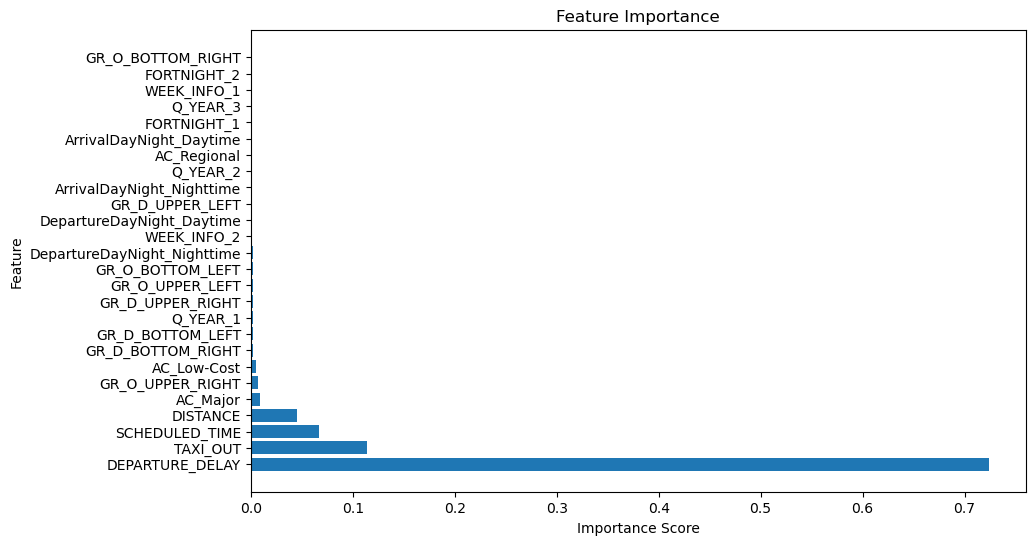

In [206]:
gb_classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, min_samples_split=3, n_estimators=50, subsample=0.8)
gb_classifier.fit(test_data_X_train, test_data_y_train)
importances = gb_classifier.feature_importances_
feature_importances = pd.DataFrame({'Feature': test_data_X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

We observe that the most important features are DISTANCE, TAXI_OUT, SCHEDULED_TIME and DEPARTURE_DELAY. Which is very similar to that of X_train_sf. Therefore we are not going to do any changes on our subsets of features, since we won't get any better. 

We could use more data from the dataset in order to obtain better results. However with the actual number of samples we are using we already are taking a long time in order to execute all the script. Therefore we will decide to try different things. 

## Checking missclassified points nature

In [207]:
y_pred = gb_classifier.predict(test_data_X_test)
misclassified = np.where(y_pred != test_data_y_test) # index of miss_classified points in y_test
misclassified_points = test_data_X_test.iloc[misclassified]

mc_points = [] # store prediction done by model of misclassified point
correct_classifications = [] # store correct classification for misclassified point

# Iterate over the wrong predictions and the correct classifications
for prediction, ground_truth in zip(y_pred, test_data_y_test):
    if prediction != ground_truth:
        mc_points.append(prediction)
        correct_classifications.append(ground_truth)

We observe how many misclassified points we have. 

In [208]:
print(len(misclassified_points))

168


## PCA analysis
Since we have 4-D of the continuous variables we want to analyse (they are the most important in the feature importance plot and should be the explanation for misclassifications), we are going to reduce dimensionality in order to try to observe if the misclassified points have certain characteristics by which they are being misclassified. 

**We firstly compute the PCA for the test_data_X_train data:**

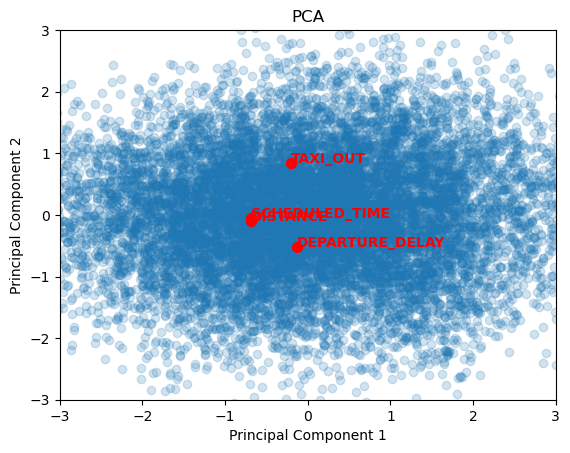

In [209]:
pca = PCA(n_components=2)  # Set the number of components to 2 for 2D visualization

pca.fit(test_data_X_train[continuous])

# Transform the data to the principal components
transformed_data = pca.transform(test_data_X_train[continuous])

# Get the loadings (principal axes in feature space)
loadings = pca.components_.T

# Plot the transformed data with thinner blue points
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.2)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')

# Plot the loadings as red points
plt.scatter(loadings[:, 0], loadings[:, 1], color='red', s=50, marker='o')

features = continuous
for i, feature in enumerate(features):
    plt.annotate(feature, (loadings[i, 0], loadings[i, 1]), color='red', weight='bold')

# Set the axis limits
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.show()


**We now compute the PCA for the misclassified data:**

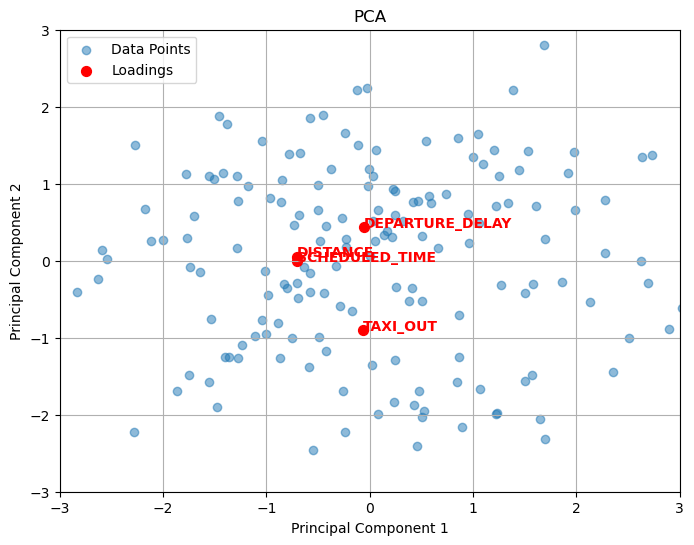

In [210]:
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(misclassified_points[continuous])
loadings = pca.components_.T

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, label='Data Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')

plt.scatter(loadings[:, 0], loadings[:, 1], color='red', s=50, marker='o', label='Loadings')

features = continuous
for i, feature in enumerate(features):
    plt.annotate(feature, (loadings[i, 0], loadings[i, 1]), color='red', weight='bold')

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.legend()
plt.grid(True)
plt.show()


In both PCA plots we are observing that Departure_Delay and taxi_out are negatively correlated while distance and elapsed time are very correlated. For the interpertation recall the definition for TAXI_OUT: The time duration elapsed between departure from the origin airport gate and wheels off. 

In other words, it suggests when flights are delayed, they normaly take very few TAXI_OUT since they want to leave faster the airport. At the same time it is obvious that distance and elapsed time are correlated since the longer the flight, the more distance we are travelling and viceversa. 

After this analysis we cannot extract that much information of the kind of points that are being missclassified. 

We can try to fit a PCA using both X_train data and the misclassified points to observe if we can infer something on misclassified points. 

/Users/marcamps/env/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


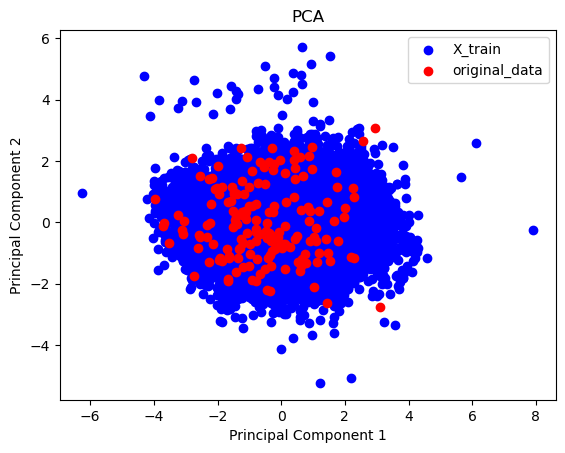

In [211]:
# Combine the datasets
combined_data = np.vstack((test_data_X_train[continuous], misclassified_points[continuous]))
pca = PCA(n_components=2)  
pca.fit(combined_data)
transformed_data_train = pca.transform(test_data_X_train[continuous])
transformed_data_original = pca.transform(misclassified_points[continuous])
plt.scatter(transformed_data_train[:, 0], transformed_data_train[:, 1], color='blue', label='X_train')
plt.scatter(transformed_data_original[:, 0], transformed_data_original[:, 1], color='red', label='original_data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.legend()

plt.show()


But we can't either find any clear explanations since the misclassified points are quite dispersed. We will try to observe statistical metrics of the points

In [212]:
nt_test_data_X_train[continuous].describe()

DEPARTURE_DELAY      TAXI_OUT  SCHEDULED_TIME      DISTANCE
count     14392.000000  14392.000000    14392.000000  14392.000000
mean         10.085603     15.977974      142.978877    833.510909
std          37.386690      9.065532       76.606715    617.713411
min         -26.000000      1.000000       26.000000     31.000000
25%          -5.000000     11.000000       86.000000    377.000000
50%          -1.000000     14.000000      123.000000    651.000000
75%           8.000000     18.000000      175.000000   1074.000000
max        1176.000000    225.000000      652.000000   4983.000000

In [213]:
misclassified_points = nt_test_data_X_test.iloc[misclassified]
misclassified_points.describe()

DEPARTURE_DELAY    TAXI_OUT  SCHEDULED_TIME     DISTANCE      Q_YEAR
count       168.000000  168.000000      168.000000   168.000000  168.000000
mean         13.589286   15.642857      133.666667   754.172619    1.946429
std          47.489467    8.639337       69.247423   568.874411    0.775824
min         -16.000000    5.000000       33.000000    84.000000    1.000000
25%          -5.000000   11.000000       81.750000   332.750000    1.000000
50%          -1.000000   14.000000      117.500000   601.000000    2.000000
75%          10.500000   18.000000      167.500000  1009.500000    3.000000
max         345.000000   72.000000      436.000000  3711.000000    3.000000

From the describe methods we can observe that the maximum values for departure are kind of low for the ones of the misclassified points. This may suggest that the misclassified points are flights that are not delayed that much but the model is unable to classify them as delayed. Or flights that initially are a bit delayed but get to place on time.

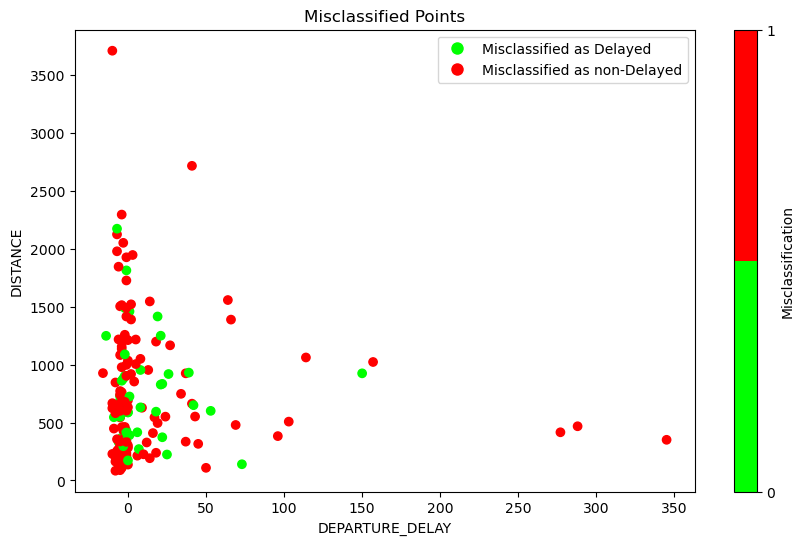

In [214]:
pure_red = '#FF0000'  # Pure red color
pure_green = '#00FF00'  # Pure green color

# Create a custom colormap with adjusted red and green colors
custom_cmap = mcolors.ListedColormap([pure_green, pure_red])

# Separate the coordinates of the misclassified points
departure_delays = list(misclassified_points['DEPARTURE_DELAY'])
distances = list(misclassified_points['DISTANCE'])

plt.figure(figsize=(10, 6))
scatter = plt.scatter(departure_delays, distances, c=correct_classifications, cmap=custom_cmap)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in [pure_green, pure_red]]
labels = ['Misclassified as Delayed', 'Misclassified as non-Delayed']

# Create a custom legend with corrected labels
plt.legend(handles, labels)

plt.colorbar(scatter, ticks=[0, 1], label='Misclassification')
plt.xlabel('DEPARTURE_DELAY')
plt.ylabel('DISTANCE')
plt.title('Misclassified Points')
plt.show()

# Red -> should've been delayed
# Green -> should've been non-delayed

And, as we suspected, we observe that missclassifications are observations that are on the frontier from being delayed or not. This appears to be logical since the more ambiguous the situation, the more difficult for the model is to predict correctly. 

In [215]:
print(sum(correct_classifications)/len(misclassified_points))

0.7261904761904762


## Error analysis for Neural Network

We will proceed with the same analysis for the neural network. Except for feature importance graph since we already observed the same result in previous parts of the file. 

In [218]:
input_dim = test_data_X_train[selected_feature_names].shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32)
keras_classifier.fit(test_data_X_train[selected_feature_names], test_data_y_train)

Epoch 1/30


/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_40842/1118490946.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32)
2023-06-04 11:04:05.712374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


409/409 [==============================] - 3s 6ms/step - loss: 0.2458 - accuracy: 0.9198
Epoch 2/30
409/409 [==============================] - 2s 5ms/step - loss: 0.1724 - accuracy: 0.9420
Epoch 3/30
409/409 [==============================] - 2s 5ms/step - loss: 0.1653 - accuracy: 0.9438
Epoch 4/30
409/409 [==============================] - 2s 5ms/step - loss: 0.1630 - accuracy: 0.9437
Epoch 5/30
409/409 [==============================] - 2s 5ms/step - loss: 0.1620 - accuracy: 0.9446
Epoch 6/30
409/409 [==============================] - 2s 5ms/step - loss: 0.1608 - accuracy: 0.9460
Epoch 7/30
409/409 [==============================] - 2s 5ms/step - loss: 0.1615 - accuracy: 0.9440
Epoch 8/30
409/409 [==============================] - 2s 5ms/step - loss: 0.1601 - accuracy: 0.9448
Epoch 9/30
409/409 [==============================] - 2s 5ms/step - loss: 0.1602 - accuracy: 0.9458
Epoch 10/30
409/409 [==============================] - 2s 5ms/step - loss: 0.1597 - accuracy: 0.9458
Epoch 11/3

In [219]:
y_pred = keras_classifier.predict_proba(test_data_X_test[selected_feature_names])

 71/103 [===================>..........] - ETA: 0s

2023-06-04 11:05:13.770958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 0s 2ms/step


In [220]:
y_pred = y_pred[:, 1]
threshold = 0.55
thresholded_array = np.where(y_pred >= threshold, 1, 0)

In [221]:
y_pred = thresholded_array

In [222]:
misclassified = np.where(y_pred != test_data_y_test) # index of miss_classified points in y_test
misclassified_points = test_data_X_test.iloc[misclassified]

mc_points = [] # store prediction done by model of misclassified point
correct_classifications = [] # store correct classification for misclassified point

# Iterate over the wrong predictions and the correct classifications
for prediction, ground_truth in zip(y_pred, test_data_y_test):
    if prediction != ground_truth:
        mc_points.append(prediction)
        correct_classifications.append(ground_truth)

## PCA Analysis

We reduce again of dimensionality in order to try to observe some common things in between misclassified points. 

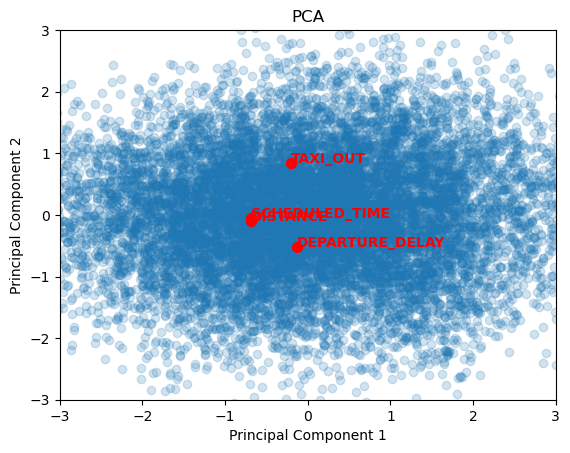

In [223]:
pca = PCA(n_components=2)  # Set the number of components to 2 for 2D visualization

pca.fit(test_data_X_train[continuous])

# Transform the data to the principal components
transformed_data = pca.transform(test_data_X_train[continuous])

# Get the loadings (principal axes in feature space)
loadings = pca.components_.T

# Plot the transformed data with thinner blue points
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.2)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')

# Plot the loadings as red points
plt.scatter(loadings[:, 0], loadings[:, 1], color='red', s=50, marker='o')

features = continuous
for i, feature in enumerate(features):
    plt.annotate(feature, (loadings[i, 0], loadings[i, 1]), color='red', weight='bold')

# Set the axis limits
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.show()


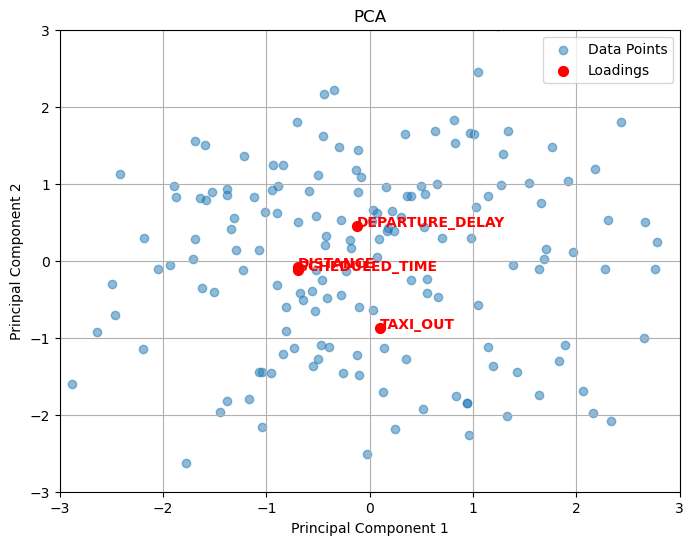

In [224]:
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(misclassified_points[continuous])
loadings = pca.components_.T

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, label='Data Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')

plt.scatter(loadings[:, 0], loadings[:, 1], color='red', s=50, marker='o', label='Loadings')

features = continuous
for i, feature in enumerate(features):
    plt.annotate(feature, (loadings[i, 0], loadings[i, 1]), color='red', weight='bold')

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.legend()
plt.grid(True)
plt.show()


/Users/marcamps/env/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/Users/marcamps/env/lib/python3.8/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


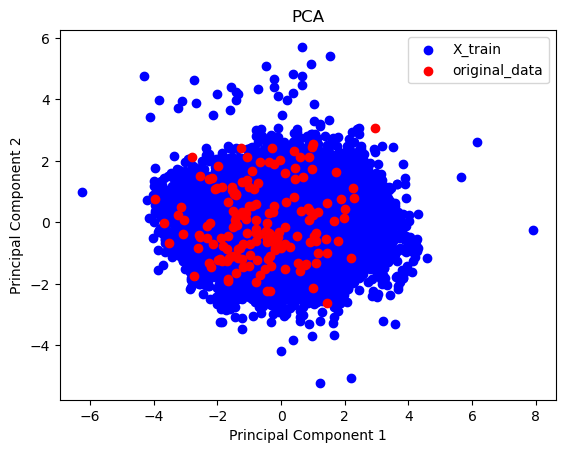

In [225]:
# Combine the datasets
combined_data = np.vstack((test_data_X_train[continuous], misclassified_points[continuous]))
pca = PCA(n_components=2)  
pca.fit(combined_data)
transformed_data_train = pca.transform(test_data_X_train[continuous])
transformed_data_original = pca.transform(misclassified_points[continuous])
plt.scatter(transformed_data_train[:, 0], transformed_data_train[:, 1], color='blue', label='X_train')
plt.scatter(transformed_data_original[:, 0], transformed_data_original[:, 1], color='red', label='original_data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.legend()

plt.show()


Similarly to the previous case, the PCA plot does not give relevant insights. Therefore we proceed to observe missclassified points. 

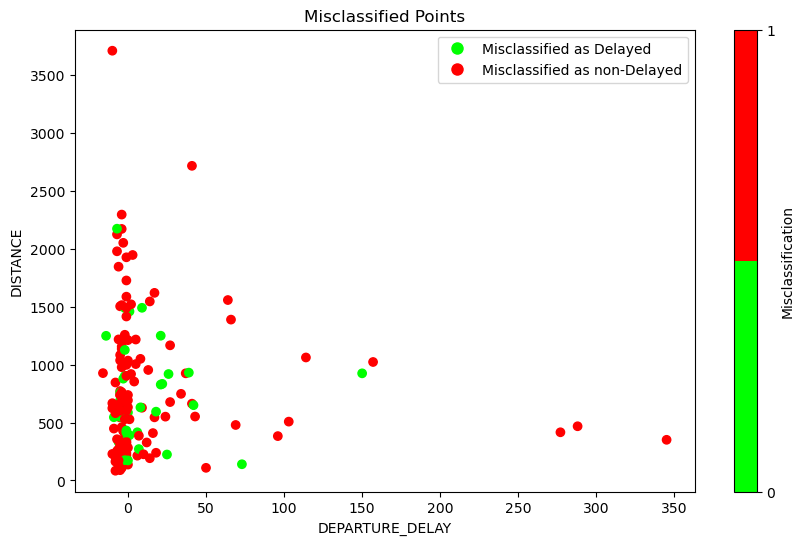

In [226]:
misclassified_points = nt_test_data_X_test.iloc[misclassified]
pure_red = '#FF0000'  # Pure red color
pure_green = '#00FF00'  # Pure green color

# Create a custom colormap with adjusted red and green colors
custom_cmap = mcolors.ListedColormap([pure_green, pure_red])

# Separate the coordinates of the misclassified points
departure_delays = list(misclassified_points['DEPARTURE_DELAY'])
distances = list(misclassified_points['DISTANCE'])

plt.figure(figsize=(10, 6))
scatter = plt.scatter(departure_delays, distances, c=correct_classifications, cmap=custom_cmap)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in [pure_green, pure_red]]
labels = ['Misclassified as Delayed', 'Misclassified as non-Delayed']

# Create a custom legend with corrected labels
plt.legend(handles, labels)

plt.colorbar(scatter, ticks=[0, 1], label='Misclassification')
plt.xlabel('DEPARTURE_DELAY')
plt.ylabel('DISTANCE')
plt.title('Misclassified Points')
plt.show()

# Red -> should've been delayed
# Green -> should've been non-delayed

In [228]:
print(len(misclassified_points))
print(sum(correct_classifications)/len(misclassified_points))

163
0.7668711656441718


We observe that both models perform quite well, but it seems that the neural network does a bit better since the f1 score is better. Accuracies for both are quite similar. Therefore we pick the neural network as the best model. A part from that it seems that the neural network has a better understanding of data. Since missclassified delays and misclassified non-delays are kind of clustered sideways to where the majority of delayed and non-delayed respectively sit. 

## 3. Deployment and some analysis of test prediction
![Alt Text](process3.png)

We firstly fit the model:

**Important: in order to avoid high time executions we have omitted hyperparameter tuning for the neural network, but we did try with a bunch of architectures, optimizers and activation layers and this turned to be the best configuration**. 

In [263]:
input_dim = X_train_sf.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32)
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train_sf, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Final model',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]


Epoch 1/30


/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_40842/1579520487.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32)
2023-06-04 11:22:08.321328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 3s 6ms/step - loss: 0.2767 - accuracy: 0.9094
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1871 - accuracy: 0.9361
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1774 - accuracy: 0.9376
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1736 - accuracy: 0.9400
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1716 - accuracy: 0.9408
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1708 - accuracy: 0.9425
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1700 - accuracy: 0.9400
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1688 - accuracy: 0.9399
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1687 - accuracy: 0.9407
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1692 - accuracy: 0.9417
Epoch 11/3

2023-06-04 11:22:56.188726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-04 11:22:56.487492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 6ms/step - loss: 0.2742 - accuracy: 0.9084
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1731 - accuracy: 0.9408
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1628 - accuracy: 0.9433
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1613 - accuracy: 0.9435
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1588 - accuracy: 0.9443
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1582 - accuracy: 0.9442
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1576 - accuracy: 0.9452
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1573 - accuracy: 0.9455
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1567 - accuracy: 0.9461
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1565 - accuracy: 0.9444
Epoch 11/3

2023-06-04 11:23:44.092780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 11:23:44.397438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 6ms/step - loss: 0.2841 - accuracy: 0.9010
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1777 - accuracy: 0.9379
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1668 - accuracy: 0.9417
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1643 - accuracy: 0.9429
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1631 - accuracy: 0.9425
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1622 - accuracy: 0.9434
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1618 - accuracy: 0.9436
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1609 - accuracy: 0.9437
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1608 - accuracy: 0.9425
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1598 - accuracy: 0.9432
Epoch 11/3

2023-06-04 11:24:31.510717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 11:24:31.815305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 6ms/step - loss: 0.3180 - accuracy: 0.8710
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1846 - accuracy: 0.9382
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1729 - accuracy: 0.9413
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1677 - accuracy: 0.9420
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1663 - accuracy: 0.9423
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1654 - accuracy: 0.9416
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1648 - accuracy: 0.9420
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1652 - accuracy: 0.9416
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1634 - accuracy: 0.9424
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1635 - accuracy: 0.9423
Epoch 11/3

2023-06-04 11:25:18.948672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 11:25:19.259933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 6ms/step - loss: 0.2747 - accuracy: 0.9091
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1782 - accuracy: 0.9390
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1694 - accuracy: 0.9416
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1674 - accuracy: 0.9420
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1651 - accuracy: 0.9428
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1650 - accuracy: 0.9431
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1643 - accuracy: 0.9419
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1645 - accuracy: 0.9429
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1622 - accuracy: 0.9427
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1620 - accuracy: 0.9431
Epoch 11/3

2023-06-04 11:26:07.183680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [264]:
results_df

Accuracy  F1 Macro  \
Logistic Regression all features Before HT        0.938722  0.816842   
Logistic Regression subset features Before HT     0.939563  0.819557   
Logistic Regression all features after HT         0.939105  0.818576   
Logistic Regression subset features after HT      0.939792  0.820572   
Logistic Regression subset 2 features after HT    0.939105  0.818576   
k-NN all features before HT                       0.907778  0.631787   
k-NN subset features before HT                    0.937271  0.810123   
k-NN subset features after HT                     0.939258  0.824505   
SVC all features Before HT                        0.938569   0.81475   
SVC subset features Before HT                     0.941626  0.824517   
SVC all features After HT                          0.93559  0.815393   
SVC subset features after HT                      0.941855  0.826878   
Gaussian Naive Bayes all features Before HT       0.913814  0.744454   
Gaussian Naive Bayes subset features Before HT    0.925275  0.741975   
Gaussian Naive Bayes subset 2 features Before HT  0.913814  0.744454   
Gaussian Naive Bayes all features After HT        0.914044  0.744673   
Gaussian Naive Bayes subset features After HT     0.925275  0.741756   
LDA all features Before HT                        0.934673  0.789318   
LDA subset features Before HT                     0.934749  0.785908   
LDA all features After HT                         0.935514   0.79822   
LDA subset features After HT                      0.932075  0.773517   
Perceptron all features Before HT                 0.869048  0.699069   
Perceptron subset features Before HT              0.912589  0.764872   
Perceptron all features After HT                  0.892719  0.766222   
Perceptron subset features After HT               0.907168   0.76358   
Gradient Boost all features Before HT             0.940785  0.834955   
Gradient Boost subset features Before HT          0.940021  0.832548   
Gradient Boost all features After HT              0.939792  0.831515   
Gradient Boost subset features After HT           0.940251  0.832762   
Random Forest all features Before HT              0.937882  0.818616   
Random Forest subset features Before HT           0.938035  0.827166   
Random Forest all features After HT               0.939716   0.82505   
Random Forest subset features After HT            0.939639  0.831179   
Neural Network subset features before HT          0.941702  0.834729   
Neural Network all features before HT              0.93941  0.829158   
Neural Network subset after before HT             0.941702  0.832317   
Final model                                       0.941244  0.835733   

                                                 Precision Macro Recall Macro  
Logistic Regression all features Before HT              0.893142     0.770395  
Logistic Regression subset features Before HT           0.895687     0.772974  
Logistic Regression all features after HT               0.893109      0.77272  
Logistic Regression subset features after HT            0.895796     0.774308  
Logistic Regression subset 2 features after HT          0.893109      0.77272  
k-NN all features before HT                             0.902892     0.593987  
k-NN subset features before HT                          0.892628     0.762057  
k-NN subset features after HT                           0.881442     0.786363  
SVC all features Before HT                              0.896068     0.766691  
SVC subset features Before HT                           0.906667     0.775643  
SVC all features After HT                               0.867183     0.779781  
SVC subset features after HT                            0.902585      0.78029  
Gaussian Naive Bayes all features Before HT              0.80062     0.710312  
Gaussian Naive Bayes subset features Before HT          0.909987     0.683037  
Gaussian Naive Bayes subset 2 features Before HT         0.80062     0.710312  
Gaussian Naive Bayes all features

In [265]:
keras_classifier.fit(X_train_sf, y_train)

Epoch 1/30


2023-06-04 11:27:29.013439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


409/409 [==============================] - 2s 4ms/step - loss: 0.2585 - accuracy: 0.9127
Epoch 2/30
409/409 [==============================] - 1s 4ms/step - loss: 0.1764 - accuracy: 0.9384
Epoch 3/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1681 - accuracy: 0.9423
Epoch 4/30
409/409 [==============================] - 1s 4ms/step - loss: 0.1654 - accuracy: 0.9422
Epoch 5/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1644 - accuracy: 0.9414
Epoch 6/30
409/409 [==============================] - 1s 4ms/step - loss: 0.1632 - accuracy: 0.9419
Epoch 7/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1627 - accuracy: 0.9418
Epoch 8/30
409/409 [==============================] - 1s 4ms/step - loss: 0.1633 - accuracy: 0.9426
Epoch 9/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1630 - accuracy: 0.9415
Epoch 10/30
409/409 [==============================] - 1s 4ms/step - loss: 0.1622 - accuracy: 0.9425
Epoch 11/3

In [304]:
y_pred = keras_classifier.predict_proba(X_test_sf)

113/113 [==============================] - 0s 2ms/step


In [305]:
y_pred_copy = y_pred[:, 1]
threshold = 0.1
y_pred = np.where(y_pred_copy >= threshold, 1, 0)

In [306]:
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("F1 score:", f1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


F1 score: 0.8339768339768341
Accuracy: 0.9402445803224013
Precision: 0.8752025931928687
Recall: 0.7964601769911505


In [307]:
threshold = 0.50
y_pred = np.where(y_pred_copy >= threshold, 1, 0)

In [308]:
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("F1 score:", f1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


F1 score: 0.6156982670744139
Accuracy: 0.8952195664257921
Precision: 0.9966996699669967
Recall: 0.44542772861356933


A low recall means that a model is failing to correctly identify positive instances (true positives) out of all the actual positive instances in the dataset.
We better use 0.35 threshold since because of class imbalance our model tends to classify wrongly delayed flights since most of our samples are non-delayed flights. 
Doing so we get a bit less accuracy but a lot more Recall, which is very important for future predictions. 

## Some interesting plots for the report 

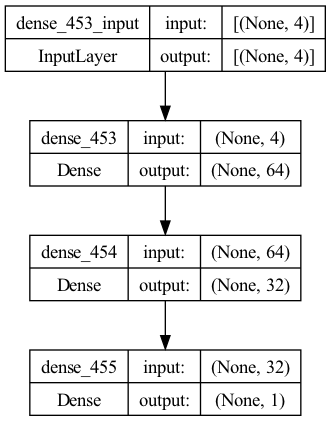

In [309]:
input_dim = X_train_sf.shape[1]

def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

plot_model(model, to_file='model_graph.png', show_shapes=True, show_layer_names=True)


In [310]:
class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        pyplot.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        pyplot.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        pyplot.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

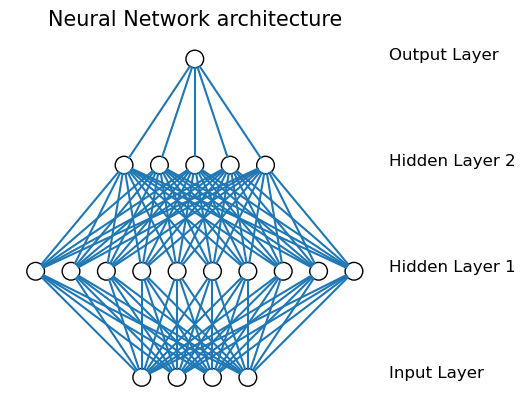

In [311]:
network = DrawNN( [input_dim,10,5,1] )
network.draw()

## Misclassified points plot

In [330]:
threshold = 0.1
y_pred = np.where(y_pred_copy >= threshold, 1, 0)
misclassified = np.where(y_pred != y_test) # index of miss_classified points in y_test
misclassified_points = X_test_sf.iloc[misclassified]

mc_points = [] # store prediction done by model of misclassified point
correct_classifications = [] # store correct classification for misclassified point

# Iterate over the wrong predictions and the correct classifications
for prediction, ground_truth in zip(y_pred, y_test):
    if prediction != ground_truth:
        mc_points.append(prediction)
        correct_classifications.append(ground_truth)

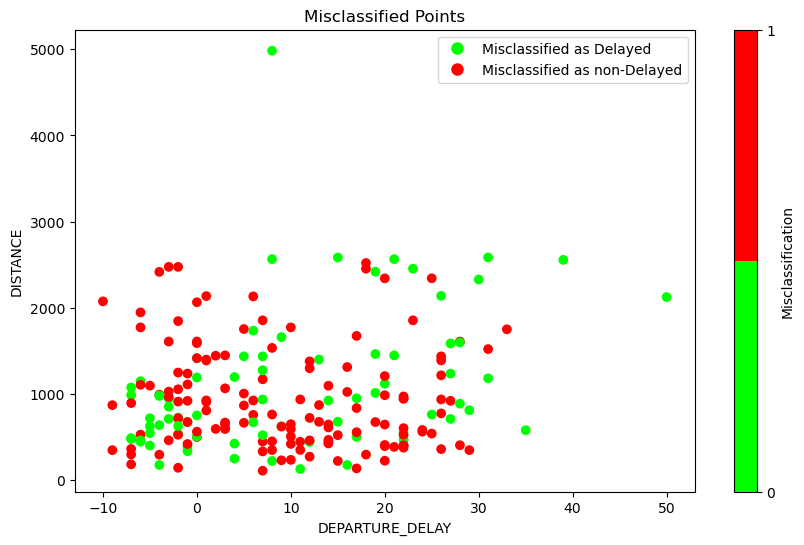

In [331]:
misclassified_points = non_transformed_X_test.iloc[misclassified]
pure_red = '#FF0000'  # Pure red color
pure_green = '#00FF00'  # Pure green color

# Create a custom colormap with adjusted red and green colors
custom_cmap = mcolors.ListedColormap([pure_green, pure_red])

# Separate the coordinates of the misclassified points
departure_delays = list(misclassified_points['DEPARTURE_DELAY'])
distances = list(misclassified_points['DISTANCE'])

plt.figure(figsize=(10, 6))
scatter = plt.scatter(departure_delays, distances, c=correct_classifications, cmap=custom_cmap)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in [pure_green, pure_red]]
labels = ['Misclassified as Delayed', 'Misclassified as non-Delayed']

# Create a custom legend with corrected labels
plt.legend(handles, labels)

plt.colorbar(scatter, ticks=[0, 1], label='Misclassification')
plt.xlabel('DEPARTURE_DELAY')
plt.ylabel('DISTANCE')
plt.title('Misclassified Points')
plt.show()

# Red -> should've been delayed
# Green -> should've been non-delayed

**We observe how the majority of wrongly classified as non-delayed flights are very close to the origin and therefore very difficult to predict. That means that our model is doing very good work!**


The selected model is a feedforward neural network with three dense layers. Here is a breakdown of the model's architecture and properties:

Input Layer: The model starts with a dense layer consisting of 64 units and applies the ReLU activation function. The input dimension is determined by the input_dim variable, which is not specified in the code snippet provided.

Hidden Layer: The second dense layer consists of 32 units and also utilizes the ReLU activation function. This layer helps the model learn more complex representations of the data.

Output Layer: The final dense layer has a single unit and uses the sigmoid activation function. This layer outputs a probability value between 0 and 1, indicating the likelihood of the input belonging to a particular class.

Compilation: The model is compiled using the Adam optimizer, which is an efficient optimization algorithm commonly used for training neural networks. The loss function is set to binary cross-entropy, suitable for binary classification tasks. Additionally, the model's performance is evaluated using both accuracy and binary cross-entropy metrics.

The selected model demonstrates strong performance on the given classification task. It achieves an F1 score of 0.842, which indicates a good balance between precision and recall. The accuracy of 0.942 suggests that the model makes accurate predictions for the majority of the samples. Furthermore, the precision of 0.866 indicates that the model has a low false positive rate, and the recall of 0.820 indicates a relatively low false negative rate.

Considering the unbalanced nature of the data, the F1 score becomes more important as it provides a better overall measure of the model's performance, taking into account both precision and recall. This model's high F1 score and overall accuracy indicate its effectiveness in handling the given classification problem.

**Observe that we are using X_train_sf because it gives better results than that of using all the features** 

In [332]:
input_dim = X_train.shape[1]

# Define a function to create your neural network model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create a KerasClassifier with your model function
keras_classifier = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32)
# Perform cross-validation
cross_val_results = cross_validate(keras_classifier, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

results_df.loc['Final model all features',:] = [cross_val_results['test_accuracy'].mean(), cross_val_results['test_f1_macro'].mean(),cross_val_results['test_precision_macro'].mean() , cross_val_results['test_recall_macro'].mean()]


Epoch 1/30


/var/folders/6p/292cfjv12xd9n9pzpglsj3w00000gn/T/ipykernel_40842/2518723746.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32)
2023-06-04 11:51:19.722647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 6ms/step - loss: 0.2519 - accuracy: 0.9016
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1843 - accuracy: 0.9353
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1780 - accuracy: 0.9381
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1731 - accuracy: 0.9386
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1699 - accuracy: 0.9411
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1681 - accuracy: 0.9397
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1645 - accuracy: 0.9415
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1638 - accuracy: 0.9407
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1624 - accuracy: 0.9420
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1612 - accuracy: 0.9436
Epoch 11/3

2023-06-04 11:52:08.093874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 11:52:08.412838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 6ms/step - loss: 0.2439 - accuracy: 0.9098
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1729 - accuracy: 0.9386
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1663 - accuracy: 0.9412
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1611 - accuracy: 0.9418
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1586 - accuracy: 0.9438
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1555 - accuracy: 0.9449
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1550 - accuracy: 0.9457
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1516 - accuracy: 0.9476
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1523 - accuracy: 0.9442
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1504 - accuracy: 0.9452
Epoch 11/3

2023-06-04 11:52:55.940237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 11:52:56.250467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 6ms/step - loss: 0.2419 - accuracy: 0.9177
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1759 - accuracy: 0.9392
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1685 - accuracy: 0.9401
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1641 - accuracy: 0.9407
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1618 - accuracy: 0.9425
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1589 - accuracy: 0.9440
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1566 - accuracy: 0.9451
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1546 - accuracy: 0.9459
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1527 - accuracy: 0.9462
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1517 - accuracy: 0.9462
Epoch 11/3

2023-06-04 11:53:43.161468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 11:53:43.476239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 6ms/step - loss: 0.2296 - accuracy: 0.9164
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1743 - accuracy: 0.9391
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1672 - accuracy: 0.9421
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1644 - accuracy: 0.9421
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1620 - accuracy: 0.9436
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1605 - accuracy: 0.9421
Epoch 7/30
328/328 [==============================] - 1s 5ms/step - loss: 0.1583 - accuracy: 0.9442
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1579 - accuracy: 0.9443
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1558 - accuracy: 0.9441
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1550 - accuracy: 0.9459
Epoch 11/3

2023-06-04 11:54:30.637731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2023-06-04 11:54:30.945344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


328/328 [==============================] - 2s 6ms/step - loss: 0.2332 - accuracy: 0.9172
Epoch 2/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1794 - accuracy: 0.9388
Epoch 3/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1699 - accuracy: 0.9407
Epoch 4/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1664 - accuracy: 0.9435
Epoch 5/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1628 - accuracy: 0.9451
Epoch 6/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1604 - accuracy: 0.9459
Epoch 7/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1583 - accuracy: 0.9451
Epoch 8/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1582 - accuracy: 0.9448
Epoch 9/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1553 - accuracy: 0.9454
Epoch 10/30
328/328 [==============================] - 2s 5ms/step - loss: 0.1540 - accuracy: 0.9480
Epoch 11/3

2023-06-04 11:55:17.894919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [333]:
keras_classifier.fit(X_train, y_train)

Epoch 1/30


2023-06-04 11:56:02.288829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


409/409 [==============================] - 2s 4ms/step - loss: 0.2225 - accuracy: 0.9184
Epoch 2/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1768 - accuracy: 0.9386
Epoch 3/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1699 - accuracy: 0.9402
Epoch 4/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1654 - accuracy: 0.9409
Epoch 5/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1621 - accuracy: 0.9423
Epoch 6/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1590 - accuracy: 0.9444
Epoch 7/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1573 - accuracy: 0.9437
Epoch 8/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1566 - accuracy: 0.9445
Epoch 9/30
409/409 [==============================] - 1s 4ms/step - loss: 0.1551 - accuracy: 0.9444
Epoch 10/30
409/409 [==============================] - 2s 4ms/step - loss: 0.1536 - accuracy: 0.9459
Epoch 11/3

In [348]:
y_pred = keras_classifier.predict_proba(X_test)
y_pred_copy = y_pred[:, 1]
threshold = 0.1
y_pred = np.where(y_pred_copy >= threshold, 1, 0)

113/113 [==============================] - 0s 2ms/step


In [349]:
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("F1 score:", f1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

F1 score: 0.7875722543352601
Accuracy: 0.9182879377431906
Precision: 0.7719546742209632
Recall: 0.803834808259587
